In [1]:
import iyer_saliency
import sarfa_saliency

import chess 
import chess.uci
import time

from sys import platform as _platform
from collections import defaultdict


from IPython.display import Image, display
import cairosvg
import cv2
import svg_custom.svg_custom as svg_custom 
import matplotlib.pyplot as plt
import numpy as np

import json 
import pandas as pd 
from pandas.io.json import json_normalize 

from collections import defaultdict
import operator
from pymoo.factory import get_performance_indicator

import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from sklearn import metrics
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
import sys

plt.rcParams['figure.figsize']=(16,16)
import PIL

from IPython.display import Image, display
import cairosvg
import cv2
import svg_custom.svg_custom as svg_custom 
import matplotlib.pyplot as plt
import numpy as np


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The chess.uci module is deprecated in favor of
chess.engine <https://python-chess.readthedocs.io/en/latest/engine.html>.

Please consider updating and open an issue
<https://github.com/niklasf/python-chess/issues/new> if your use case
is not covered by the new API.
  """


In [2]:
def select_engine():
    handler = chess.uci.InfoHandler()
    if _platform == "linux" or _platform == "linux2":

        engine = chess.uci.popen_engine('engines/stockfish-11-linux/stockfish-11-linux/Linux/stockfish_20011801_x64')

    elif _platform == "darwin":
        engine = chess.uci.popen_engine('engines/stockfish-11-mac/stockfish-11-mac/Mac/stockfish-11-64')

    elif _platform == "win32":
        engine = chess.uci.popen_engine('engines/stockfish-11-win/stockfish-11-win/Windows/stockfish_20011801_32bit.exe') 

    elif _platform == "win64":
        engine = chess.uci.popen_engine('engines/stockfish-11-win/stockfish-11-win/Windows/stockfish_20011801_x64.exe')
    engine.setoption({'MultiPV': 100})
    engine.info_handlers.append(handler)
    return handler,engine

In [3]:
def get_dict_q_vals(board, legal_moves, eval_time, original_move,engine,handler):
    """
    Function returns Q-values in given board position
    Input:
        board: chess.Board()
        legal_moves: List of legal moves of original state
        eval_time: Search time for stockfish
        original_move: original best move (chess.Move()) 
    Output:
        q_vals_dict: Dictionary containing Q-values and Actions
        bestmove: chess.Move() - Best move in given board position
    """
    
    i = 0
    q_vals_dict = {}
    
    
    set_current_legal_moves = set(board.legal_moves)
    set_original_legal_moves = set(legal_moves)
    intersection_set = set_current_legal_moves.intersection(set_original_legal_moves)

    #print('querying engine with perturbed position')
    engine.position(board)
    evaluation = engine.go(movetime=eval_time)
    #print(evaluation)
    if original_move is None:
        # no initial move supplied
        original_move = evaluation.bestmove
    dict_moves_to_score = defaultdict(int)
    
    for move_id in handler.info['pv'].keys():
        move_string = str(handler.info['pv'][move_id][0])
        move_score = 0
        if handler.info["score"][move_id].cp is None:
            mate_in_moves = handler.info["score"][move_id].mate
            if mate_in_moves > 0:
                # white will win in some number of moves
                move_score = 40
            else:
                # black will win 
                move_score = -40
        else:
            move_score = round(handler.info["score"][move_id].cp/100.0,2)
        dict_moves_to_score[move_string] = move_score
    
    #print(dict_moves_to_score)
    
    #print('Total Legal Moves : ', len(intersection_set))

    for el in legal_moves:
        if el in intersection_set:
            i += 1
            score = dict_moves_to_score[str(el)]
            q_vals_dict[el.uci()] = score
    
    return q_vals_dict, evaluation.bestmove

In [4]:
def computeSaliency(FEN = 'rnbq1rk1/pp2bppp/4p3/3p3n/3P1B2/3B1N2/PPPNQPPP/R3K2R w KQkq - 0 1',typeSal='sarfa',engine= chess.uci.popen_engine('engines/stockfish-11-linux/stockfish-11-linux/Linux/stockfish_20011801_x64'),handler=None):
    """
    Function returns saliency map for given board position  
    Input:
        FEN : Board position encoded in a FEN  
    Output:
        answer : Saliency for each location on the board
    """

    print("***********************", FEN, "**********************")
    board = chess.Board(FEN)
    evaltime = 6000
    legal_moves = list(board.legal_moves)[:]

    # Q-values for original state
    dict_q_values_before_perturbation, original_move  = get_dict_q_vals(board, legal_moves, evaltime, None,engine,handler)
    #print('original move = ', original_move)
    
    # Saliency for each board location
    answer = {
        'a1' : {'int': chess.A1, 'saliency': -2},
        'a2' : {'int': chess.A2, 'saliency': -2},
        'a3' : {'int': chess.A3, 'saliency': -2},
        'a4' : {'int': chess.A4, 'saliency': -2},
        'a5' : {'int': chess.A5, 'saliency': -2},
        'a6' : {'int': chess.A6, 'saliency': -2},
        'a7' : {'int': chess.A7, 'saliency': -2},
        'a8' : {'int': chess.A8, 'saliency': -2},
        'b1' : {'int': chess.B1, 'saliency': -2},
        'b2' : {'int': chess.B2, 'saliency': -2},
        'b3' : {'int': chess.B3, 'saliency': -2},
        'b4' : {'int': chess.B4, 'saliency': -2},
        'b5' : {'int': chess.B5, 'saliency': -2},
        'b6' : {'int': chess.B6, 'saliency': -2},
        'b7' : {'int': chess.B7, 'saliency': -2},
        'b8' : {'int': chess.B8, 'saliency': -2},
        'c1' : {'int': chess.C1, 'saliency': -2},
        'c2' : {'int': chess.C2, 'saliency': -2},
        'c3' : {'int': chess.C3, 'saliency': -2},
        'c4' : {'int': chess.C4, 'saliency': -2},
        'c5' : {'int': chess.C5, 'saliency': -2},
        'c6' : {'int': chess.C6, 'saliency': -2},
        'c7' : {'int': chess.C7, 'saliency': -2},
        'c8' : {'int': chess.C8, 'saliency': -2},
        'd1' : {'int': chess.D1, 'saliency': -2},
        'd2' : {'int': chess.D2, 'saliency': -2},
        'd3' : {'int': chess.D3, 'saliency': -2},
        'd4' : {'int': chess.D4, 'saliency': -2},
        'd5' : {'int': chess.D5, 'saliency': -2},
        'd6' : {'int': chess.D6, 'saliency': -2},
        'd7' : {'int': chess.D7, 'saliency': -2},
        'd8' : {'int': chess.D8, 'saliency': -2},
        'e1' : {'int': chess.E1, 'saliency': -2},
        'e2' : {'int': chess.E2, 'saliency': -2},
        'e3' : {'int': chess.E3, 'saliency': -2},
        'e4' : {'int': chess.E4, 'saliency': -2},
        'e5' : {'int': chess.E5, 'saliency': -2},
        'e6' : {'int': chess.E6, 'saliency': -2},
        'e7' : {'int': chess.E7, 'saliency': -2},
        'e8' : {'int': chess.E8, 'saliency': -2},
        'f1' : {'int': chess.F1, 'saliency': -2},
        'f2' : {'int': chess.F2, 'saliency': -2},
        'f3' : {'int': chess.F3, 'saliency': -2},
        'f4' : {'int': chess.F4, 'saliency': -2},
        'f5' : {'int': chess.F5, 'saliency': -2},
        'f6' : {'int': chess.F6, 'saliency': -2},
        'f7' : {'int': chess.F7, 'saliency': -2},
        'f8' : {'int': chess.F8, 'saliency': -2},
        'g1' : {'int': chess.G1, 'saliency': -2},
        'g2' : {'int': chess.G2, 'saliency': -2},
        'g3' : {'int': chess.G3, 'saliency': -2},
        'g4' : {'int': chess.G4, 'saliency': -2},
        'g5' : {'int': chess.G5, 'saliency': -2},
        'g6' : {'int': chess.G6, 'saliency': -2},
        'g7' : {'int': chess.G7, 'saliency': -2},
        'g8' : {'int': chess.G8, 'saliency': -2},
        'h1' : {'int': chess.H1, 'saliency': -2},
        'h2' : {'int': chess.H2, 'saliency': -2},
        'h3' : {'int': chess.H3, 'saliency': -2},
        'h4' : {'int': chess.H4, 'saliency': -2},
        'h5' : {'int': chess.H5, 'saliency': -2},
        'h6' : {'int': chess.H6, 'saliency': -2},
        'h7' : {'int': chess.H7, 'saliency': -2},
        'h8' : {'int': chess.H8, 'saliency': -2},

        }
    
    # Iteratively perturb each feature on the board
    # Note : Perturbations should be valid. Code for avoiding those cases.
    
    for square_string in sorted(answer.keys()):
        entry = answer[square_string]
        entry_keys = ['saliency']
        #print('perturbing square = ', square_string)
        # perturb board
        piece_removed = board.remove_piece_at(entry['int'])
        
        if piece_removed is None:
            # square was empty, so proceed without changing anything
            #print('square was empty, so skipped')
            # print(board)
            #print('------------------------------------------')
        
            continue
        
        elif (piece_removed == chess.Piece(6,True) or piece_removed == chess.Piece(6,False)) or board.was_into_check():
            # illegal piece was removed
            #print('illegal piece was removed')
            for key in entry_keys:
                entry[key] = 0
        else:
            # set perturbed state
            engine.position(board)

            # Check if the original move is still valid
            if board.is_legal(original_move):
                # Find the q values 
                dict_q_values_after_perturbation, _ = get_dict_q_vals(board, legal_moves, evaltime, original_move,engine,handler)
                if typeSal=='sarfa':
                    entry['saliency'], entry['dP'], entry['K'], entry['QMaxAnswer'],\
                    entry['actionGapBeforePerturbation'], entry['actionGapAfterPerturbation']\
                         = sarfa_saliency.computeSaliencyUsingSarfa(str(original_move), dict_q_values_before_perturbation, dict_q_values_after_perturbation)
                    #entry['saliency'], entry['dP'], entry['K'] =sarfa_saliency.computeSaliencyUsingSarfa(str(original_move), dict_q_values_before_perturbation, dict_q_values_after_perturbation)
                    
                    dd = defaultdict(list)

                    for d in (dict_q_values_after_perturbation, dict_q_values_before_perturbation): # you can list as many input dicts as you want here
                        for key, value in d.items():
                            dd[key].append(value)
                    entry['Q-Value']=dict(dd)

                else:
                    entry['saliency']=iyer_saliency.computeSaliencyUsingIyer(str(original_move), dict_q_values_before_perturbation, dict_q_values_after_perturbation)
            else:
                # illegal original move in perturbed state, therefore piece removed is probably important 
                # print(board.is_legal(original_move))
                # print(board)
                #print('original move illegal in perturbed state')
                for key in entry_keys:
                    entry[key] = -1
                entry['saliency'] = 1
                #entry['dP']=1
                #entry['K']=1
                
        # undo perturbation
        #print('------------------------------------------')
                
        board.set_piece_at(entry['int'], piece_removed)
        
    #print('BBBOB',answer)
    return answer

In [5]:
# Cell for displaying board position

# Few utility functions
def svg_to_png(img):
    '''
    Converts given svg image to png
    Input : 
        img : image in .svg format 
    Output :
        svg_custom/board.png
        Display of image
    '''
    with open('svg_custom/board.svg', 'w+') as f:
        f.write(img)
    cairosvg.svg2png(url='svg_custom/board.svg', write_to='svg_custom/board.png')
    display(Image(filename='svg_custom/board.png'))

def display_board(board):
    '''
    Displaying given board
    Input : 
        board : chess.Board
    Output :
        svg_custom/board.png
        Display of image     
    '''
    img = svg_custom.board(board,coordinates=False)
    svg_to_png(img)
    
def return_bestmove(board,engine, eval_time = 6000):
    '''
    Returns and displays best move for a given chess position
    Input :
        board : chess.Board
    Output :
        bestmove : chess.Move 
    '''
    engine.position(board)
    bestmove =  engine.go(movetime=eval_time).bestmove
    #print('Best move is', bestmove)
    
    #svg_w_arrow = svg_custom.board(board, arrows = [svg_custom.Arrow(tail =  bestmove.from_square, head = bestmove.to_square, color = '#e6e600')])
    
    #svg_to_png(svg_w_arrow)
    
    return bestmove

def explanation(board,typeS,engine,handler):
    '''
    Generates explanation of the best move for given board position using SARFA
    
    Input :
        board = chess.Board
    Output :
        prints piecewise saliency
        svg_custom/board.png
    '''
    
    bestmove =  engine.go(movetime=6000).bestmove

    # Evaluation of board position for best move
    evaluation= computeSaliency(chess.Board.fen(board),typeS,engine,handler)
    #print('EVALUATIIIION',evaluation)

    return evaluation, bestmove 

def generate_heatmap(evaluation, bestmove,index):
    """
    Generates heatmap for  saliency evaluation of the best move

    """
    # Laying the saliency map over the board
    heatmap = np.zeros((8, 8))
    for position in d_Expert:
        x, y = evaluation[position]['int']//8, evaluation[position]['int'] % 8
        heatmap[x, y] = evaluation[position]['saliency']
    heatmap = np.flipud(heatmap)
    

    #### Saliency map overlaid on board
    try:            
        max_sarfa=[k for k,v in sorted(d_Sarfa.items(), key=lambda item: item[1], reverse=True)][1]
    except:
        max_sarfa=max(d_Sarfa.items(), key=operator.itemgetter(1))[0]
    coor_s=evaluation[max_sarfa]['int']
    max_iyer=max(d_Iyer.items(), key=operator.itemgetter(1))[0]
    coor_i=evaluation[max_iyer]['int']




    
    #### Saliency map overlaid on board
    svg = svg_custom.board(board, arrows = [svg_custom.Arrow(tail =  bestmove.from_square, head = bestmove.to_square, color = '#e6e600'),svg_custom.Arrow(tail = coor_s, head = coor_s, color = '#00ff00'),svg_custom.Arrow(tail = coor_i, head = coor_i, color = '#ffff00')])

    with open(f'svg_custom/board{index}.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url=f'svg_custom/board{index}.svg', write_to=f'svg_custom/board{index}.png')

    # original board as a numpy array
    board_array = cv2.imread(f'svg_custom/board{index}.png')


    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmap[i, j]
            if value_of_square ==0:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+1 and box_i < ii+40 and box_j > jj+1 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j, 0] = 105
                    board_array[box_i, box_j, 1] = 85
                    board_array[box_i, box_j, 2] = 215

    cv2.imwrite(f"svg_custom/board{index}.png", board_array)
    
        # Laying the saliency map over the board
    heatmap_p = np.zeros((8, 8))
    for position in pareto_label:
        x, y = evaluation[position]['int']//8, evaluation[position]['int'] % 8
        heatmap_p[x, y] = 1
    heatmap_p = np.flipud(heatmap_p)
    # original board as a numpy array
    
    board_array_p = cv2.imread(f'svg_custom/board{index}.png')


    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmap_p[i, j]
            if value_of_square == 1:
            #metto 2 per fare puntini 
                for box_i in range(ii, ii+44, 2):
                    for box_j in range(jj, jj+44, 2):
                        if box_i > ii+2 and box_i < ii+40 and box_j > jj+2 and box_j < jj+40:
                            continue
                        #BGR    
                        board_array_p[box_i, box_j, 0] = 255
                        board_array_p[box_i, box_j, 1] = 0
                        board_array_p[box_i, box_j, 2] = 0
    cv2.imwrite(f"svg_custom/board{index}.png", board_array_p)


In [6]:
def saliency(evaluation,bestmove):
    # Laying the saliency map over the board
    heatmap = np.zeros((8, 8))
    for position in evaluation:
        x, y = evaluation[position]['int']//8, evaluation[position]['int'] % 8
        heatmap[x, y] = evaluation[position]['saliency']
    heatmap = np.flipud(heatmap)
    #è una matrice 8X8 dove all'interno ci sono i valori delle saliency per ogni casella    
    
    threshold = (100/256)*np.max(heatmap) # percentage threshold. Saliency values above this threshold won't be mapped onto board
    #threshold=40
    #print(threshold)

    dict_sarfa={}
    for k in evaluation.keys():
        if evaluation[k]['saliency'] >= threshold:
            dict_sarfa[k]=evaluation[k]['saliency']
    return dict_sarfa

In [7]:
def gameOne(args):
    FEN,temp,index = args
    handler,engine=select_engine()

    board = chess.Board(FEN)
    best_for_eng=return_bestmove(board,engine)


    for t in temp:
        evaluation, bestmove = explanation(board,t,engine,handler)
        dict_sal= saliency(evaluation,bestmove)
        max_key = max(dict_sal, key=dict_sal.get)
        df_explode=df_sarfa.explode('saliencyGroundTruth')
        file_name=f'file/game_{index}.json'
        if t=='sarfa':
            d =  {"FEN":FEN,
                    "BEST_MOVE":chess.Move.uci(best_for_eng),   
                     "EXPERT":df_sarfa.loc[(df_sarfa['fen']==FEN)]['saliencyGroundTruth'].tolist()[0],
                     "SARFA":[{key:value} for key, value in dict_sal.items()],
                     "Q-VALUE":[{p_id:p_info[key]} for p_id, p_info in evaluation.items() for key in p_info if key=='Q-Value'],
                     "K":[{p_id:p_info[key]} for p_id, p_info in evaluation.items() for key in p_info if key=='K'],
                     "DP":[{p_id:p_info[key]} for p_id, p_info in evaluation.items() for key in p_info if key=='dP'],
                    'EvalSarfa':evaluation

                }
            with open(file_name, 'w') as json_file:
                json.dump(d, json_file)
        else:
            c= {"IYER":[{key:value} for key, value in dict_sal.items()],
               'EvalIyer':evaluation}
            with open(file_name, "r+") as file:
                data = json.load(file)
                data.update(c)
                file.seek(0)
                json.dump(data, file)


## Play games and generate files

from multiprocessing import Pool, Value
from time import sleep

if __name__ == '__main__':
    #inputs = os.listdir(some_directory)

    #
    # initialize a cross-process counter and the input lists
    #
    #load json object
    with open('chess_saliency_databases/chess-saliency-dataset-v1.json') as f:
        d = json.load(f)

    df_sarfa = pd.json_normalize(d['puzzles'])
    args=[]
    number=1
    for i in range(0,number):
        args.append((df_sarfa['fen'][i],['sarfa','iyer'],i))
    with Pool(64) as p:
        p.map(gameOne, args)



        


## Function for Pareto

In [8]:
def identify_pareto(test,d_Sarfa,d_Iyer,d_Expert,index):
    fig, ax = plt.subplots()
    data = list(test.values())
    key=list(test.keys())
    scores = np.array(data)
    keys=np.array(key)
    # Count number of items
    population_size = scores.shape[0]
    key = [k for k, v in d_Sarfa.items() if v == 1]
    new_expert = [x for x in d_Expert if x not in key]
    new_sarfa=[x for x in d_Sarfa if x not in key]
    try:            
        max_sarfa=[k for k,v in sorted(d_Sarfa.items(), key=lambda item: item[1], reverse=True)][1]
    except:
        max_sarfa=max(d_Sarfa.items(), key=operator.itemgetter(1))[0]
    max_iyer=max(d_Iyer.items(), key=operator.itemgetter(1))[0]
    
    # Count number of items
    population_size = len(test)
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    

    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    pareto =population_ids[pareto_front]
    pareto_front = scores[pareto]
    pareto_label=keys[pareto]

    pareto_front_df = pd.DataFrame(pareto_front)
    pareto_front_df.sort_values(0, inplace=True)
    pareto_front = pareto_front_df.values
    


    
    count = sum(f in new_expert for f in pareto_label)   
    #distanza media expert

    #print('Number of points indicated by experts who are also pareto optimal: ', count)
    gd = get_performance_indicator("gd", np.array(pareto_front))
    #print("GD", gd.calc(np.array(ss)))
    not_optimal=list(set(d_Expert) - set(pareto_label))
    cc = f'Number of points indicated by experts who are also pareto optimal: {count}'
    gg= f'Generational Distance: {gd.calc(np.array(scores))}' 
    scores_expert=[]
    for x in new_expert:
        if(x in list(test.keys())):
            scores_expert.append(test[x])
            
    #scores_expert=[test[x] for x in new_expert]
    ge= f'Expert Distance: {gd.calc(np.array(scores_expert))}'

    t=f' Pareto == Expert = {count}\n Expert distance = {gd.calc(np.array(scores_expert)):.3f} \n General distance = {gd.calc(np.array(scores)):.3f} \n Best move = {hard_salient}'

    
    Xs,Ys=zip(*test.values())

    labels = test.keys()   
    plt.scatter(Xs,Ys,s=60)
    x_pareto = pareto_front[:, 0]
    y_pareto = pareto_front[:, 1]


    ax.scatter(Xs, Ys,color='#CCCCCC',marker='o',zorder=2,s=60)
    
    ax.set_xlabel("K")
    ax.set_ylabel("DP")
    ax.set_ylim(ymin=-0.3)
    
    for label, x, y in zip(labels, Xs, Ys):
        ax.annotate(label, xy = (x+0.005, y+0.002))
        if (label in d_Expert) and (label==max_sarfa) and (label==max_iyer):
            ax.scatter(x, y, color='r',marker="s",edgecolors='#3D9140',zorder=2,s=60,linewidth=3)
        elif (label in d_Expert) and (label==max_sarfa):
            ax.scatter(x, y,color='r',marker="s",zorder=2,s=60)
        elif (label in d_Expert) and (label==max_iyer):
            ax.scatter(x, y,color='r',facecolors='r',edgecolors='#3D9140',zorder=2,s=60,linewidth=3)            
        elif label in d_Expert:
            ax.scatter(x, y,color='r',zorder=2,s=60)
        elif label==max_sarfa:
            ax.scatter(x, y,marker="s",zorder=2,s=60,color='#CCCCCC')
        elif label==max_iyer:
            ax.scatter(x, y,marker="s",facecolors='none',edgecolors='green',zorder=2,s=60)
        elif (label==max_sarfa) and (label==max_iyer):
            ax.scatter(x, y,color='#CCCCCC',marker="s",facecolors='none',edgecolors='#3D9140',zorder=2,s=60,linewidth=3)

    ax.plot(x_pareto, y_pareto, color='b',zorder=1)

    legend_elements = [Line2D([0], [0], color='b', lw=1, label=f'Pareto ({len(pareto_front)})'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='r',label=f'Expert ({len(new_expert)})'),
                  Line2D([0], [0], marker='s',color='w', markerfacecolor='#CCCCCC', label='Sarfa'),
                       
                Patch(facecolor='#CCCCCC', edgecolor='#3D9140',label='Iyer')
                      ]  
    ax.text(0.1,0.2,t)

    ax.set_xlabel("K")
    ax.set_ylabel("DP")
    ax.legend(handles=legend_elements, loc='best')

    file_name=f'graphs/game_{index}.png'
    plt.savefig(file_name)
    
    # initialize list of lists
    data = {'Expert':len(new_expert),'Pareto':len(pareto_front),'Expert&Pareto': count, 'Sarfa Optima': 1 if max_sarfa in new_expert else 0,'Iyer Optima':  1 if max_iyer in new_expert else 0}

    # Create the pandas DataFrame
    df = pd.DataFrame(data,index=[0])
    return df,pareto_label

In [9]:
def get_concat_h_resize(im1, im2, resample=PIL.Image.BICUBIC, resize_big_image=True):
    if im1.height == im2.height:
        _im1 = im1
        _im2 = im2
    elif (((im1.height > im2.height) and resize_big_image) or
          ((im1.height < im2.height) and not resize_big_image)):
        _im1 = im1.resize((int(im1.width * im2.height / im1.height), im2.height), resample=resample)
        _im2 = im2
    else:
        _im1 = im1
        _im2 = im2.resize((int(im2.width * im1.height / im2.height), im1.height), resample=resample)
    dst = PIL.Image.new('RGB', (_im1.width + _im2.width, _im1.height))
    dst.paste(_im1, (0, 0))
    dst.paste(_im2, (_im1.width, 0))
    return dst

def get_concat_v_resize(im1, im2, resample=PIL.Image.BICUBIC, resize_big_image=True):
    if im1.width == im2.width:
        _im1 = im1
        _im2 = im2
    elif (((im1.width > im2.width) and resize_big_image) or
          ((im1.width < im2.width) and not resize_big_image)):
        _im1 = im1.resize((im2.width, int(im1.height * im2.width / im1.width)), resample=resample)
        _im2 = im2
    else:
        _im1 = im1
        _im2 = im2.resize((im1.width, int(im2.height * im1.width / im2.width)), resample=resample)
    dst = PIL.Image.new('RGB', (_im1.width, _im1.height + _im2.height))
    dst.paste(_im1, (0, 0))
    dst.paste(_im2, (0, _im1.height))
    return dst

## Function for ROC

In [10]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [11]:
def makeRoc(d_Expert,pareto,data):    
    # Saliency for each board location
    answer = {
        'a1' : 0,
        'a2' : 0,
        'a3' : 0,
        'a4' : 0,
        'a5' : 0,
        'a6' : 0,
        'a7' : 0,
        'a8' : 0,
        'b1' : 0,
        'b2' : 0,
        'b3' : 0,
        'b4' : 0,
        'b5' : 0,
        'b6' : 0,
        'b7' : 0,
        'b8' : 0,
        'c1' : 0,
        'c2' : 0,
        'c3' : 0,
        'c4' : 0,
        'c5' : 0,
        'c6' : 0,
        'c7' : 0,
        'c8' : 0,
        'd1' : 0,
        'd2' : 0,
        'd3' : 0,
        'd4' : 0,
        'd5' : 0,
        'd6' : 0,
        'd7' : 0,
        'd8' : 0,
        'e1' : 0,
        'e2' : 0,
        'e3' : 0,
        'e4' : 0,
        'e5' : 0,
        'e6' : 0,
        'e7' : 0,
        'e8' : 0,
        'f1' : 0,
        'f2' : 0,
        'f3' : 0,
        'f4' : 0,
        'f5' : 0,
        'f6' : 0,
        'f7' : 0,
        'f8' : 0,
        'g1' : 0,
        'g2' : 0,
        'g3' : 0,
        'g4' : 0,
        'g5' : 0,
        'g6' : 0,
        'g7' : 0,
        'g8' : 0,
        'h1' : 0,
        'h2' : 0,
        'h3' : 0,
        'h4' : 0,
        'h5' : 0,
        'h6' : 0,
        'h7' : 0,
        'h8' : 0,

        }
    answer_pareto = {
        'a1' : 0,
        'a2' : 0,
        'a3' : 0,
        'a4' : 0,
        'a5' : 0,
        'a6' : 0,
        'a7' : 0,
        'a8' : 0,
        'b1' : 0,
        'b2' : 0,
        'b3' : 0,
        'b4' : 0,
        'b5' : 0,
        'b6' : 0,
        'b7' : 0,
        'b8' : 0,
        'c1' : 0,
        'c2' : 0,
        'c3' : 0,
        'c4' : 0,
        'c5' : 0,
        'c6' : 0,
        'c7' : 0,
        'c8' : 0,
        'd1' : 0,
        'd2' : 0,
        'd3' : 0,
        'd4' : 0,
        'd5' : 0,
        'd6' : 0,
        'd7' : 0,
        'd8' : 0,
        'e1' : 0,
        'e2' : 0,
        'e3' : 0,
        'e4' : 0,
        'e5' : 0,
        'e6' : 0,
        'e7' : 0,
        'e8' : 0,
        'f1' : 0,
        'f2' : 0,
        'f3' : 0,
        'f4' : 0,
        'f5' : 0,
        'f6' : 0,
        'f7' : 0,
        'f8' : 0,
        'g1' : 0,
        'g2' : 0,
        'g3' : 0,
        'g4' : 0,
        'g5' : 0,
        'g6' : 0,
        'g7' : 0,
        'g8' : 0,
        'h1' : 0,
        'h2' : 0,
        'h3' : 0,
        'h4' : 0,
        'h5' : 0,
        'h6' : 0,
        'h7' : 0,
        'h8' : 0,

        }
    answer.update((k, 1) for k, v in answer.items() if k in d_Expert)
    answer_pareto.update((k, 1) for k, v in answer_pareto.items() if k in pareto)

    y=np.array(list(answer.values()))
    pa=np.array(list(answer_pareto.values()))

    probs_i=[p_info[key] for p_id, p_info in data['EvalIyer'].items() for key in p_info if key=='saliency']
    probs_i=NormalizeData(probs_i)
    probs_s=[p_info[key] for p_id, p_info in data['EvalSarfa'].items() for key in p_info if key=='saliency']
    probs_s=NormalizeData(probs_s)
    return y,probs_i,probs_s,pa
    


## Generate all graphs

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

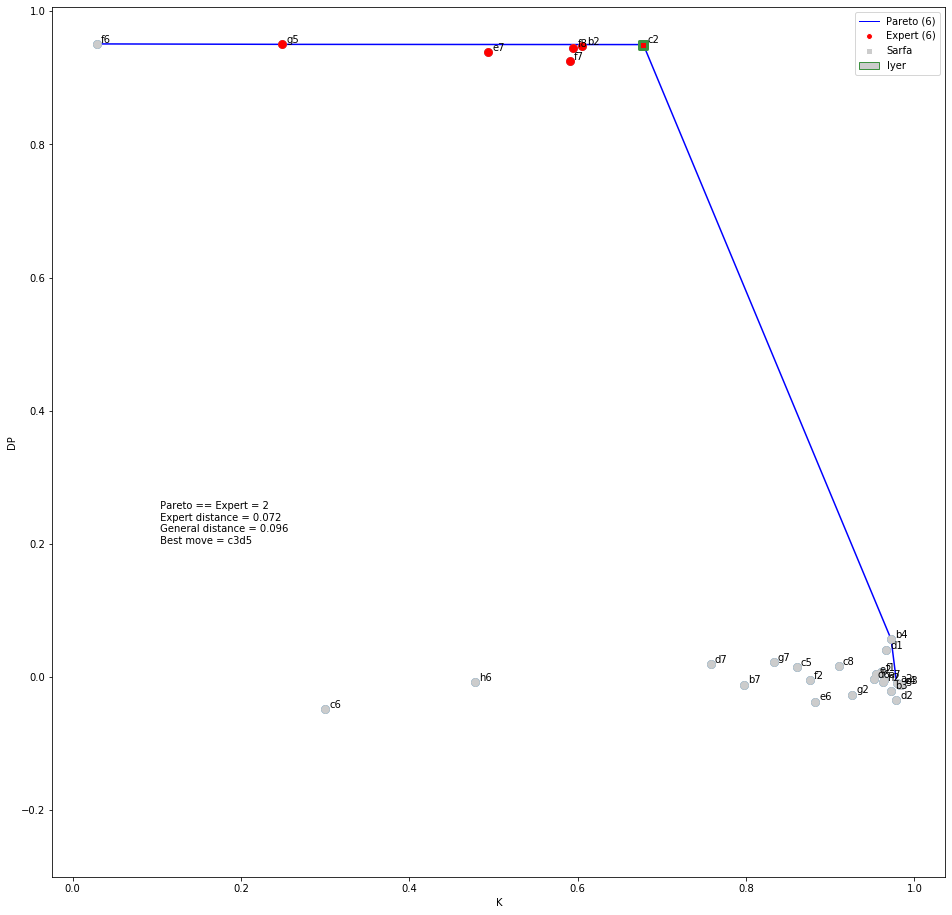

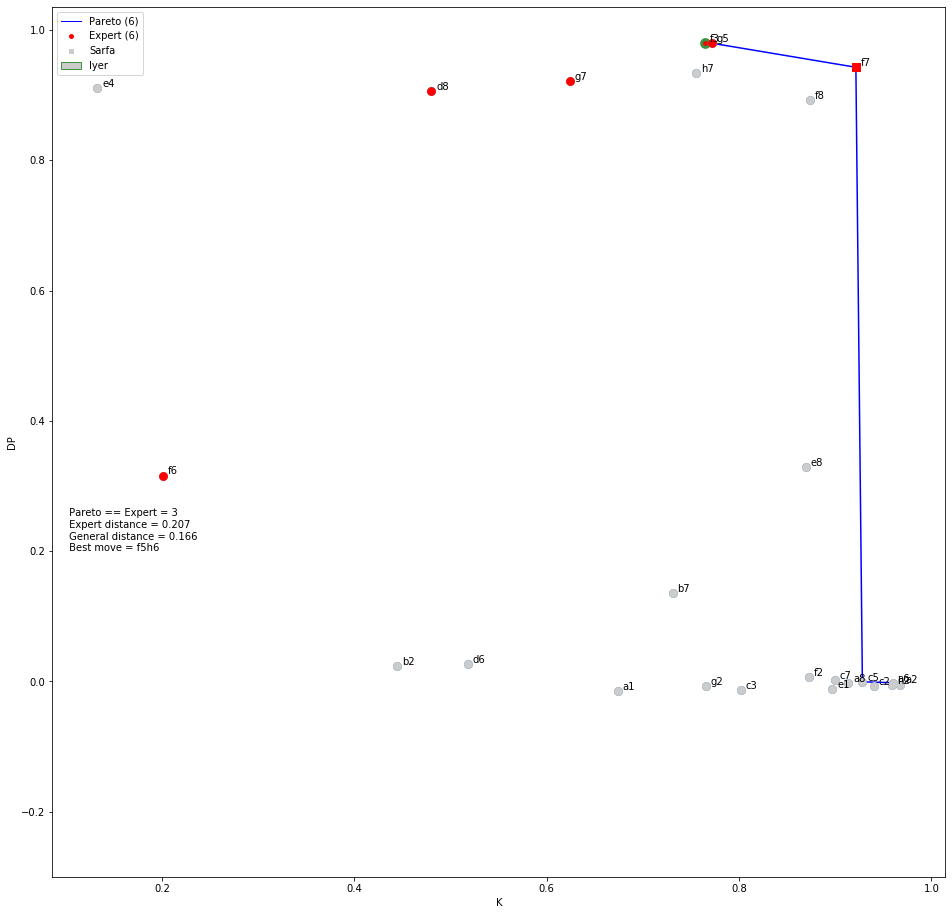

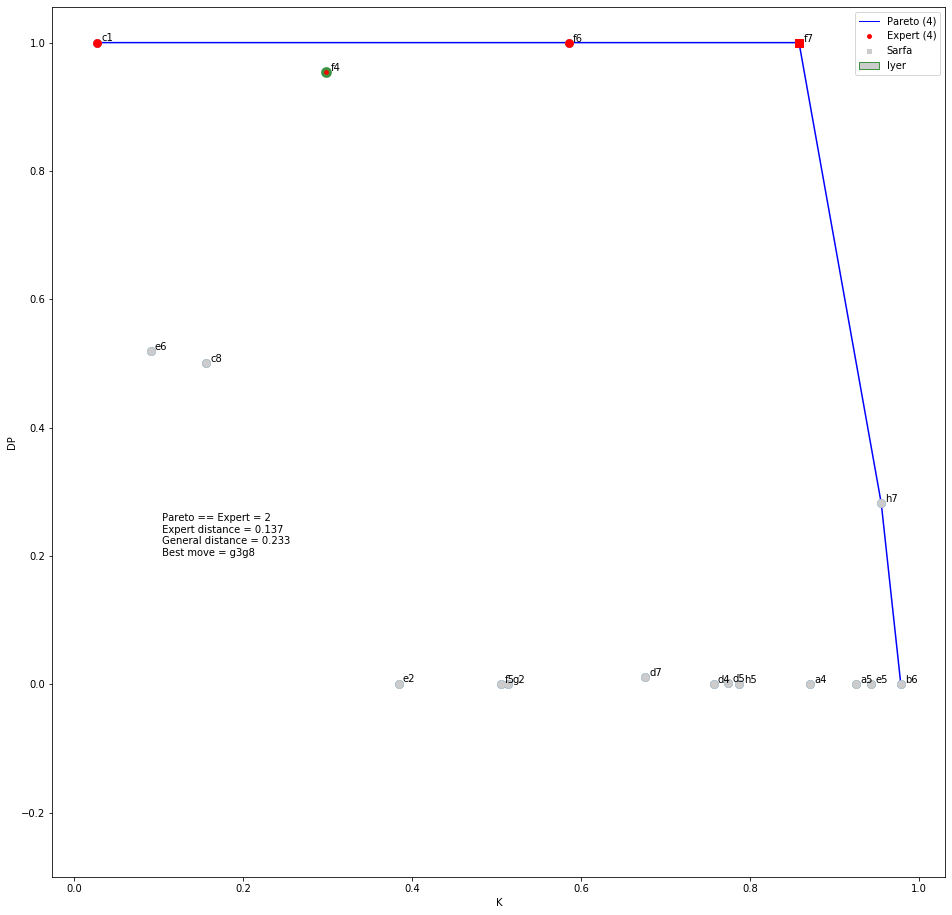

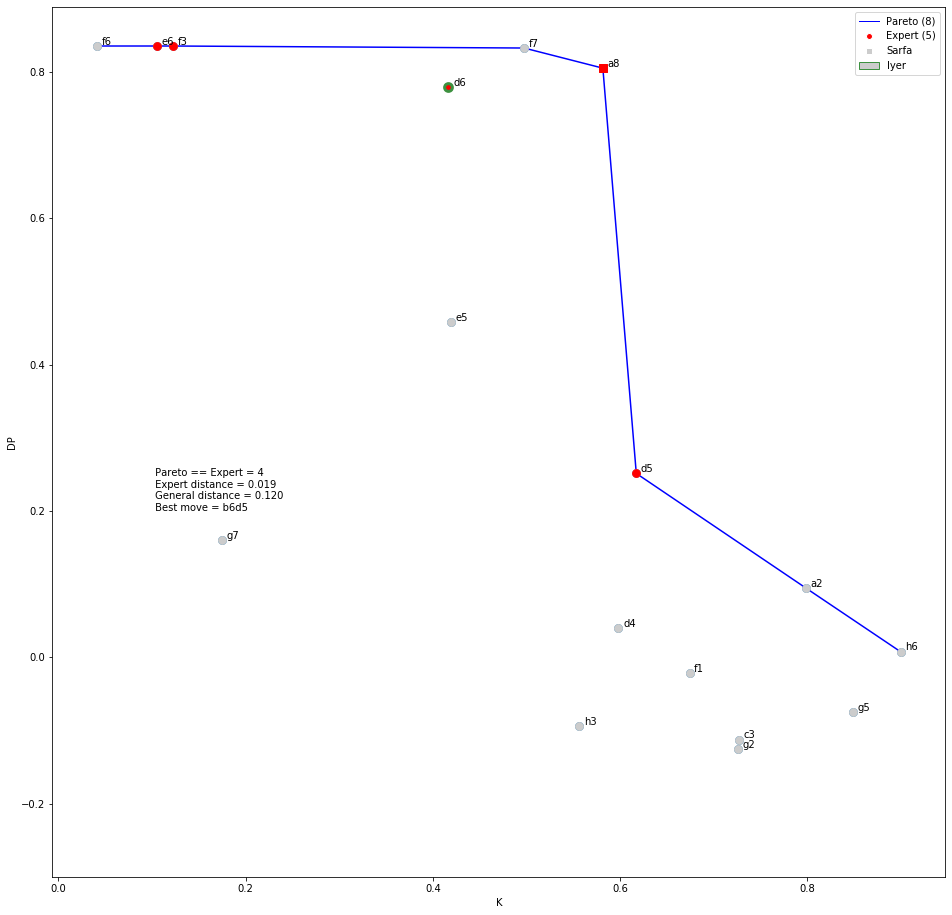

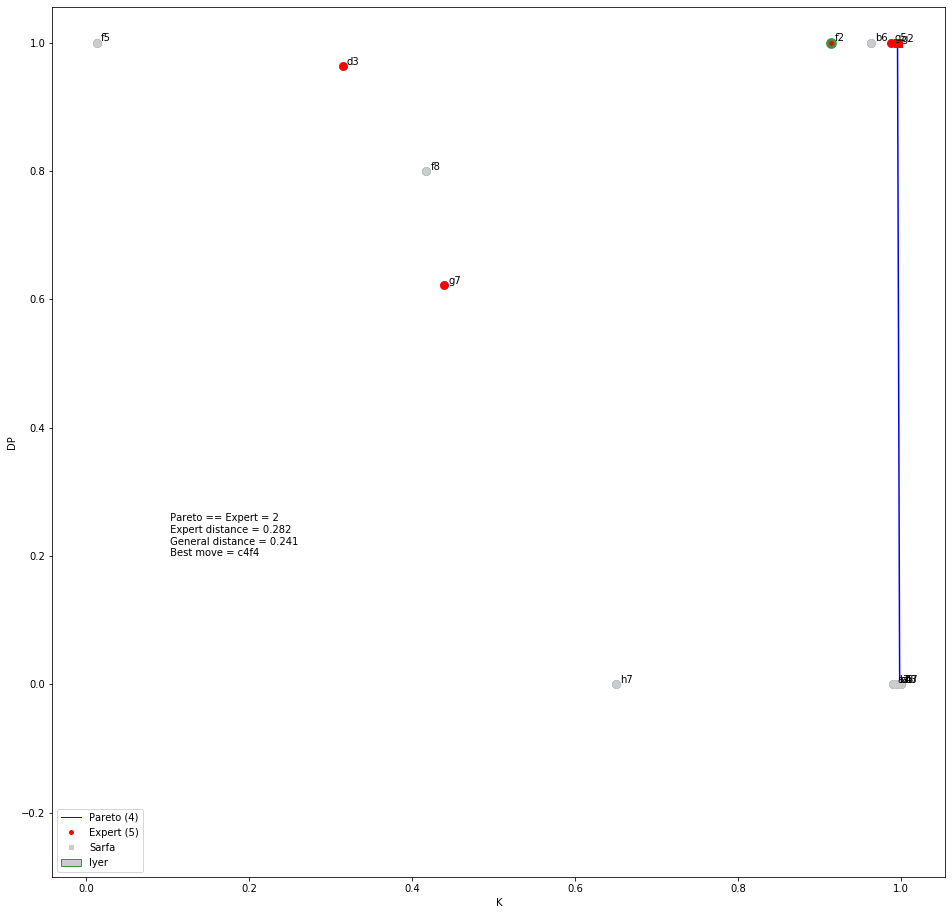

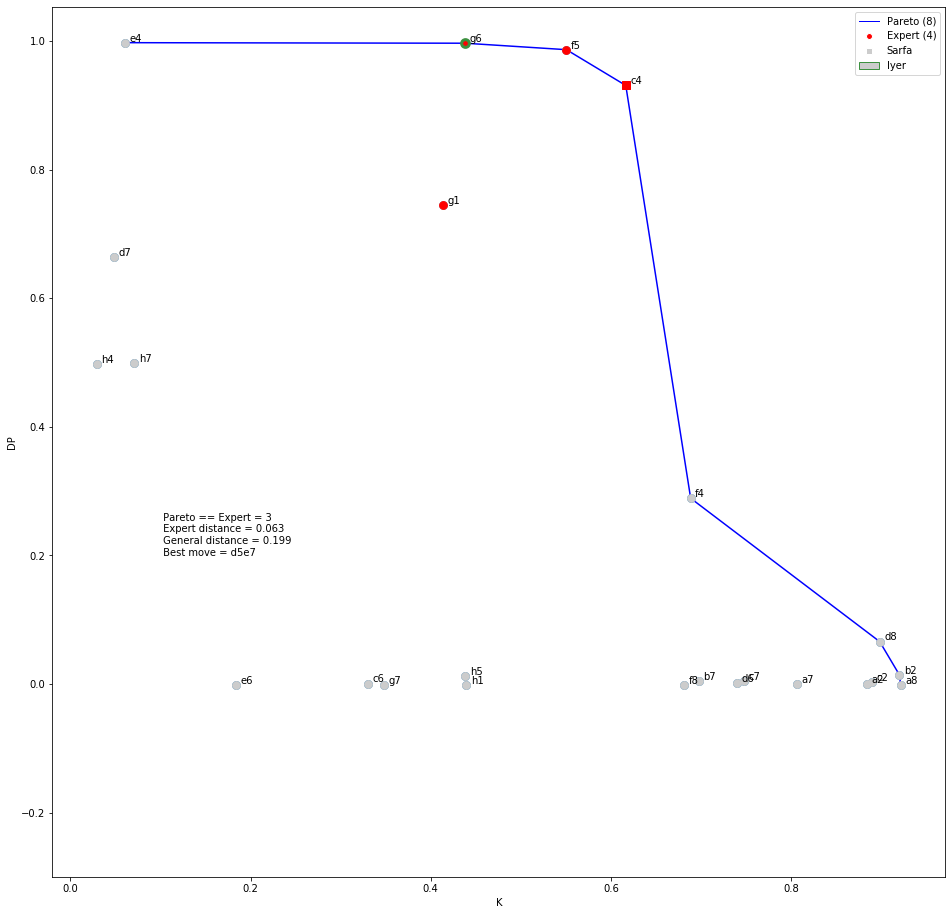

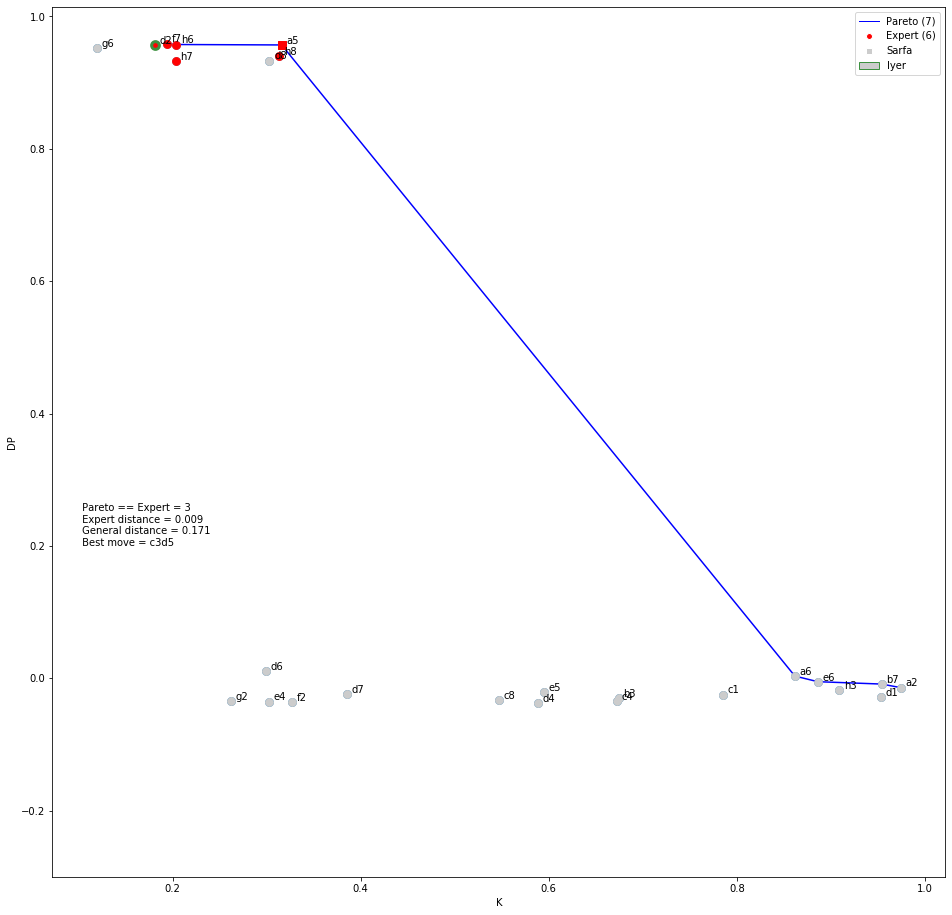

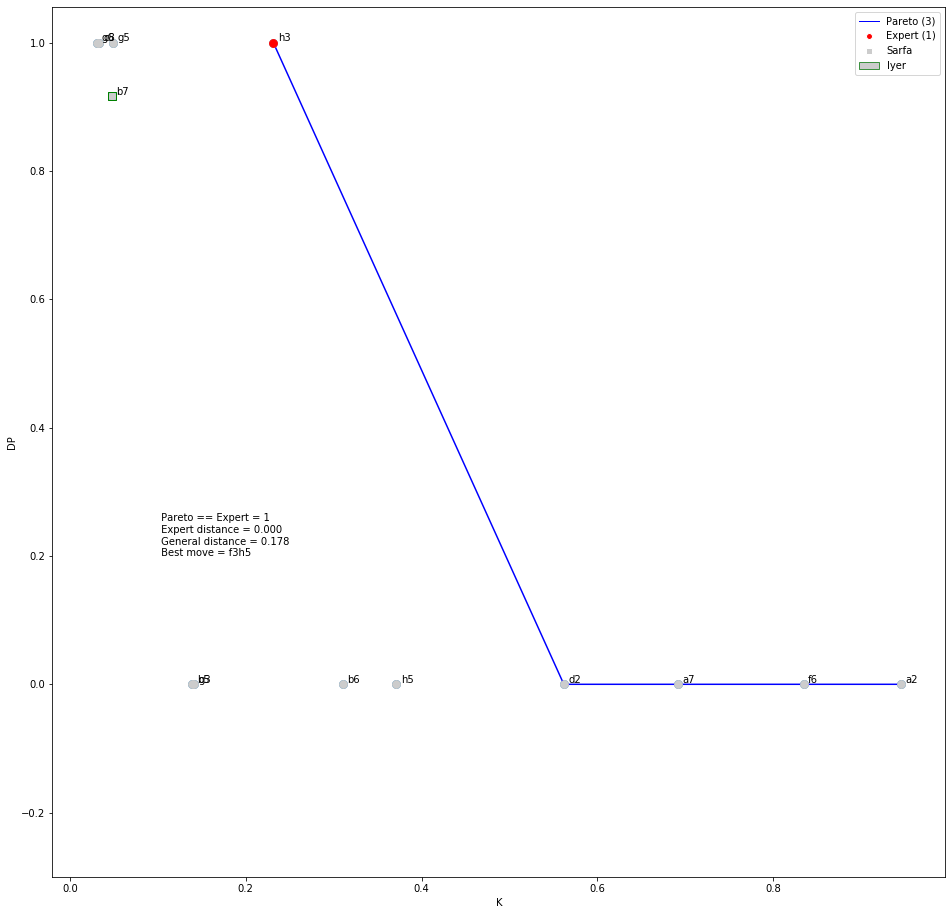

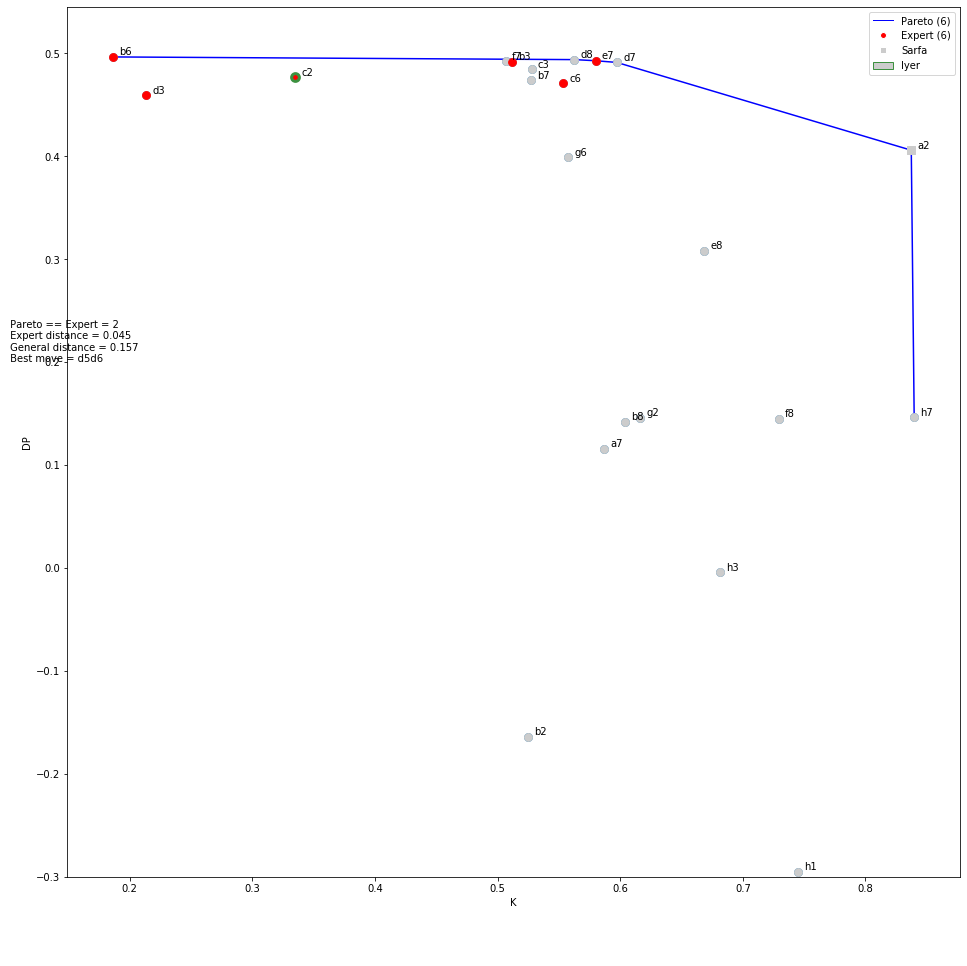

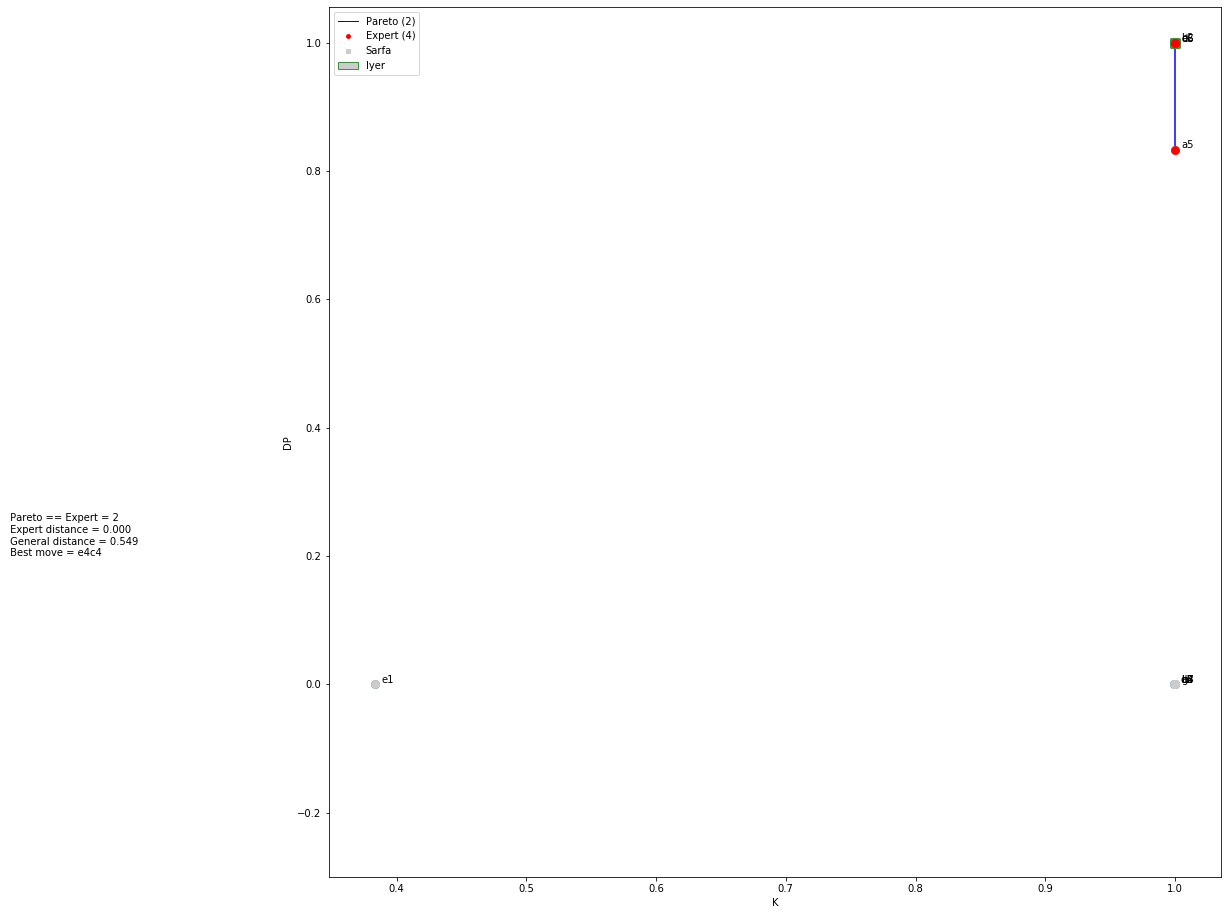

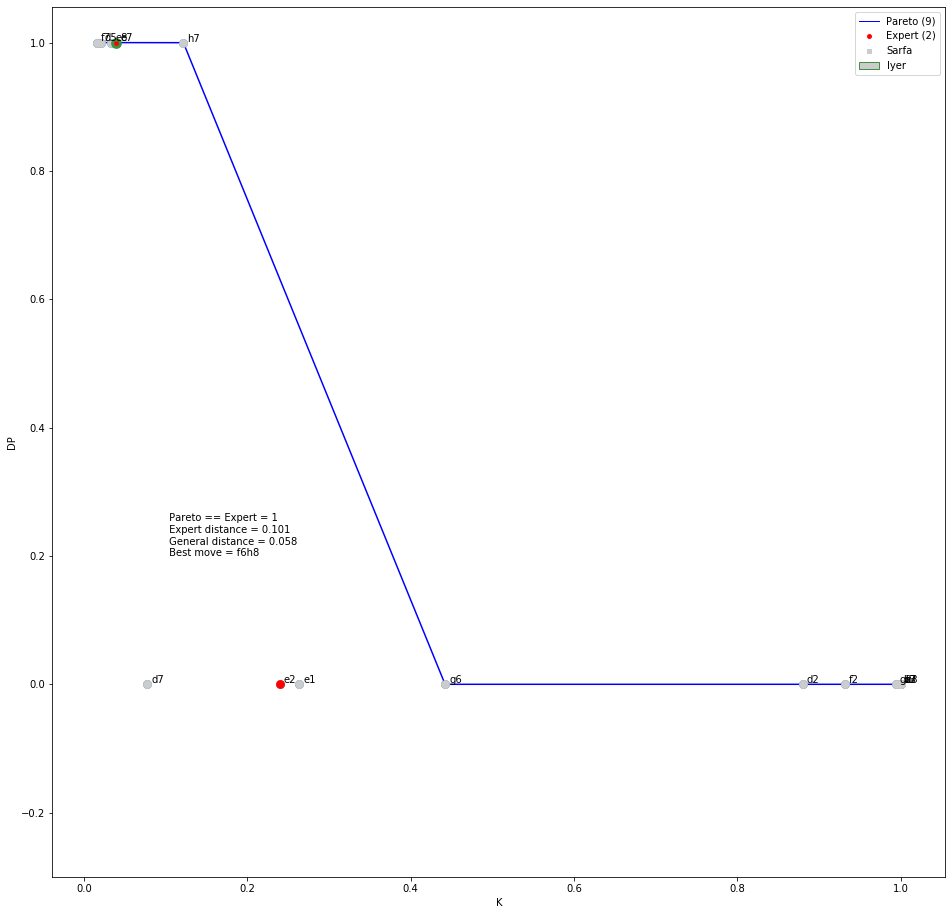

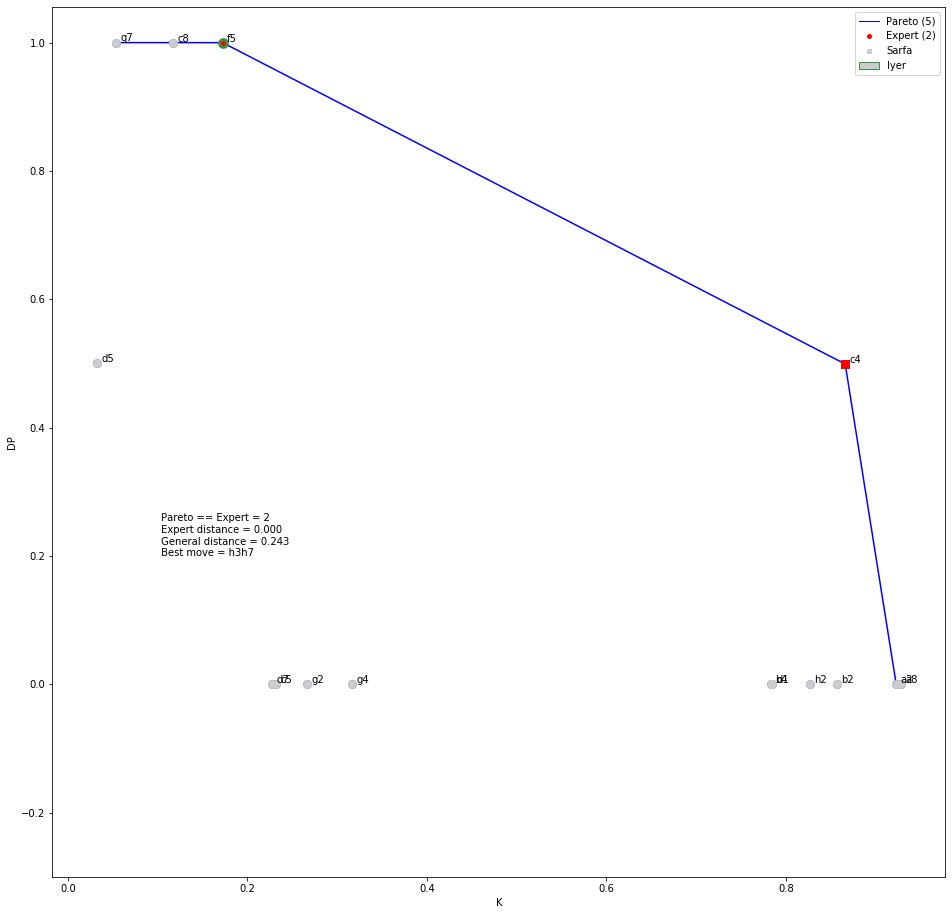

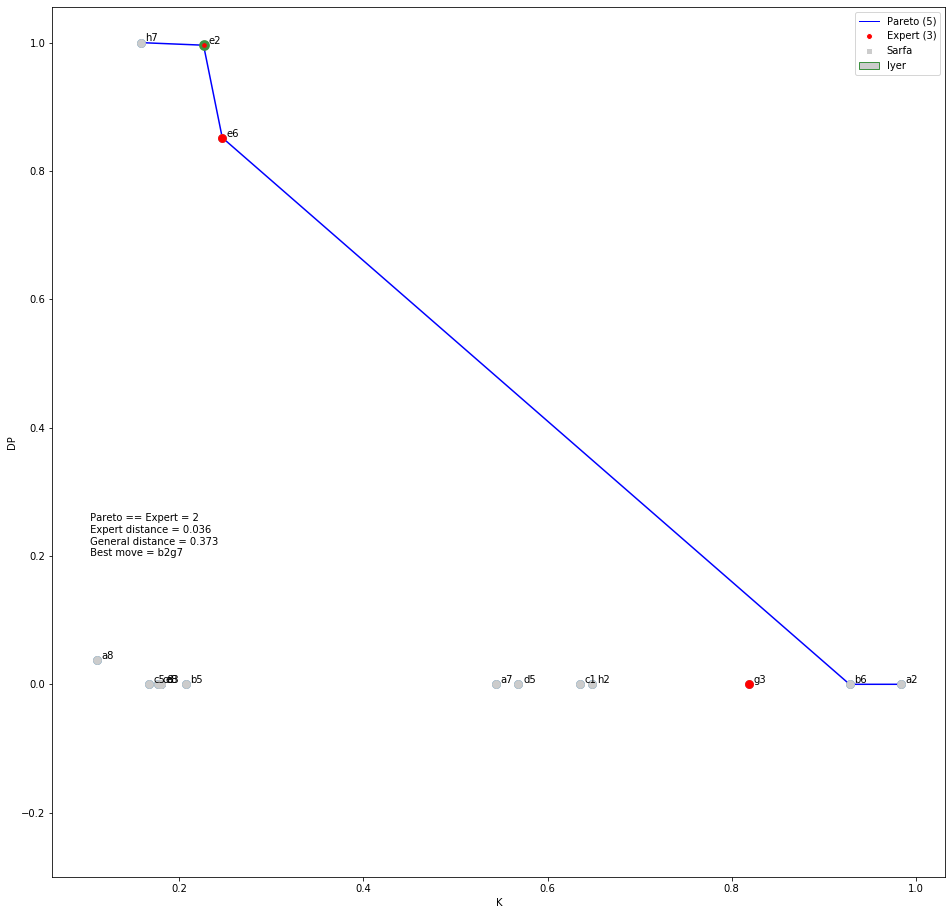

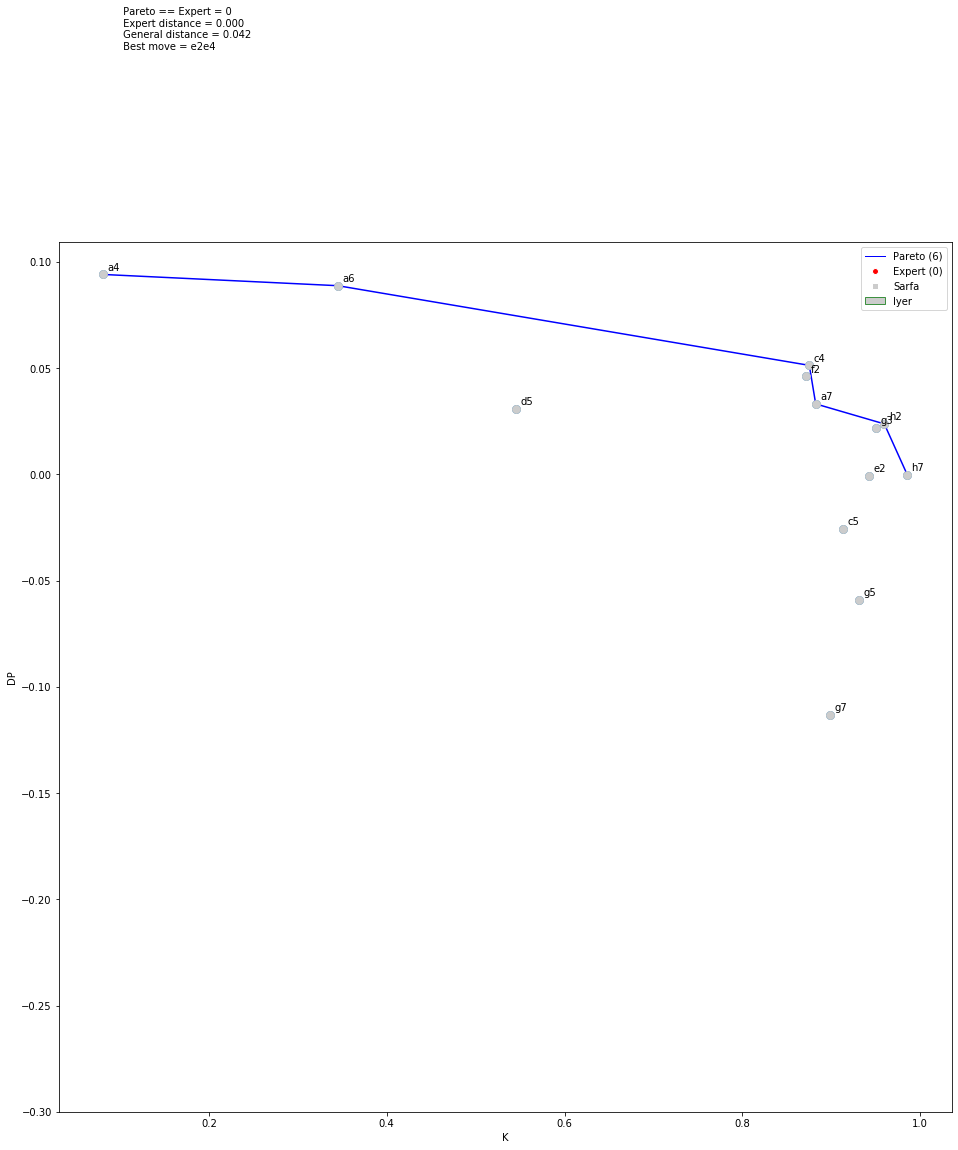

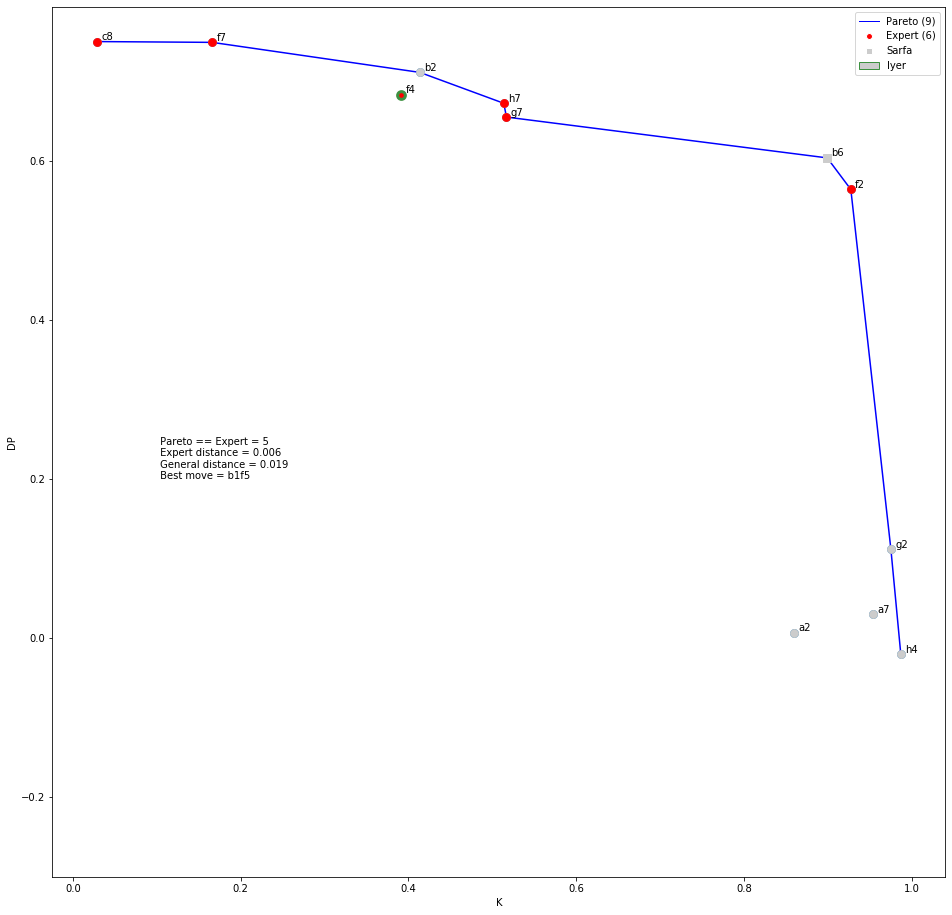

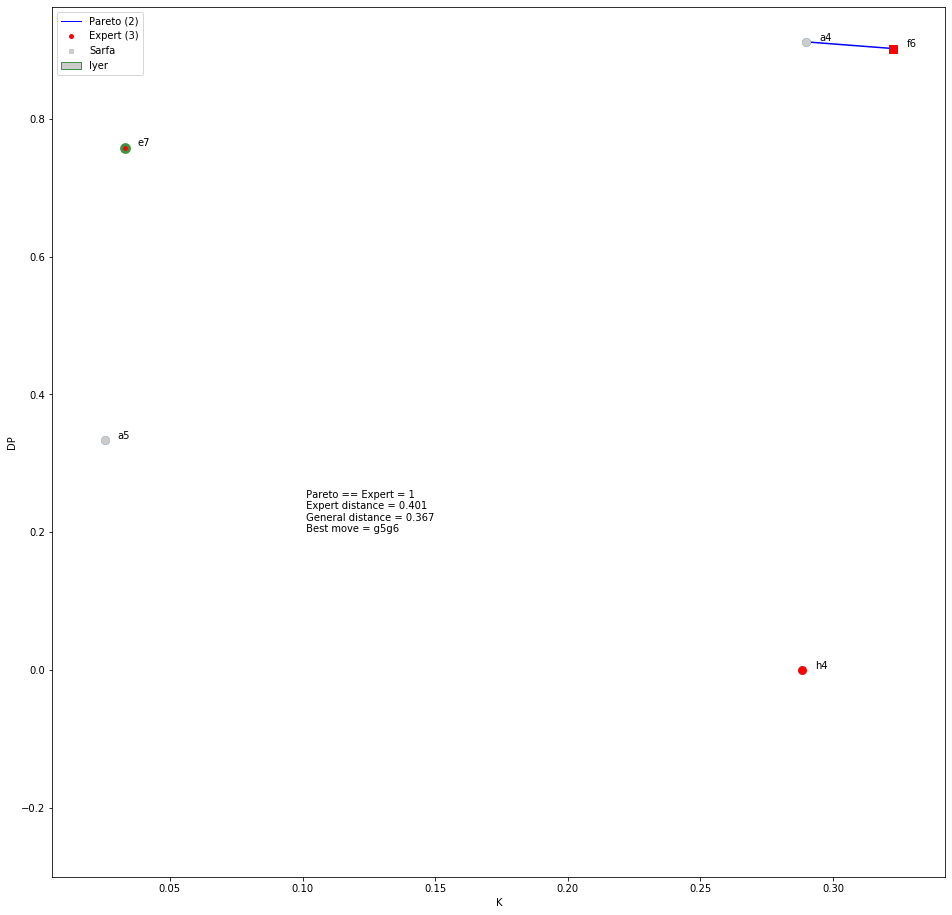

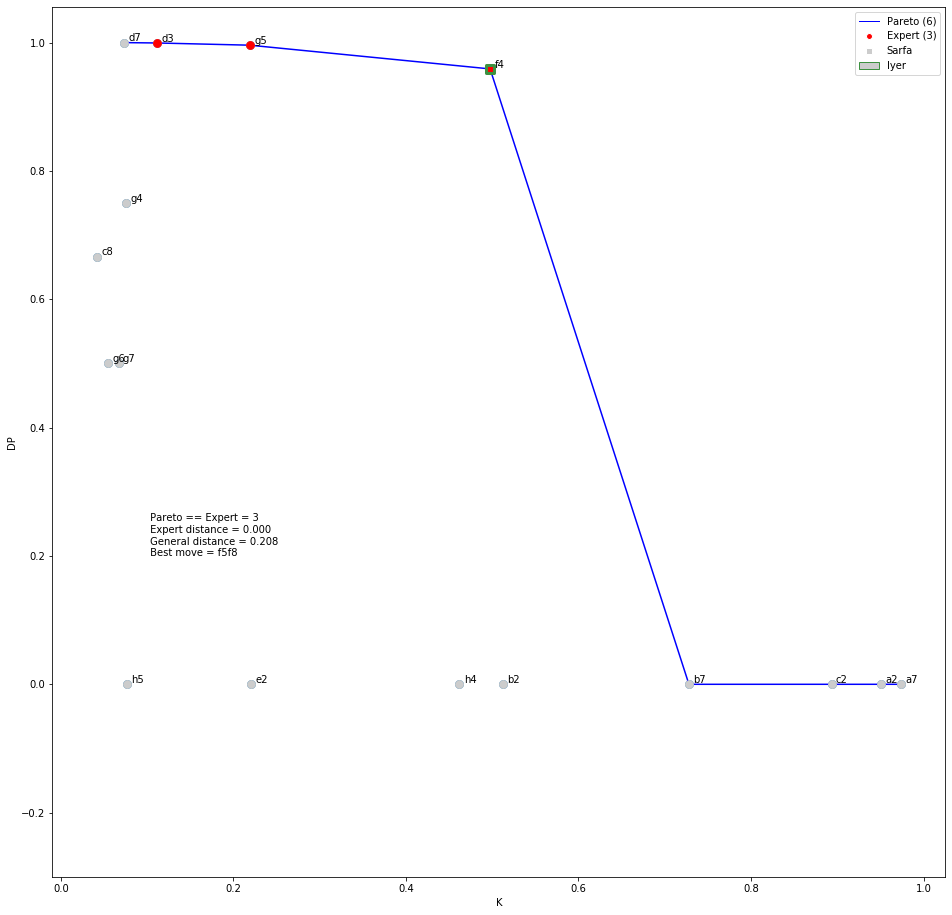

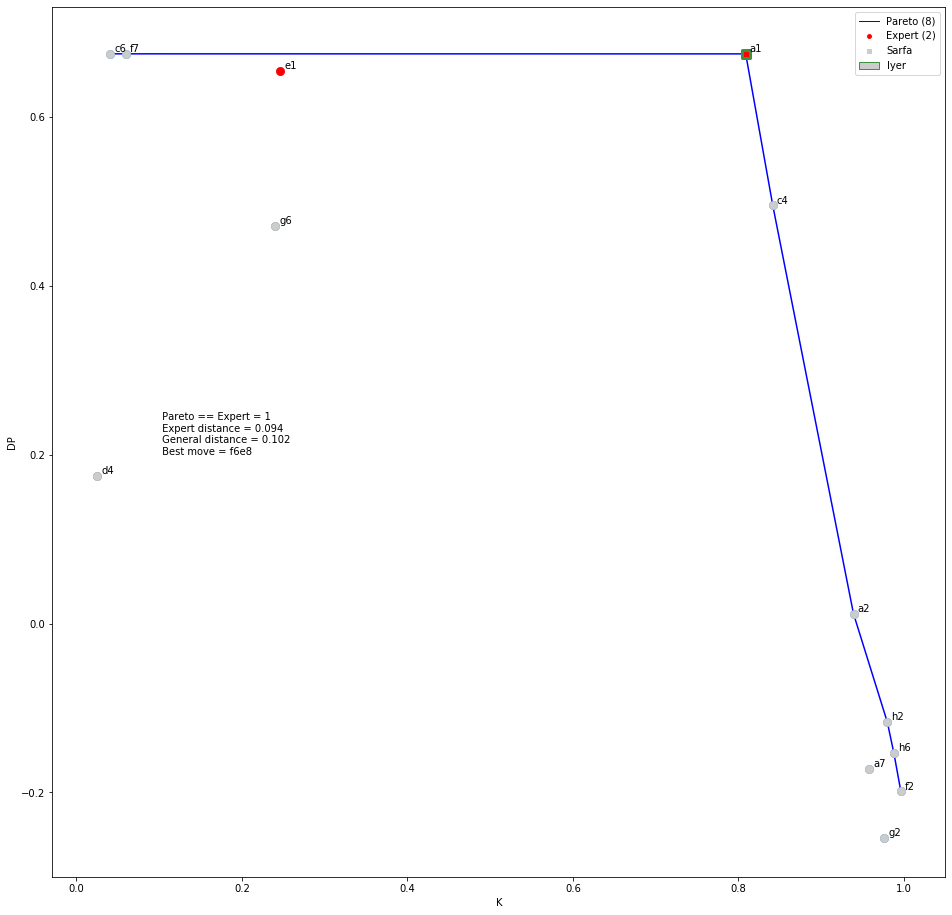

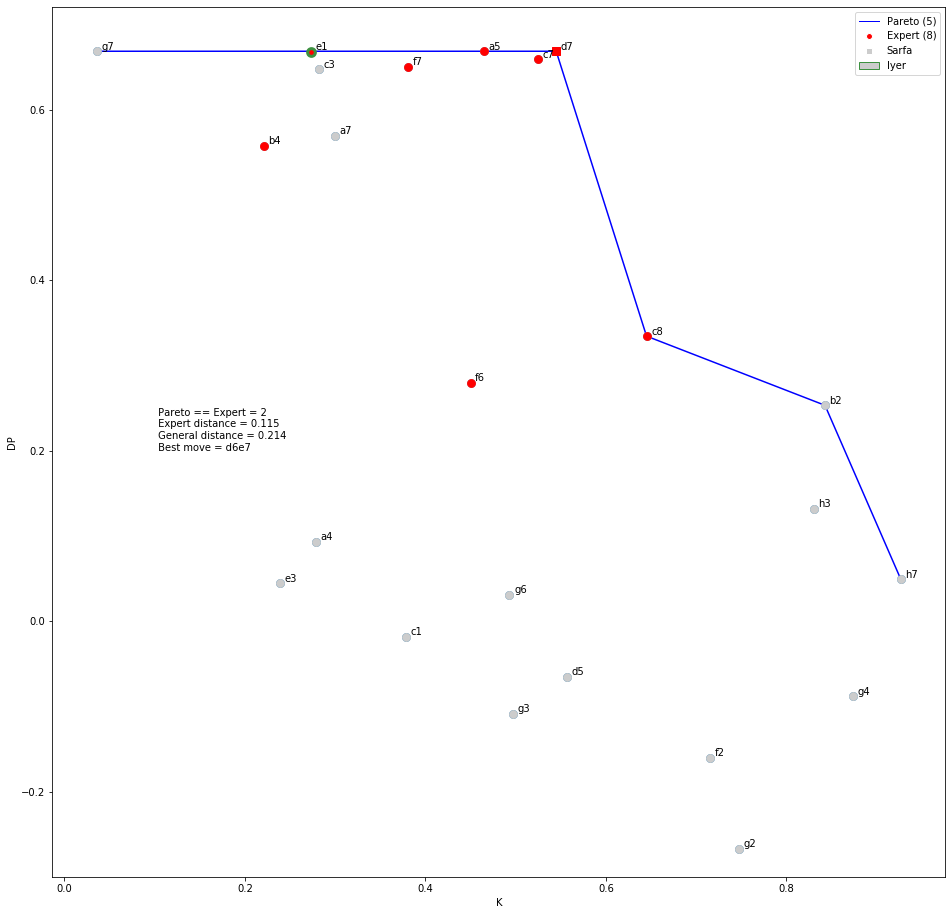

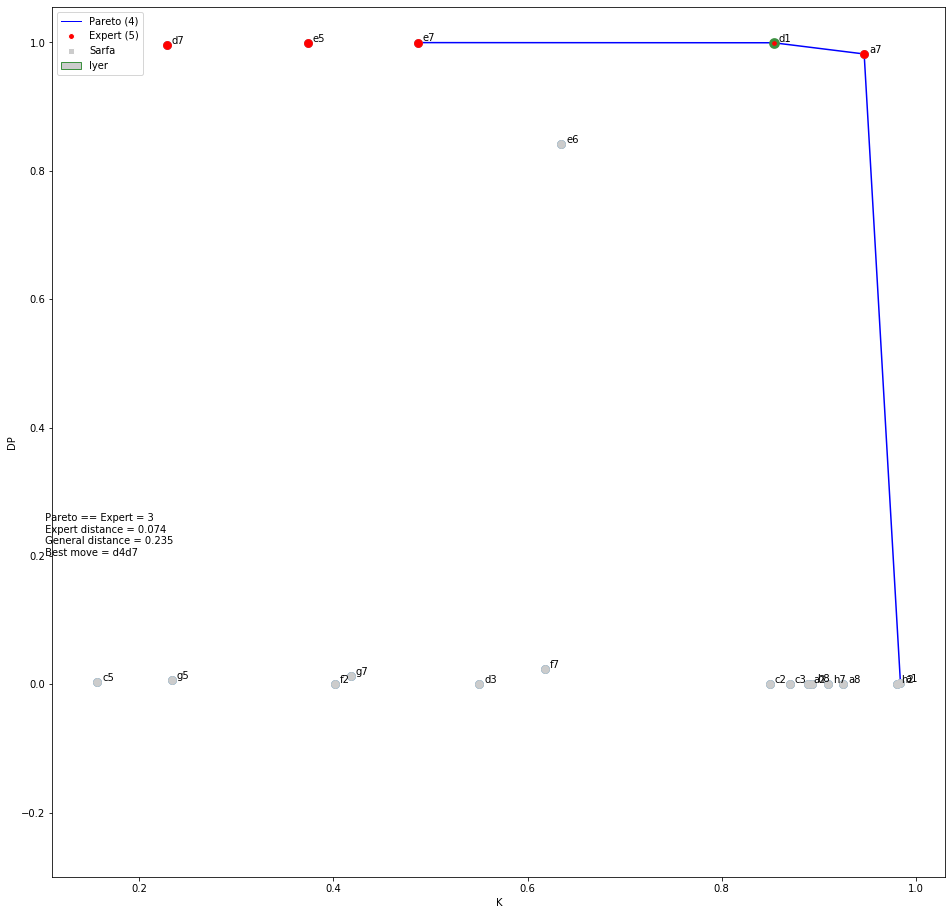

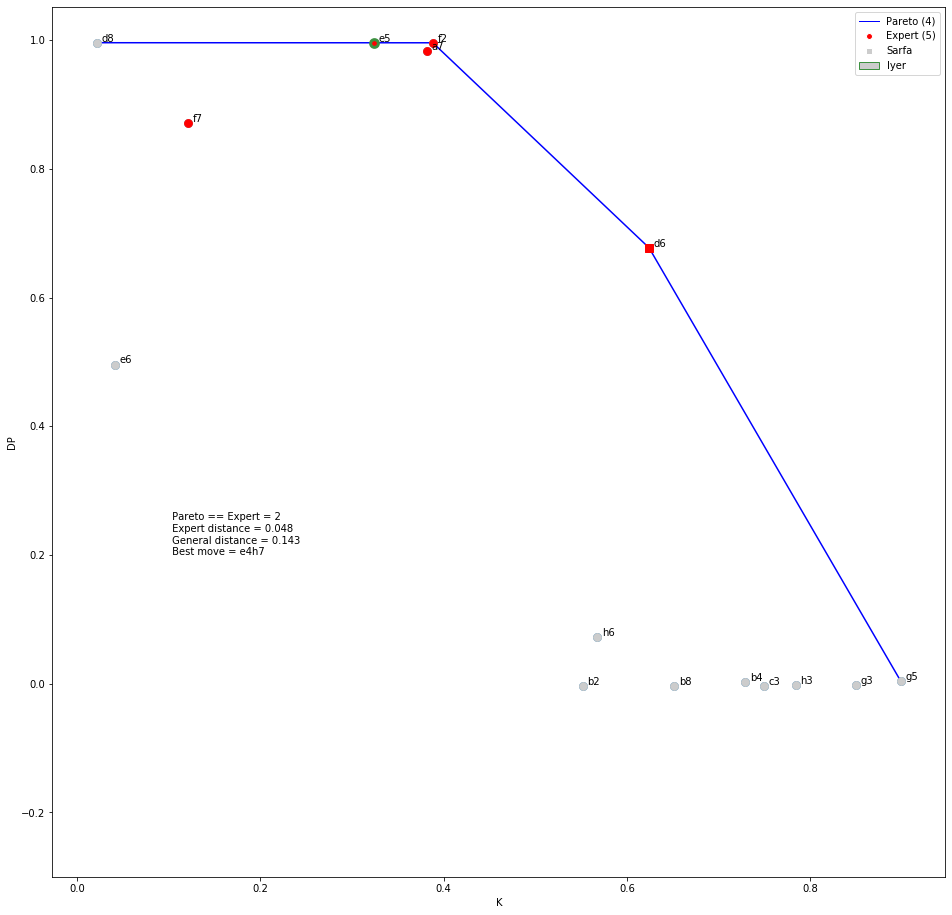

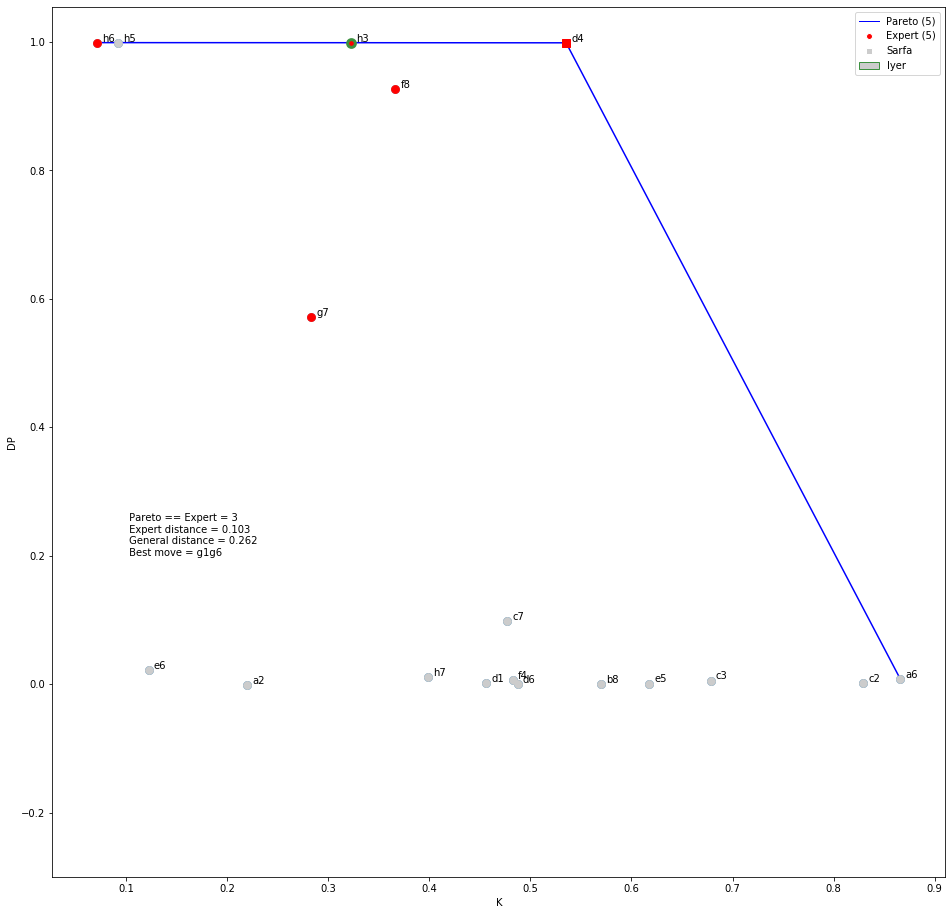

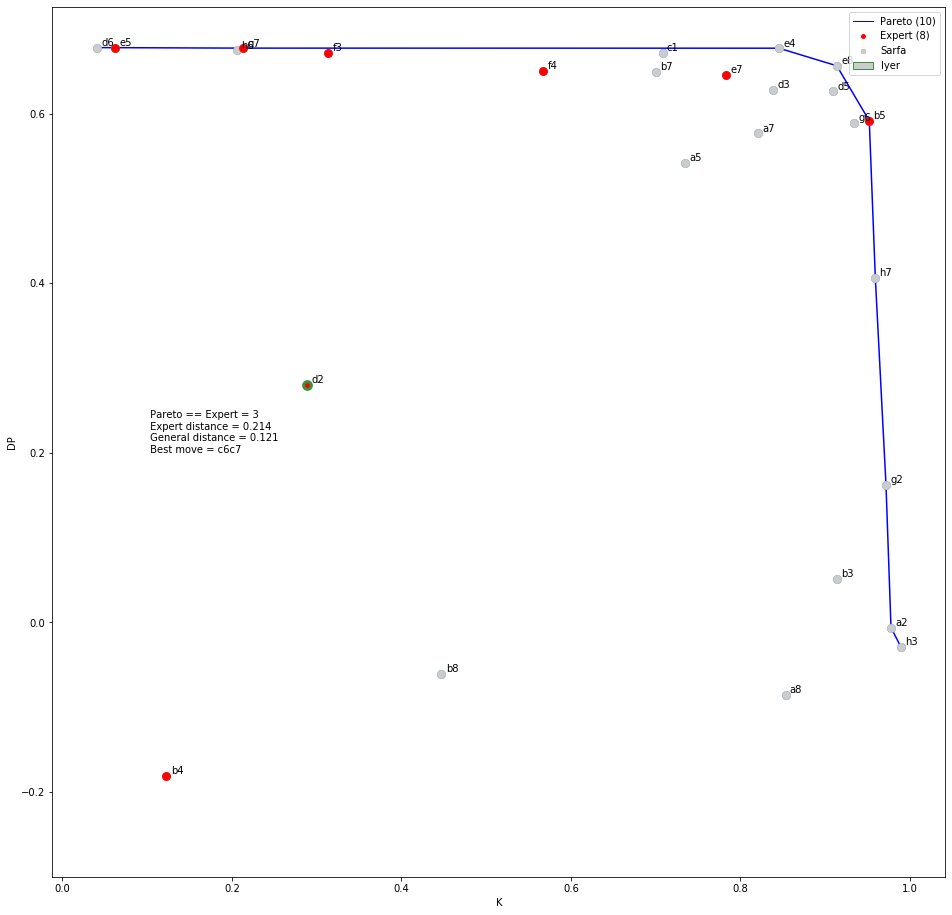

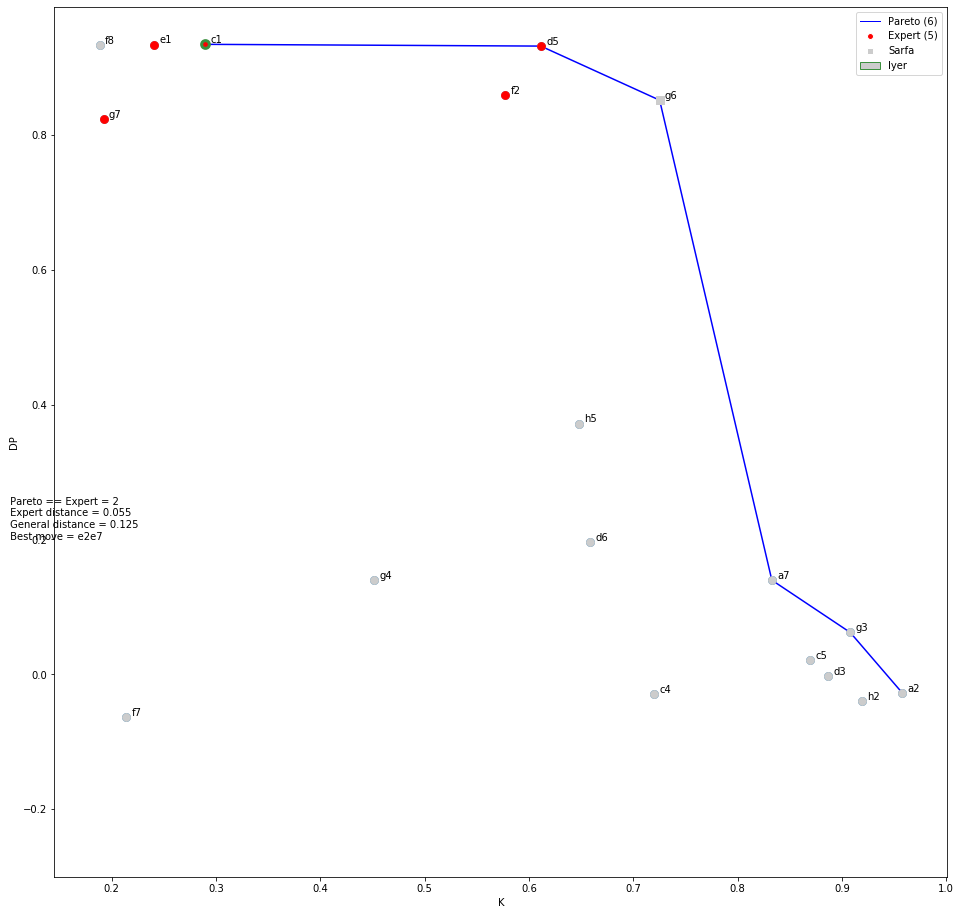

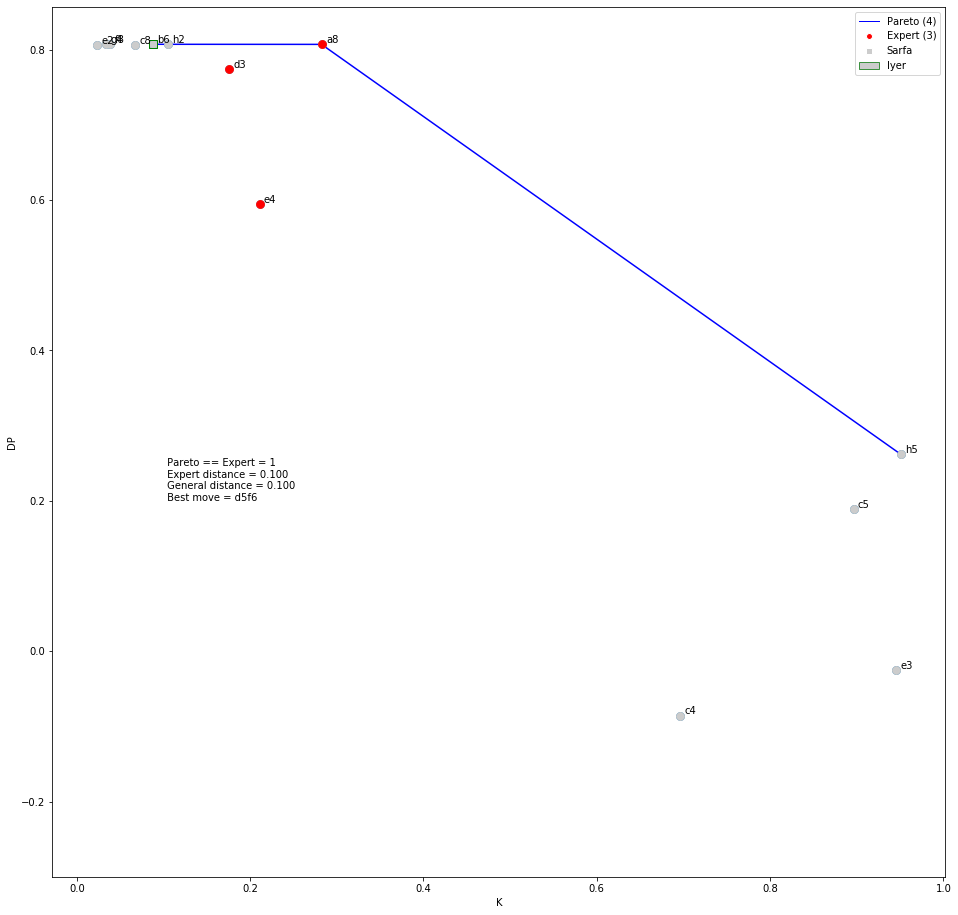

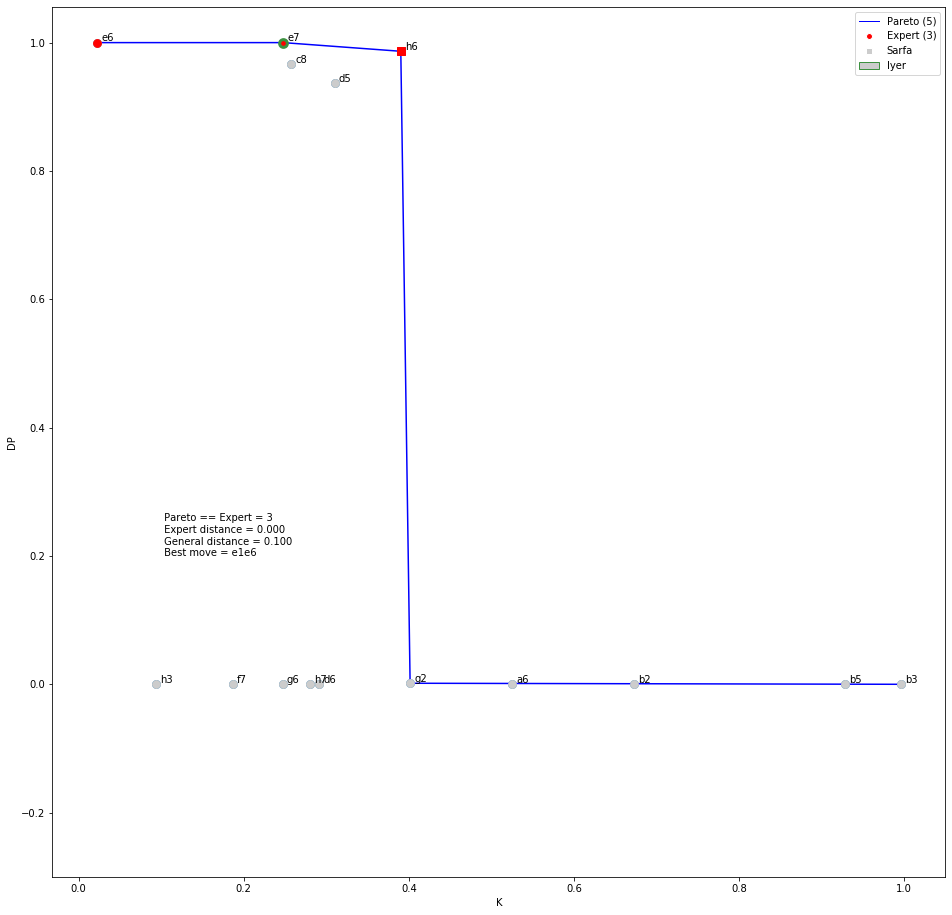

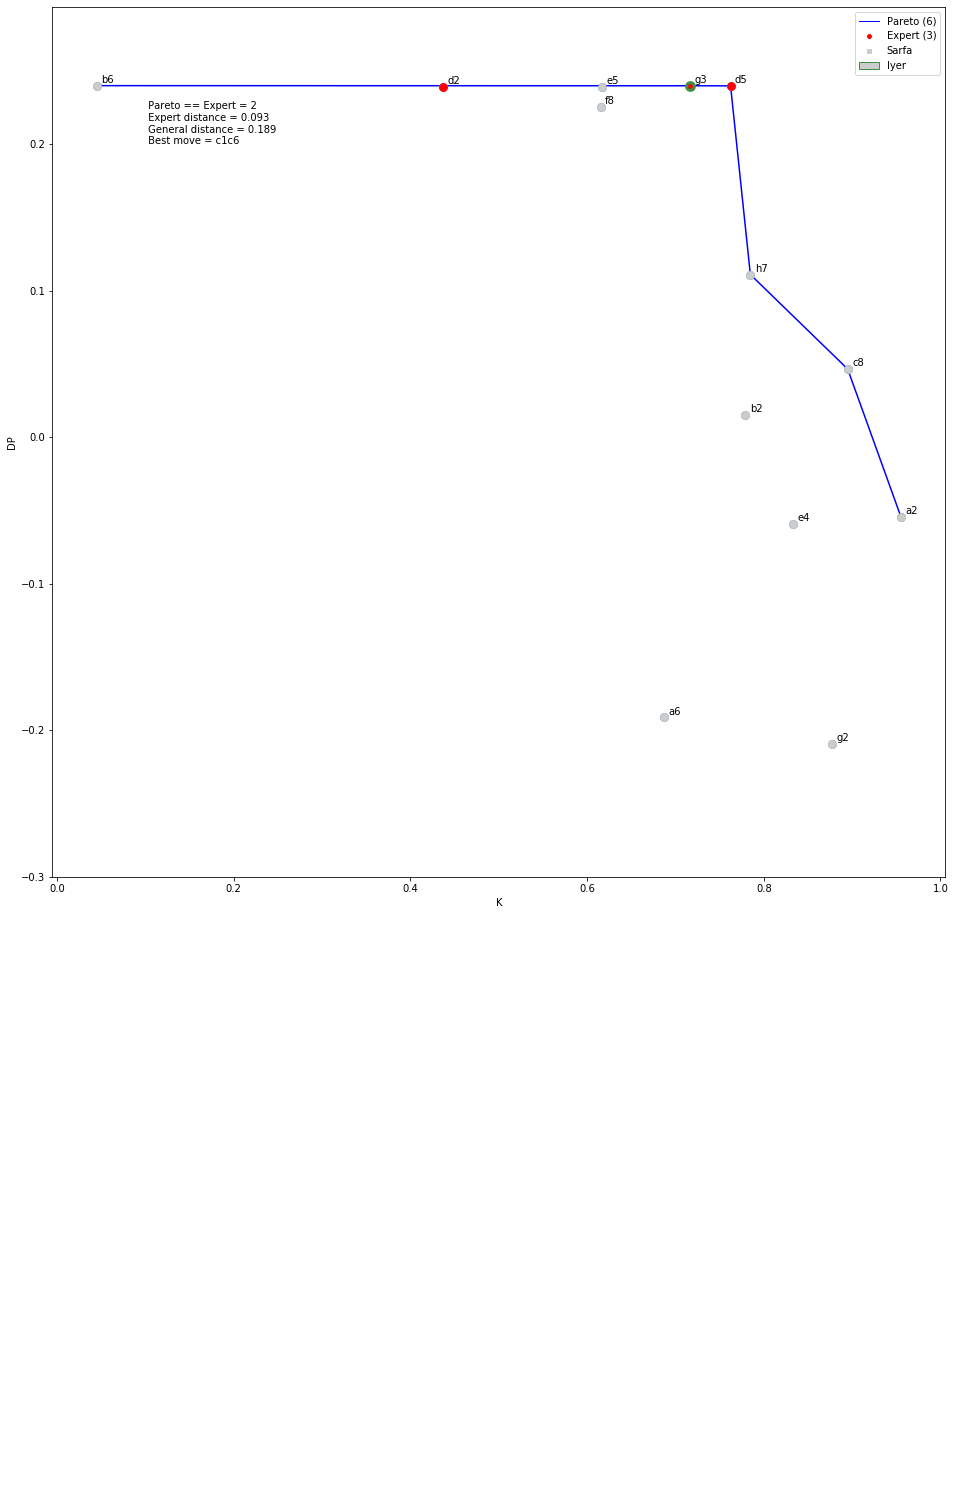

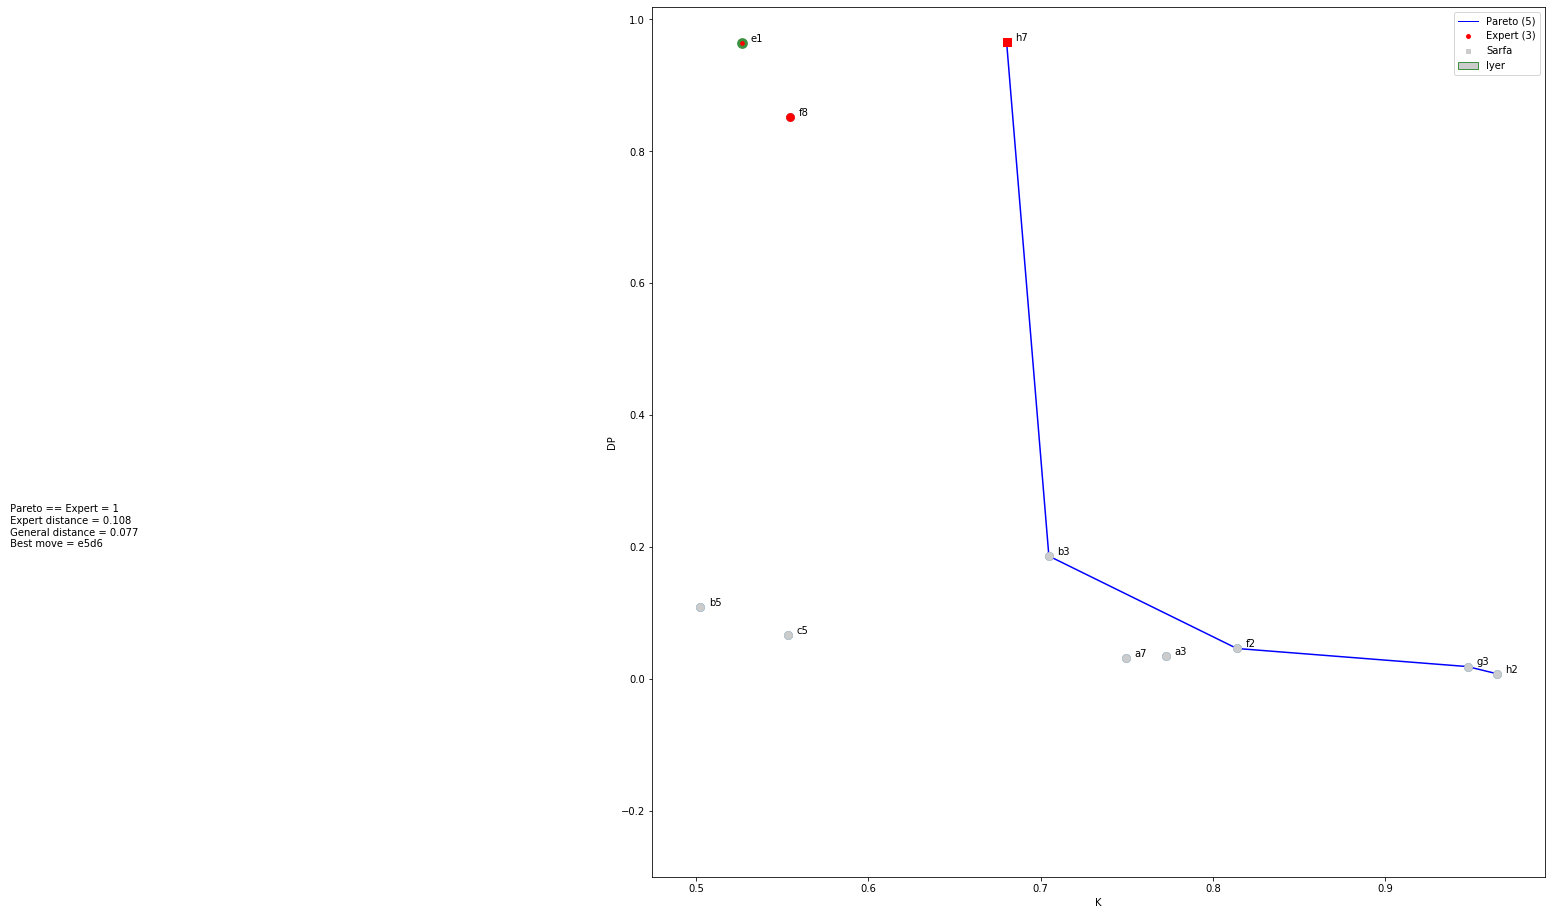

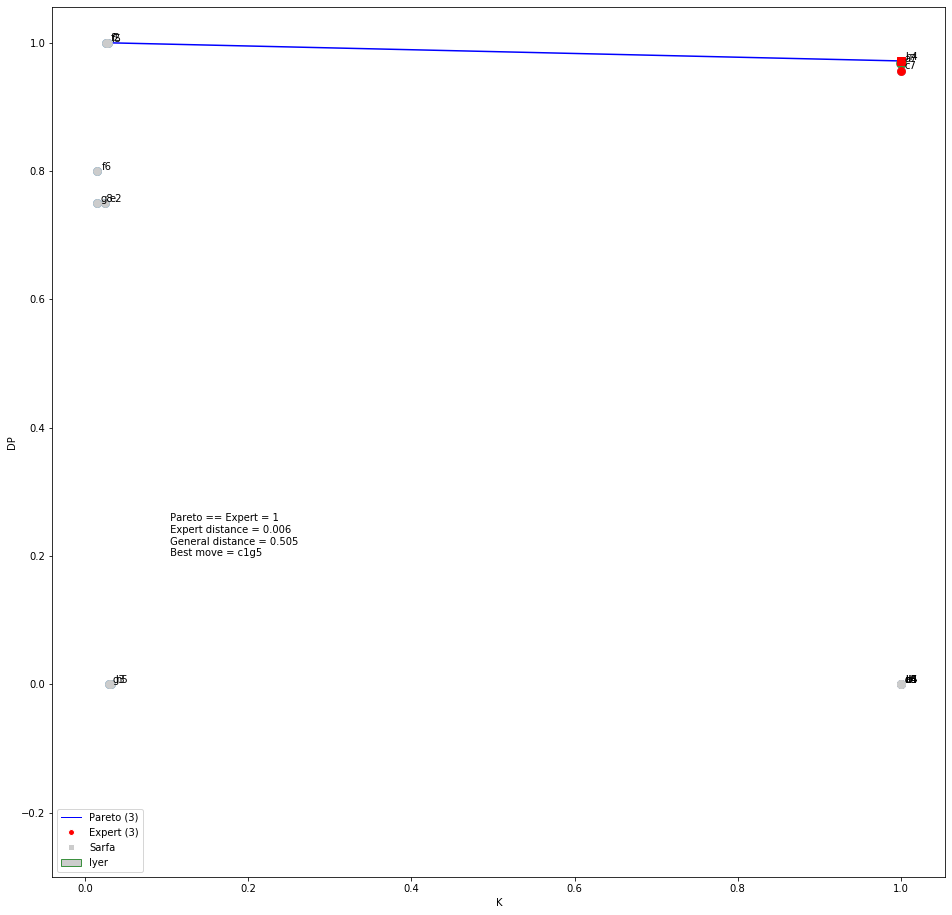

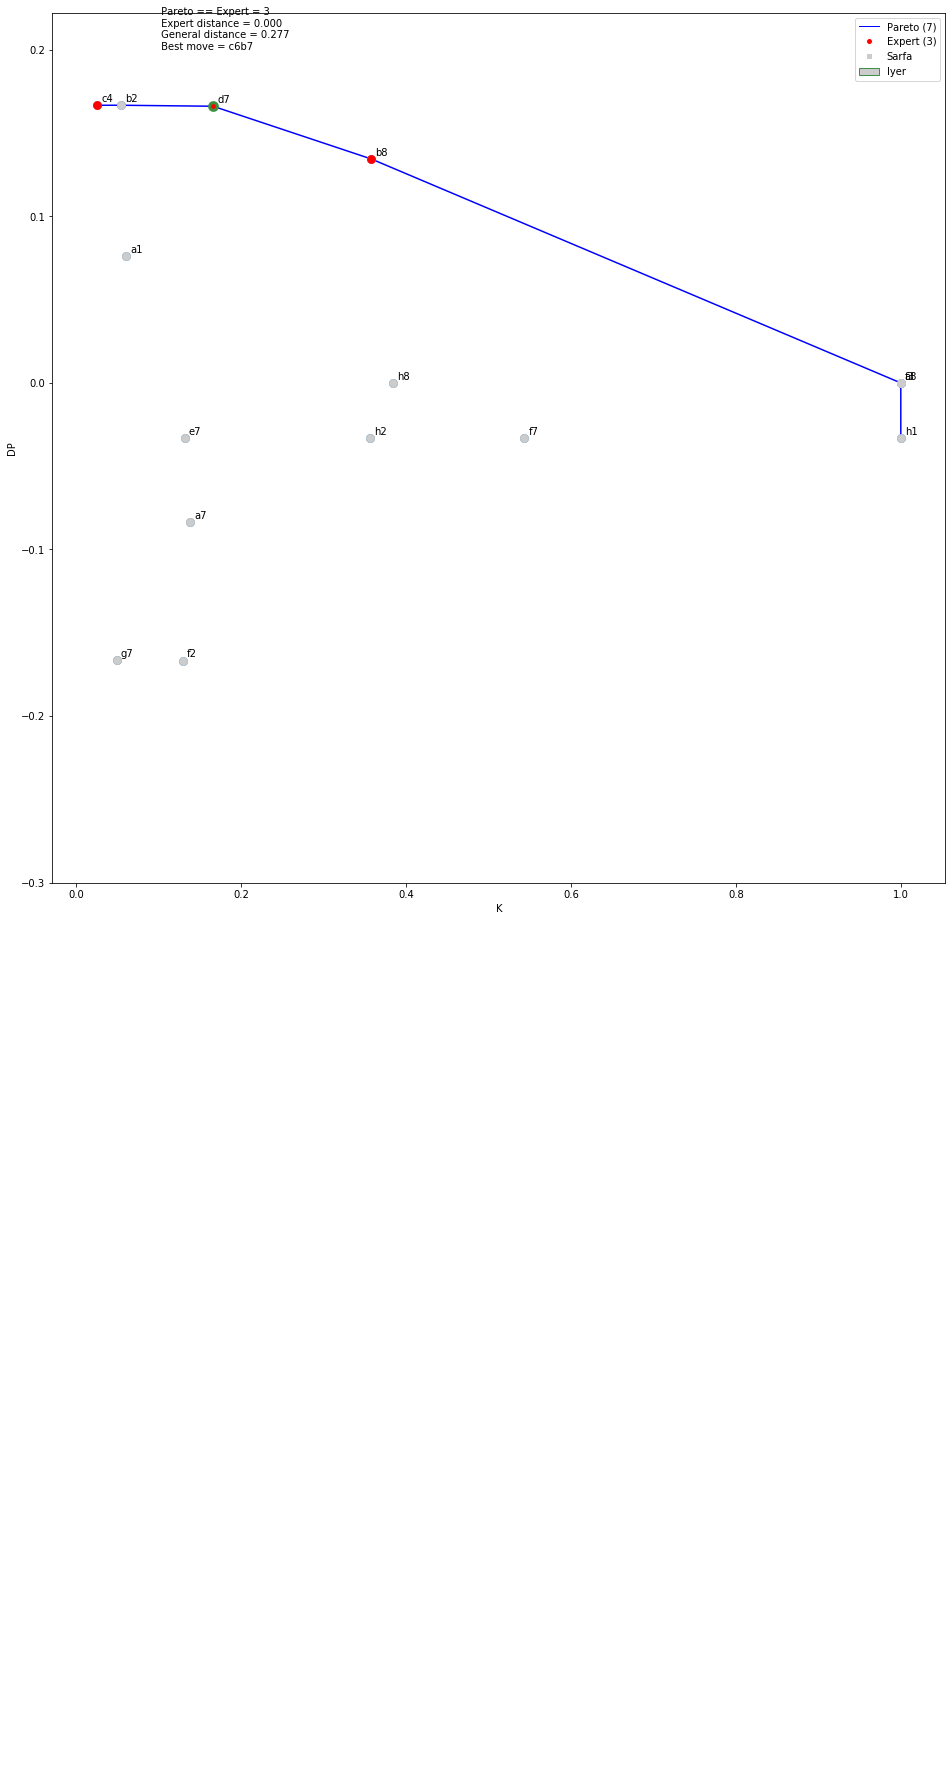

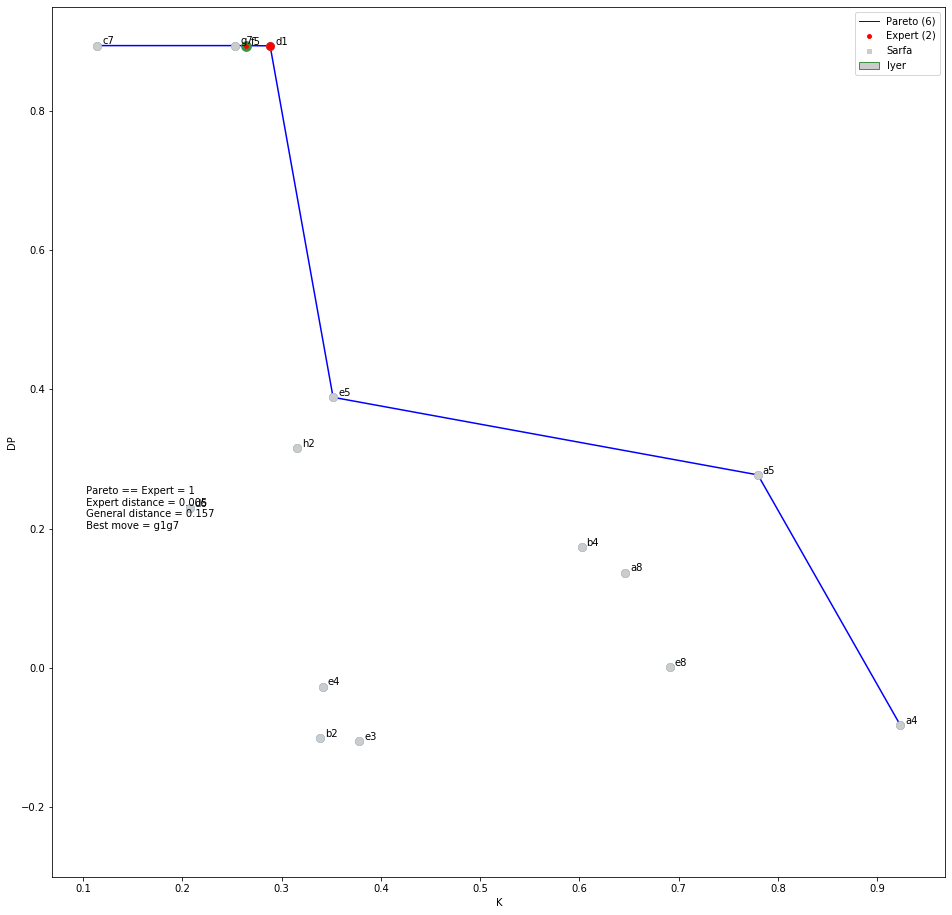

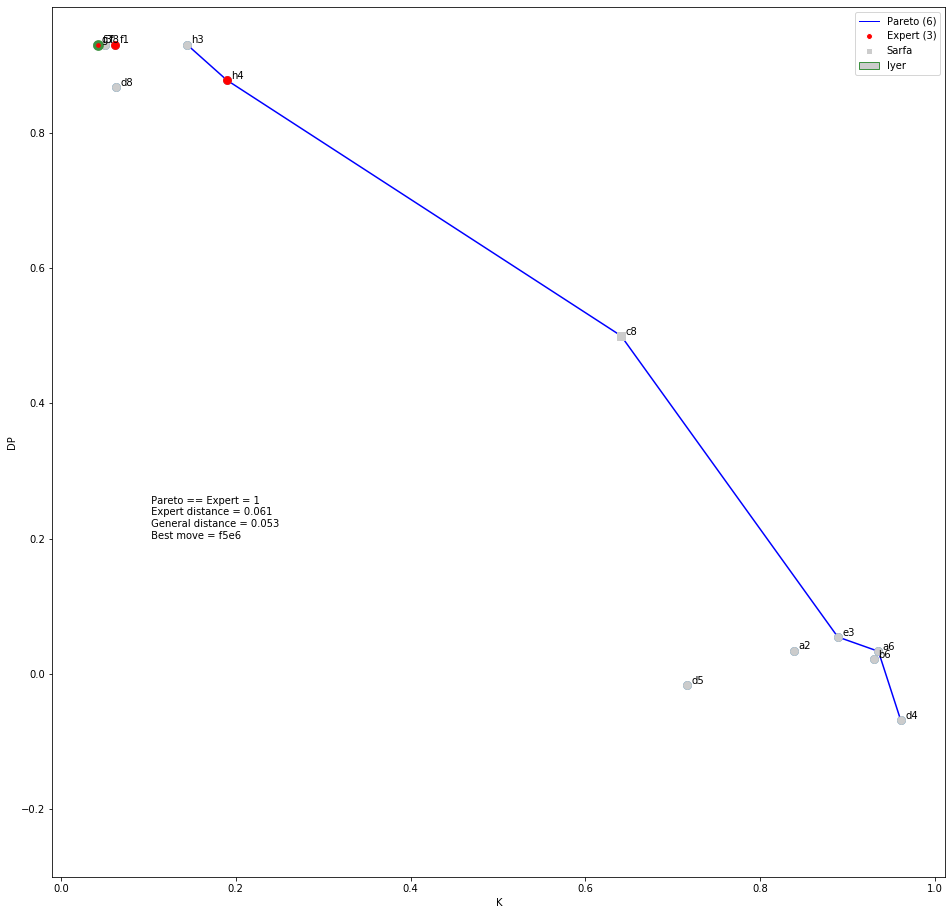

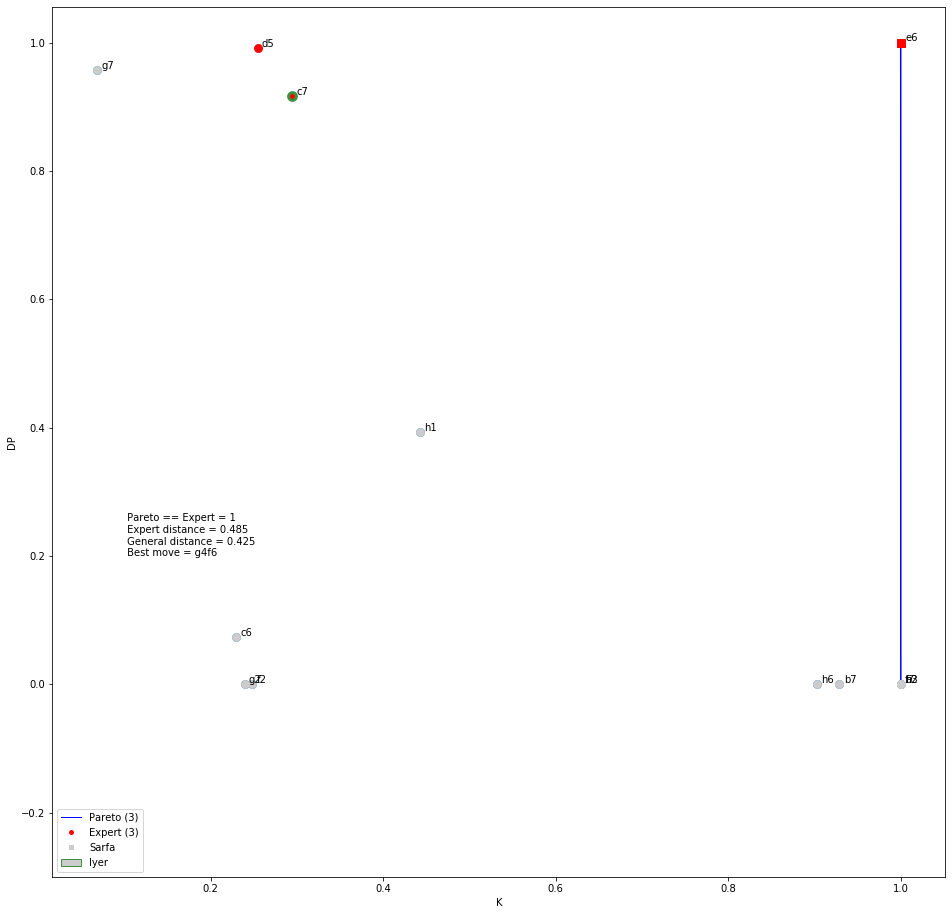

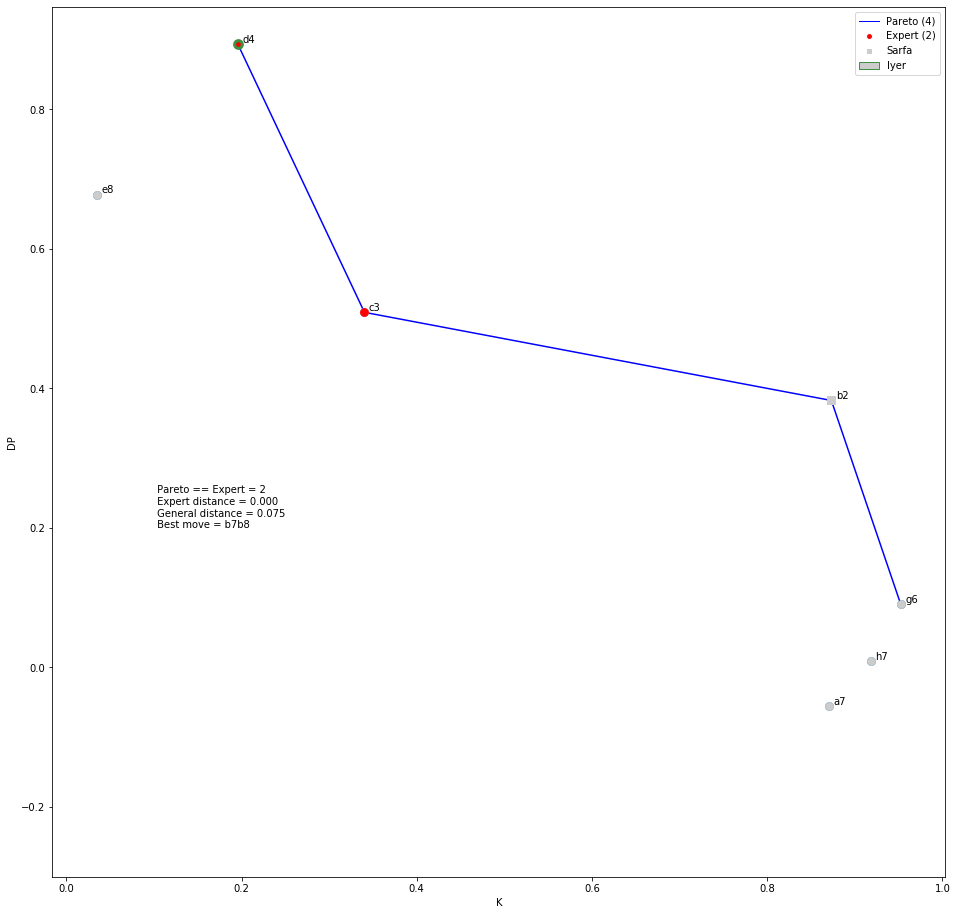

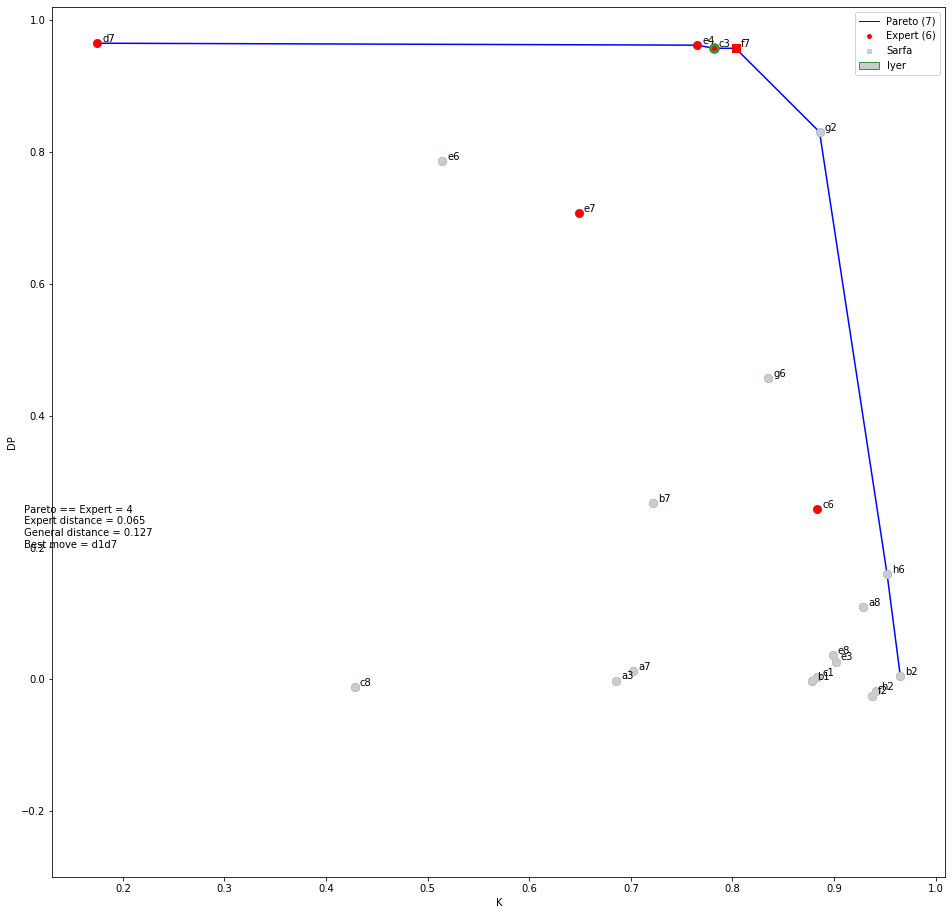

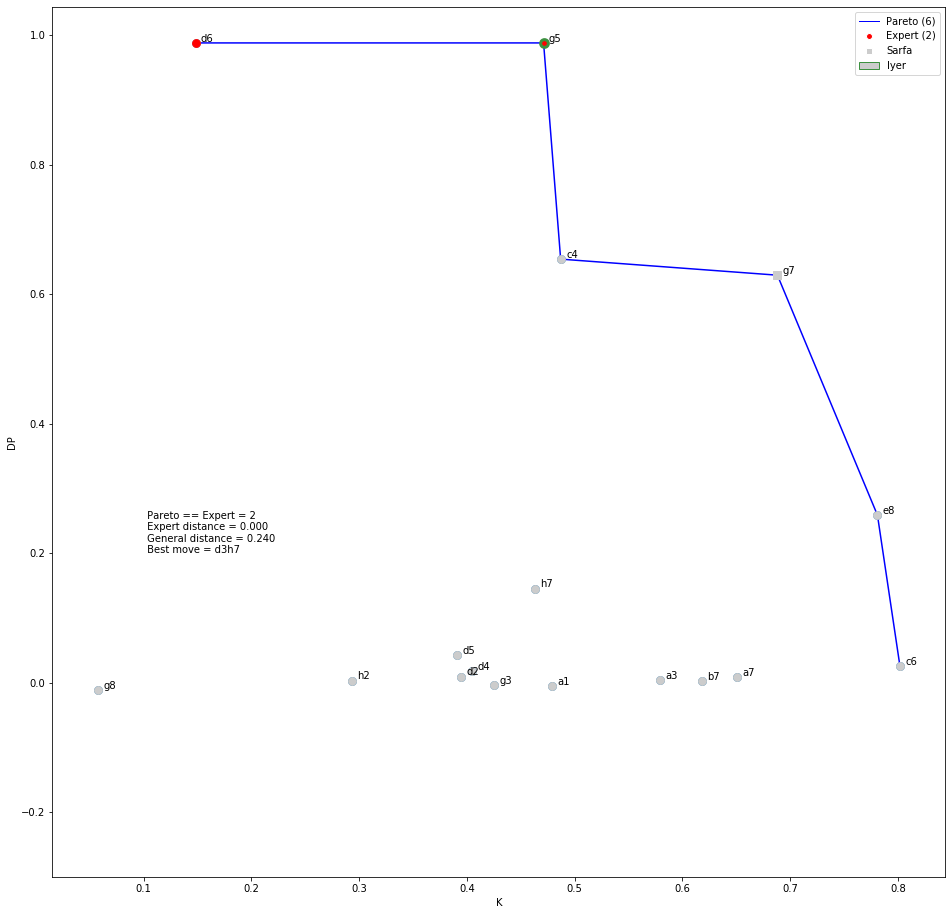

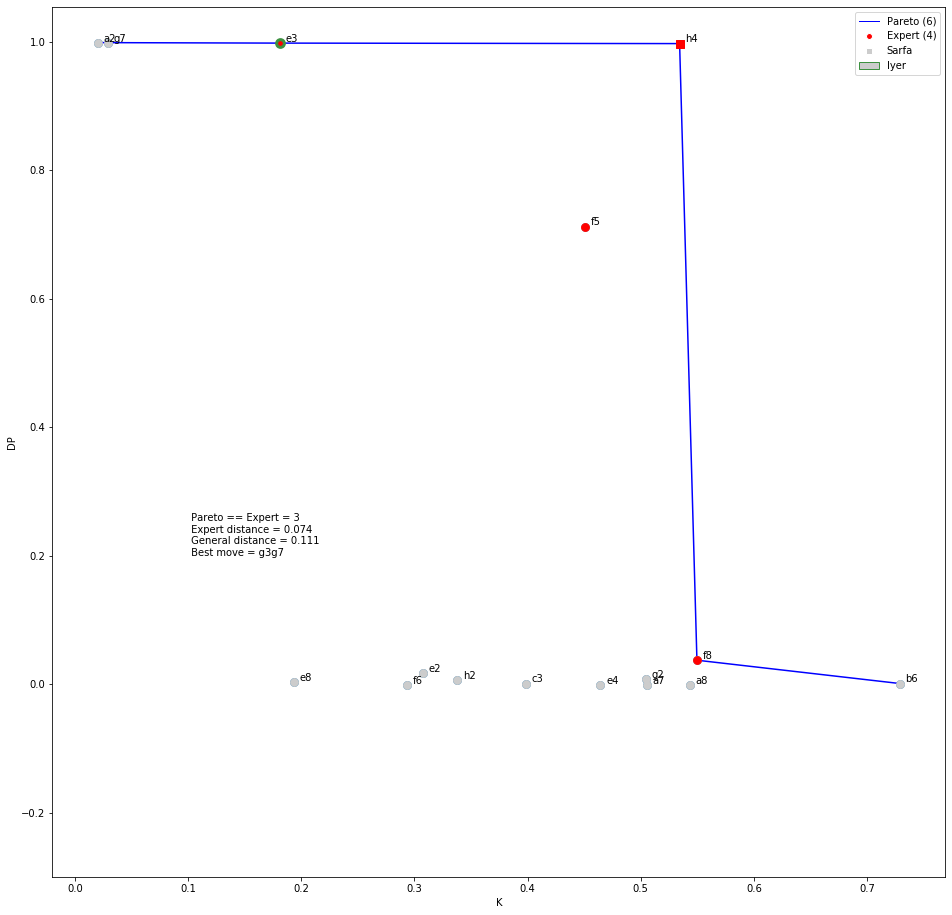

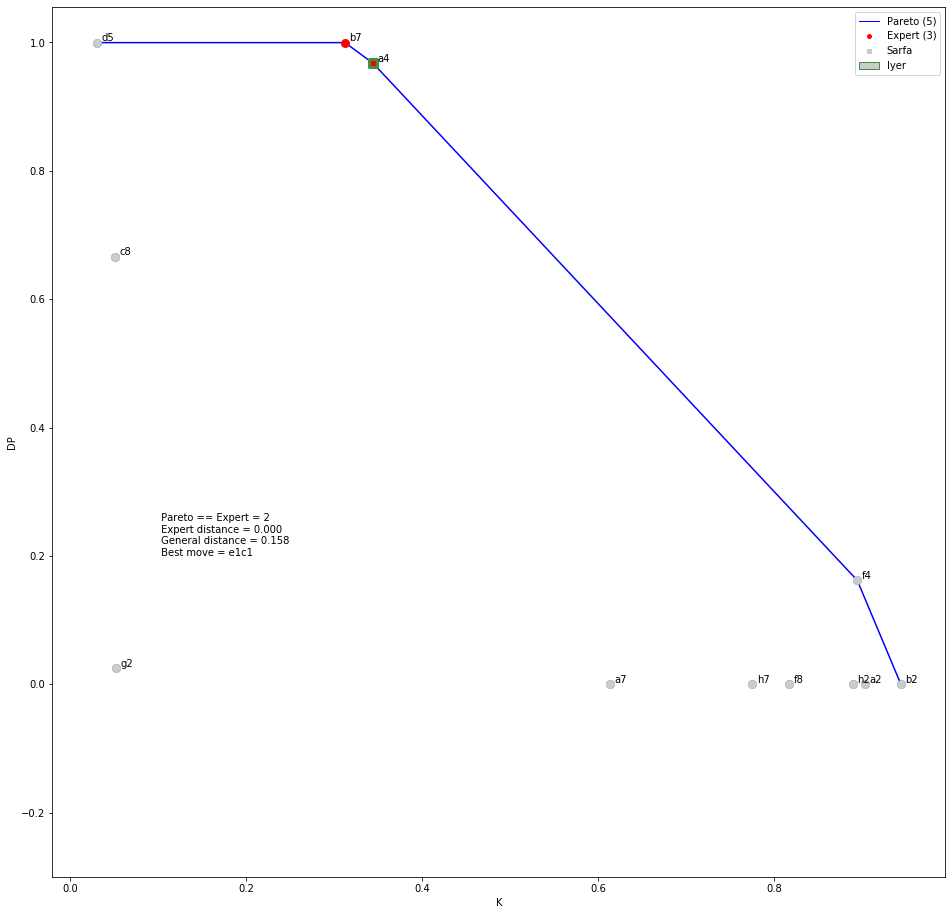

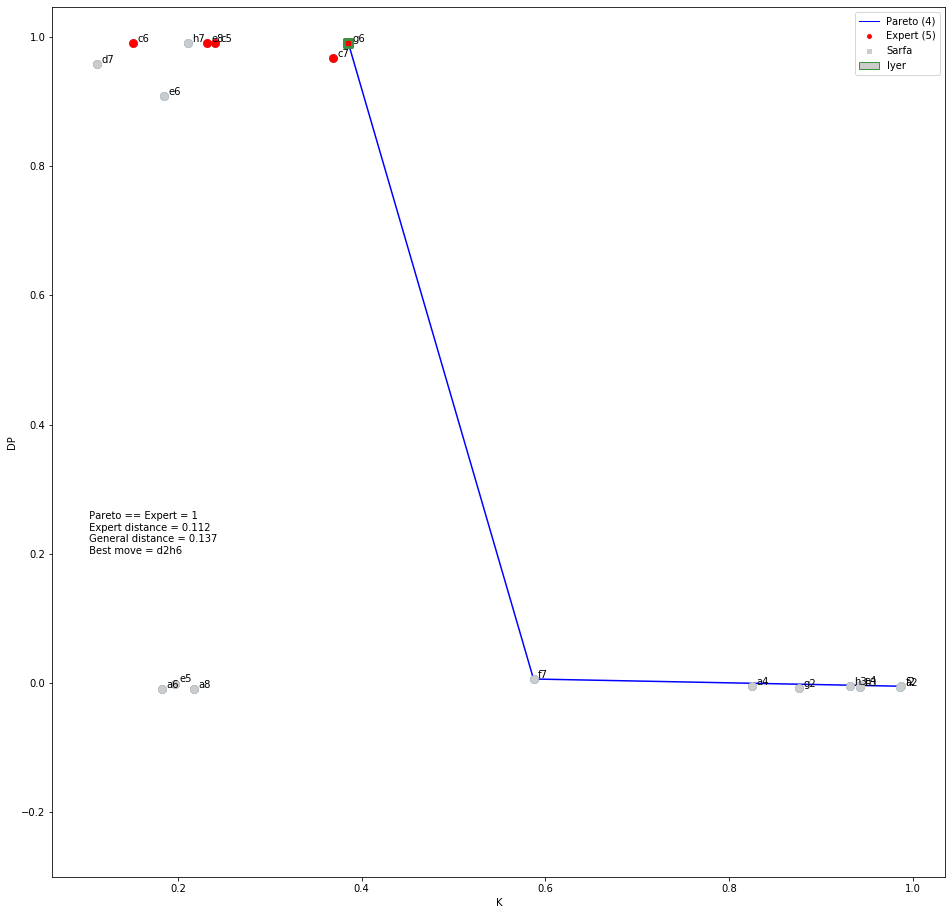

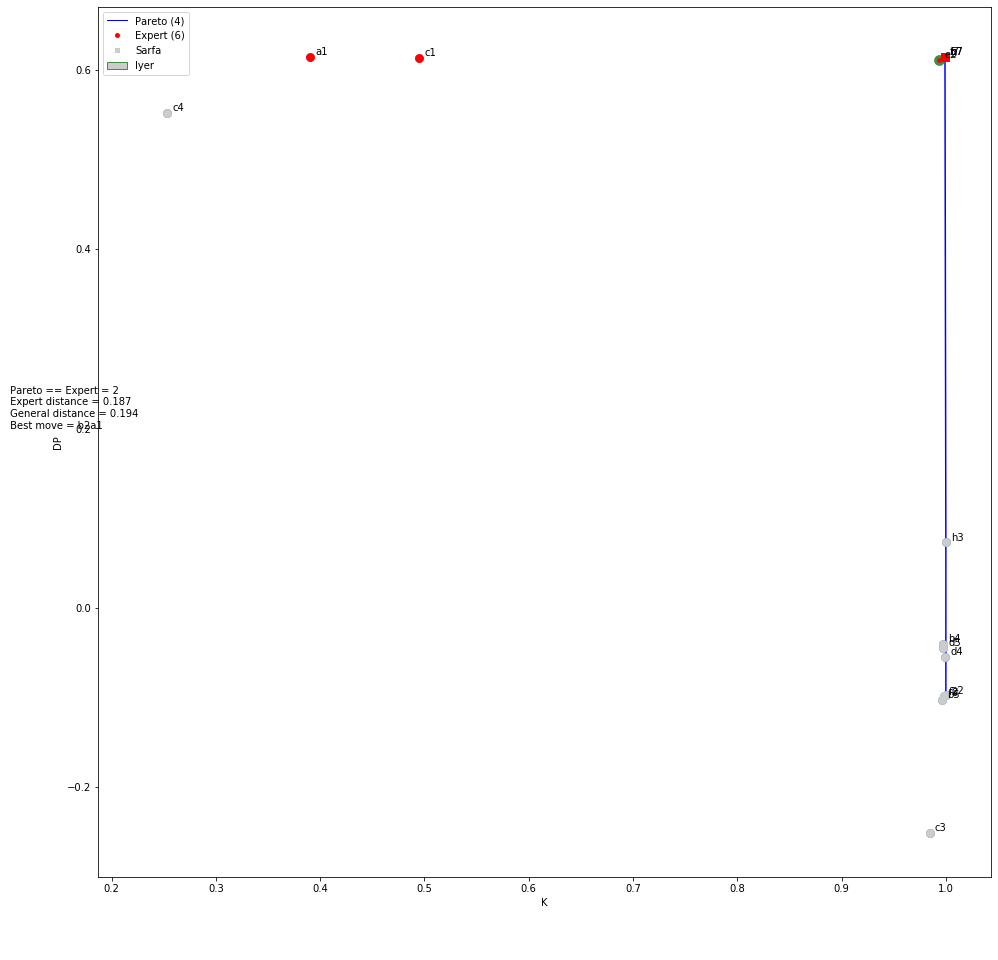

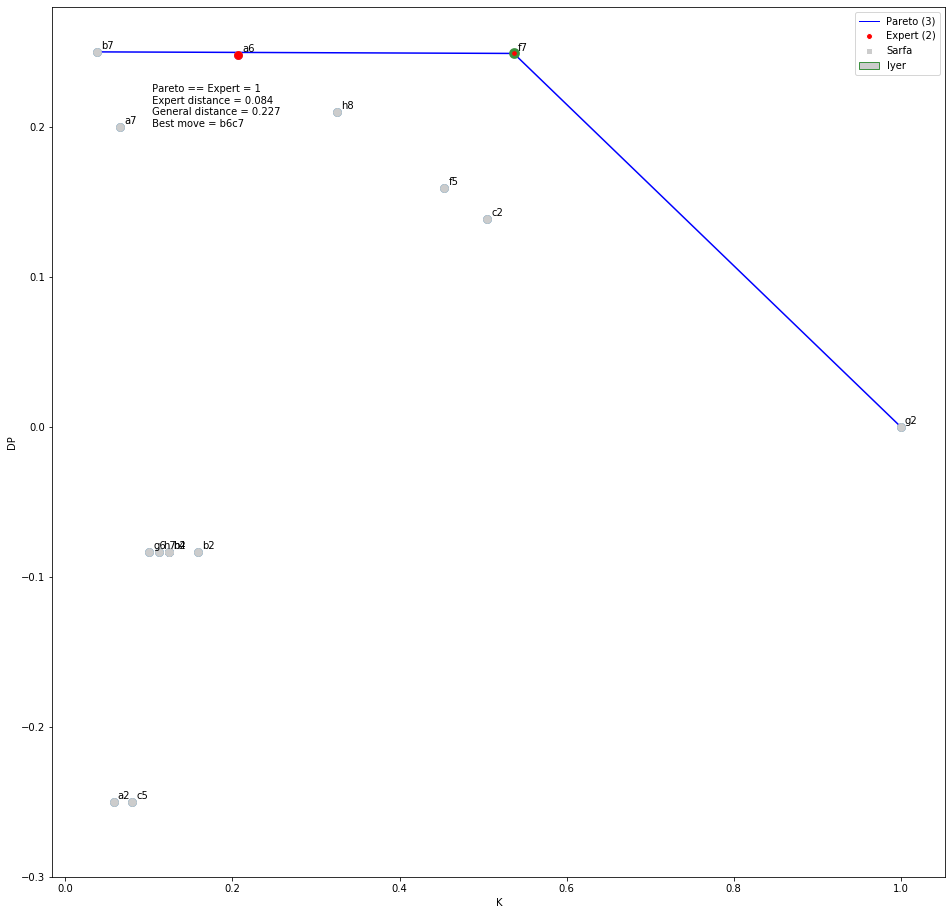

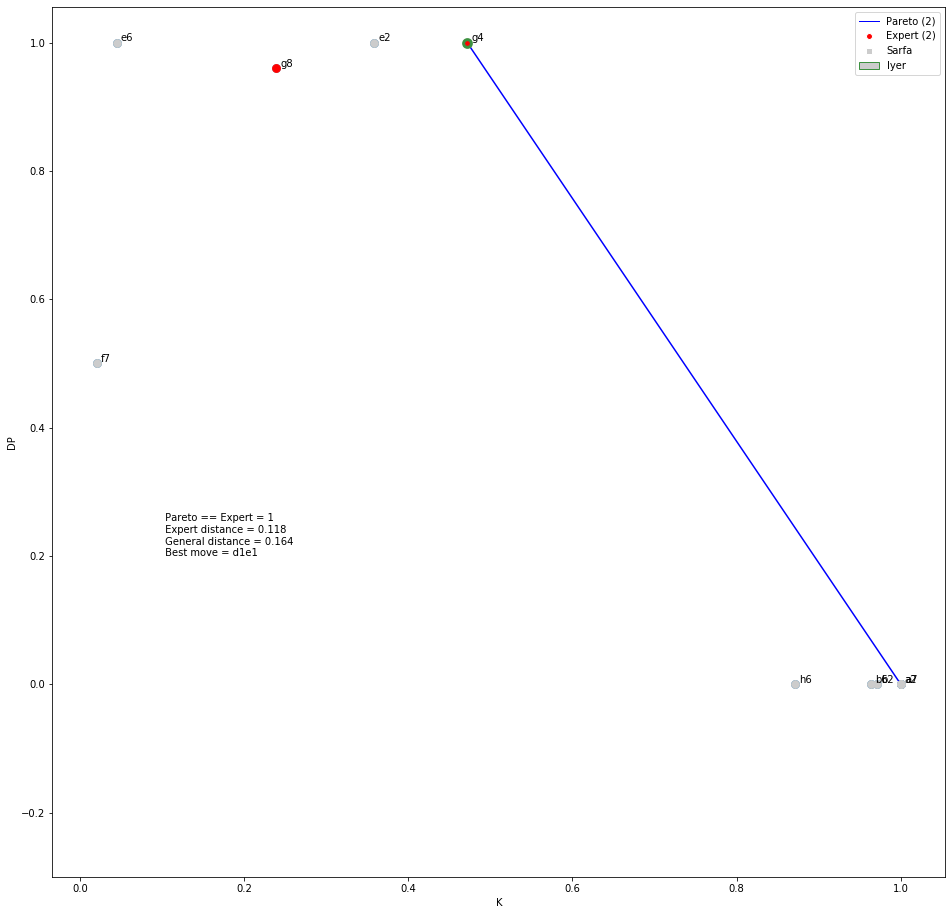

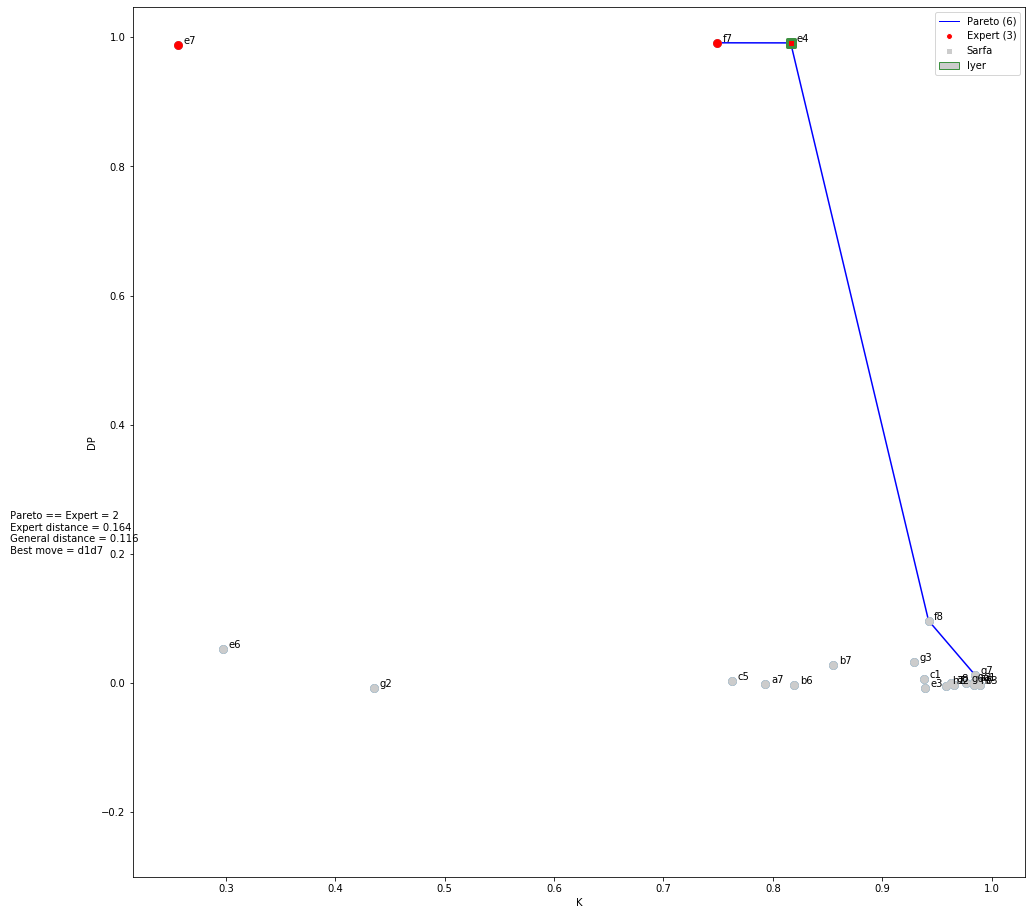

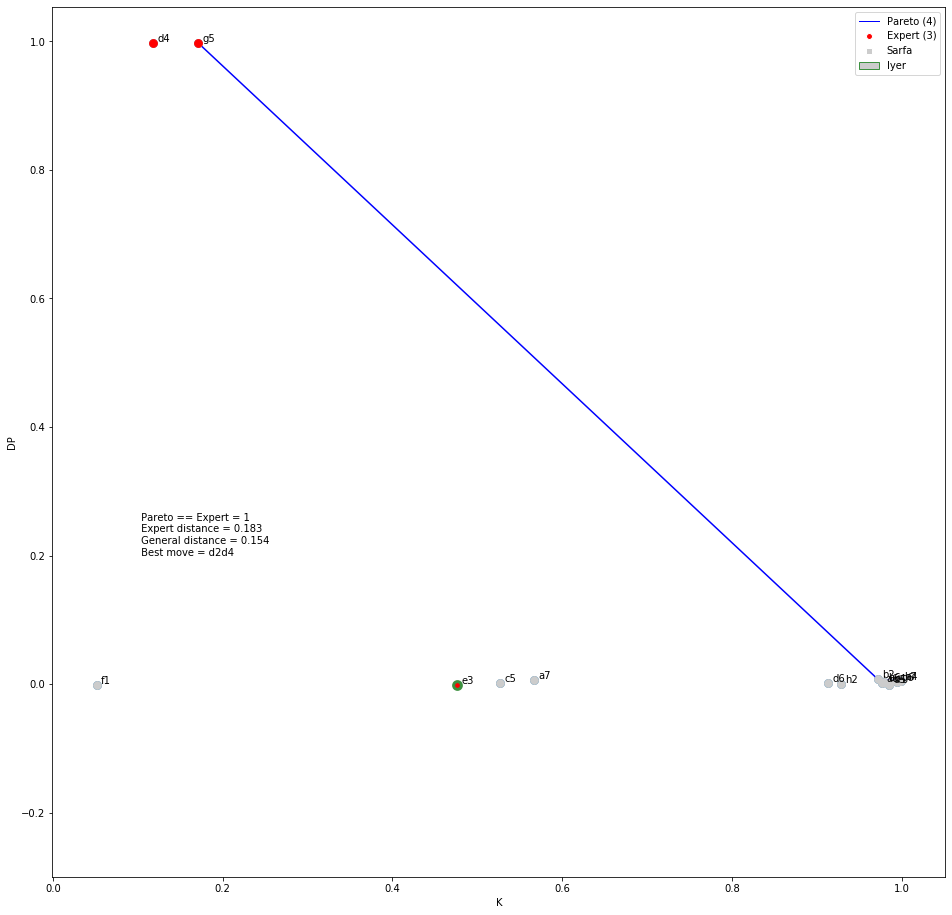

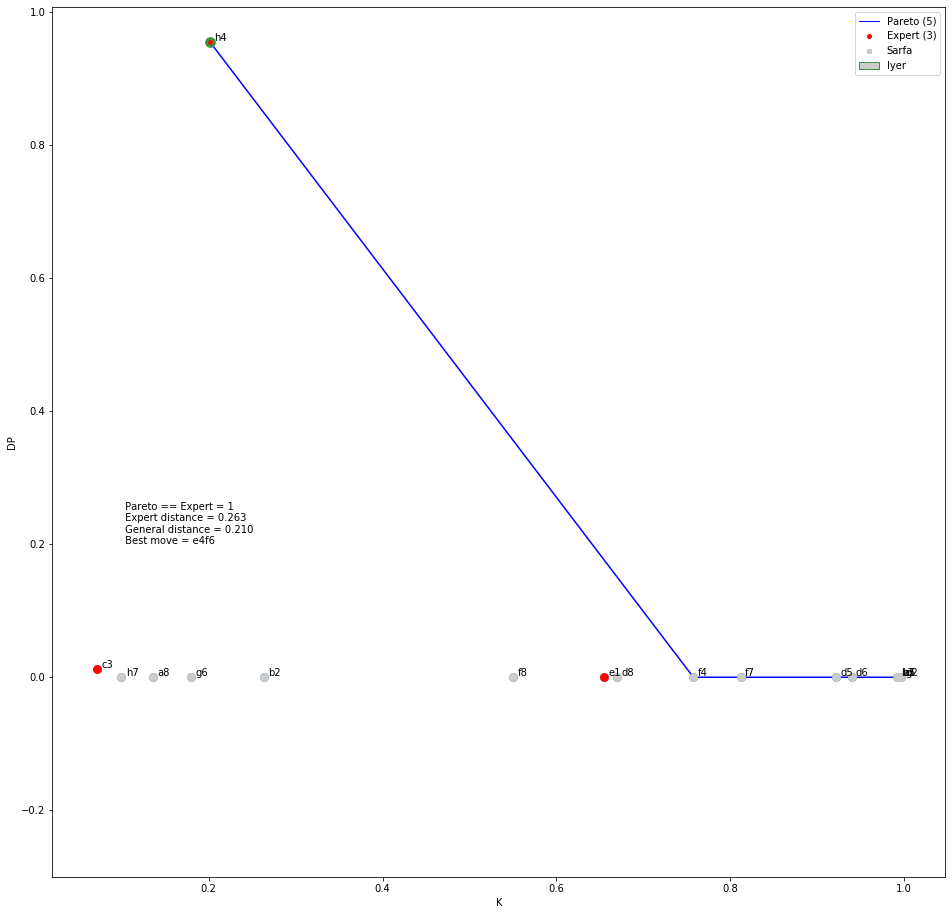

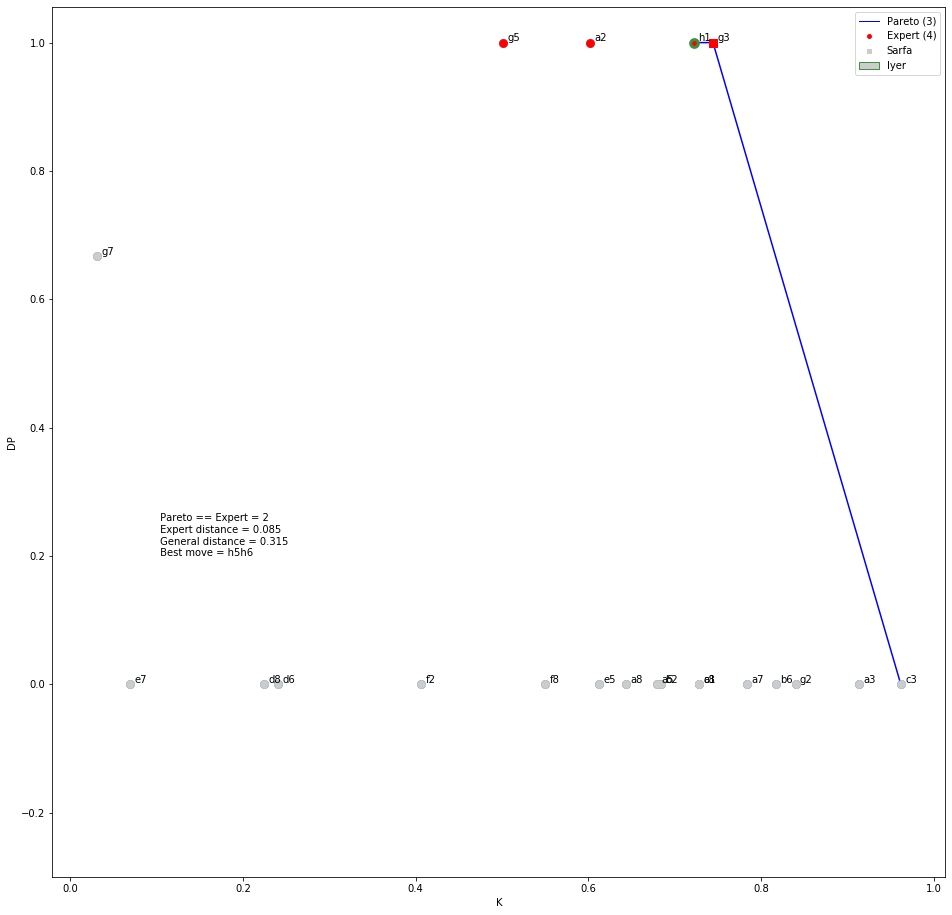

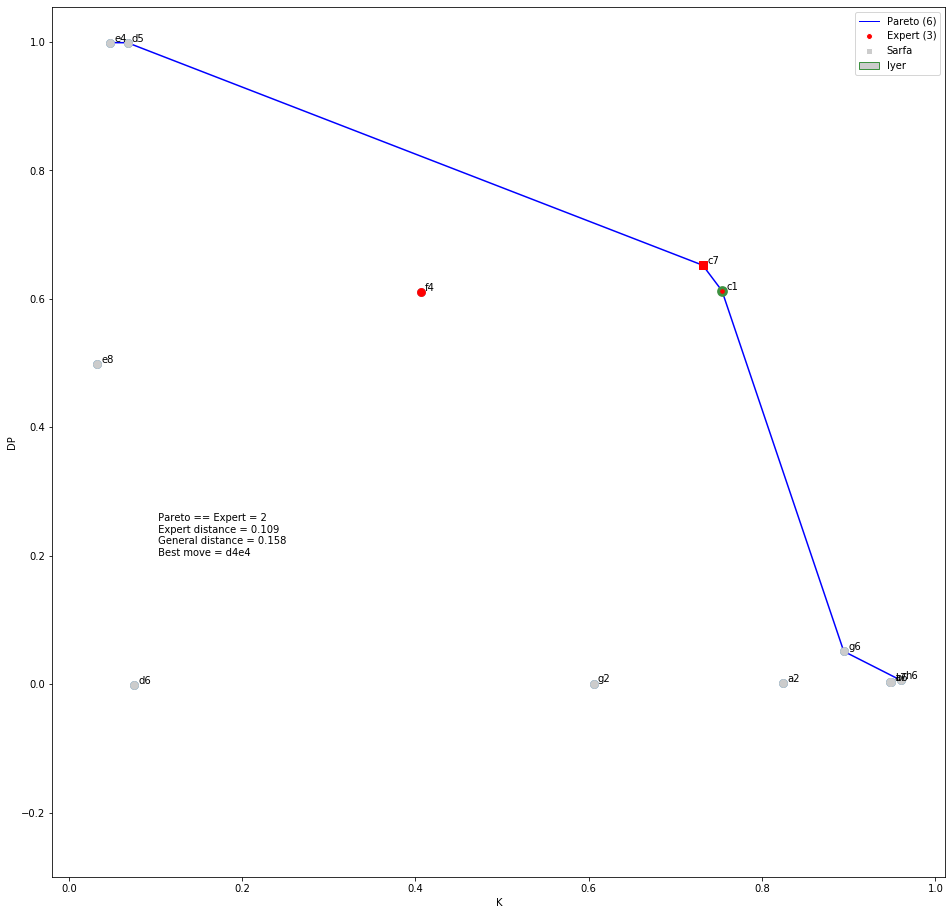

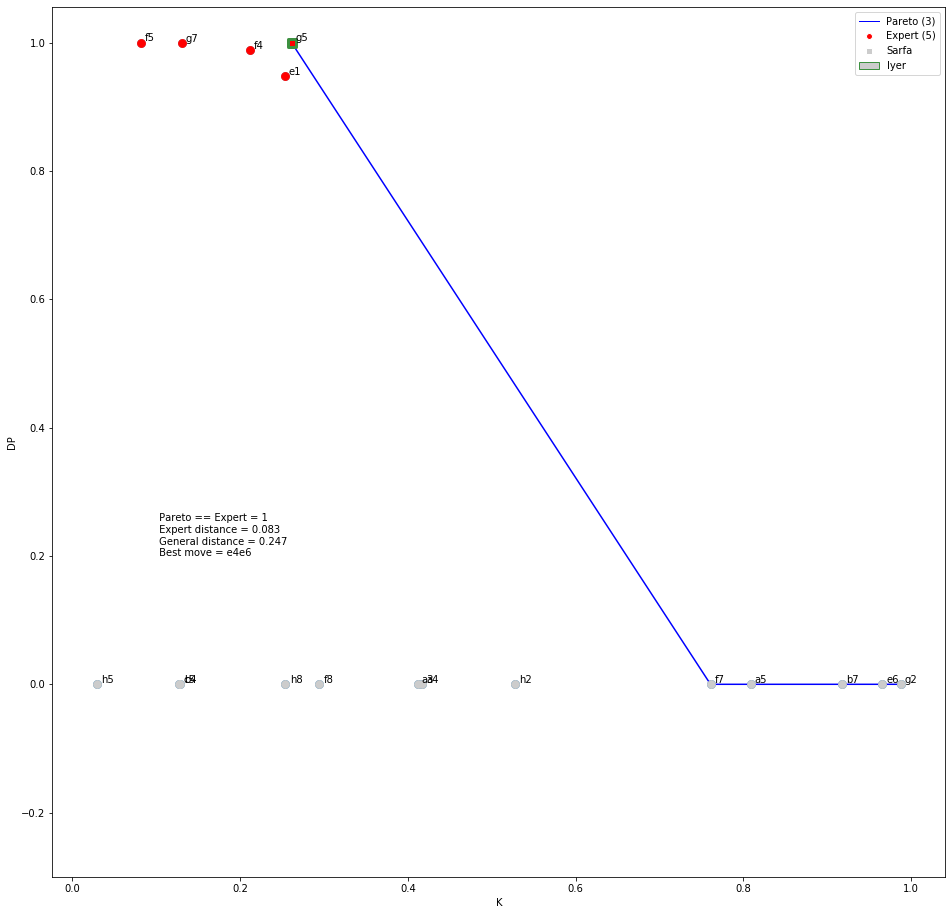

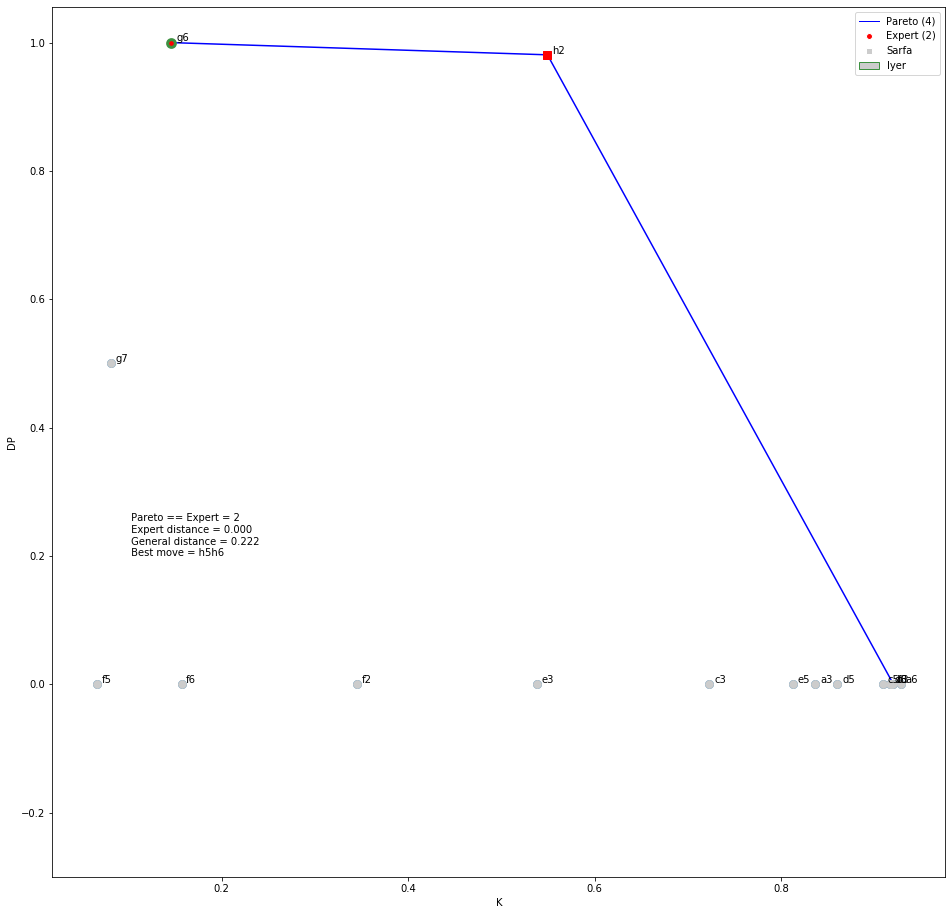

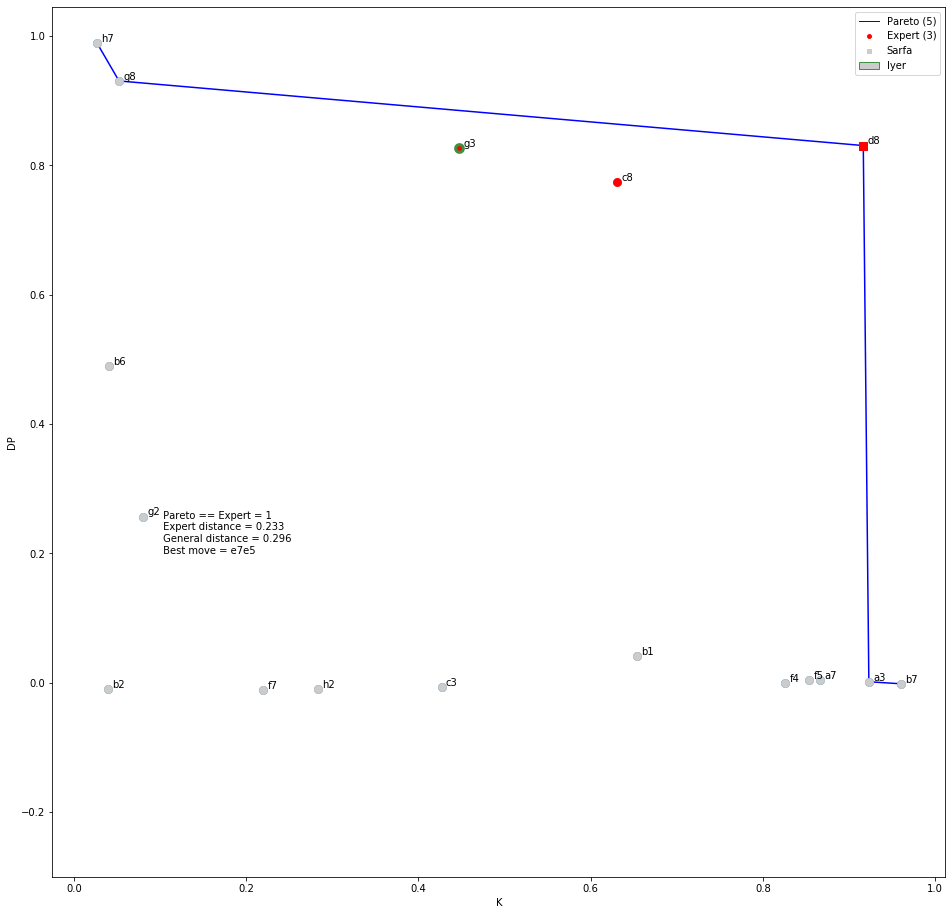

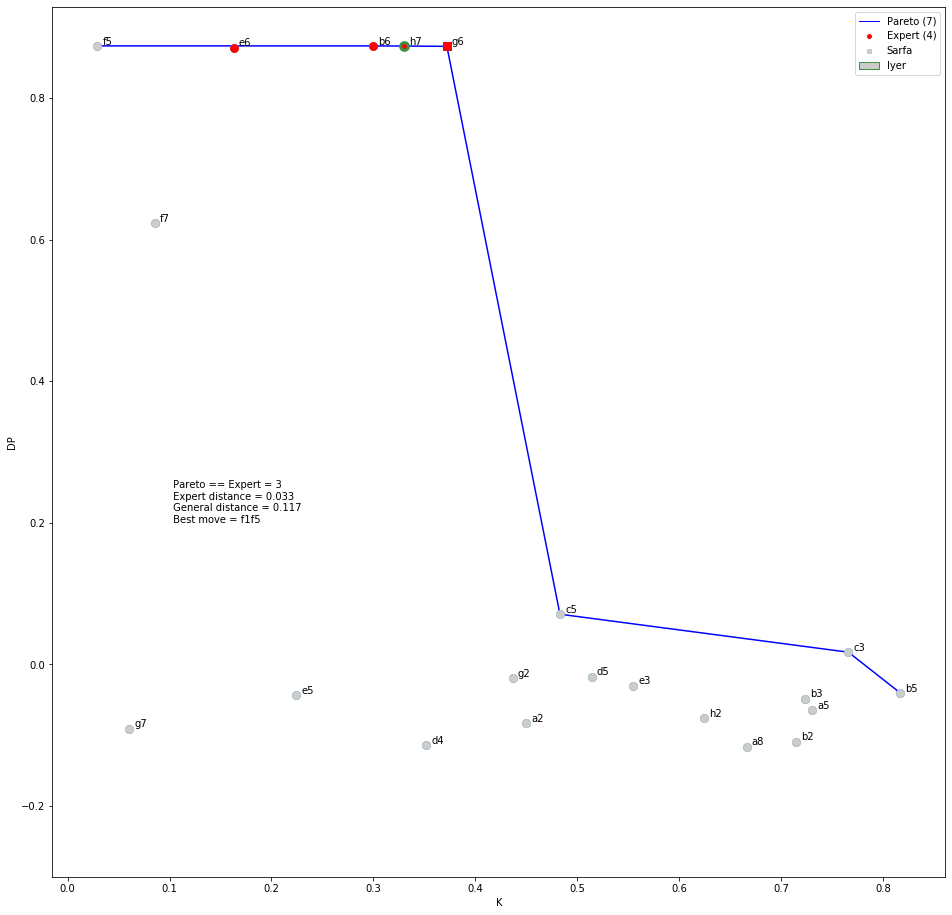

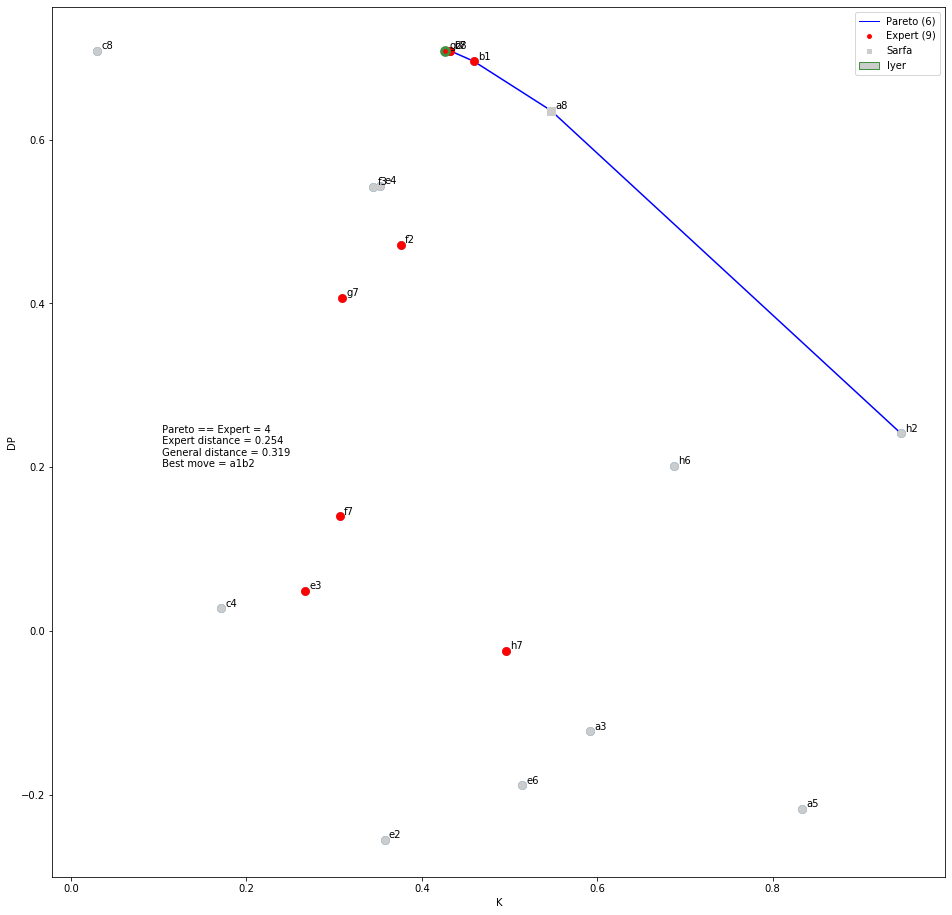

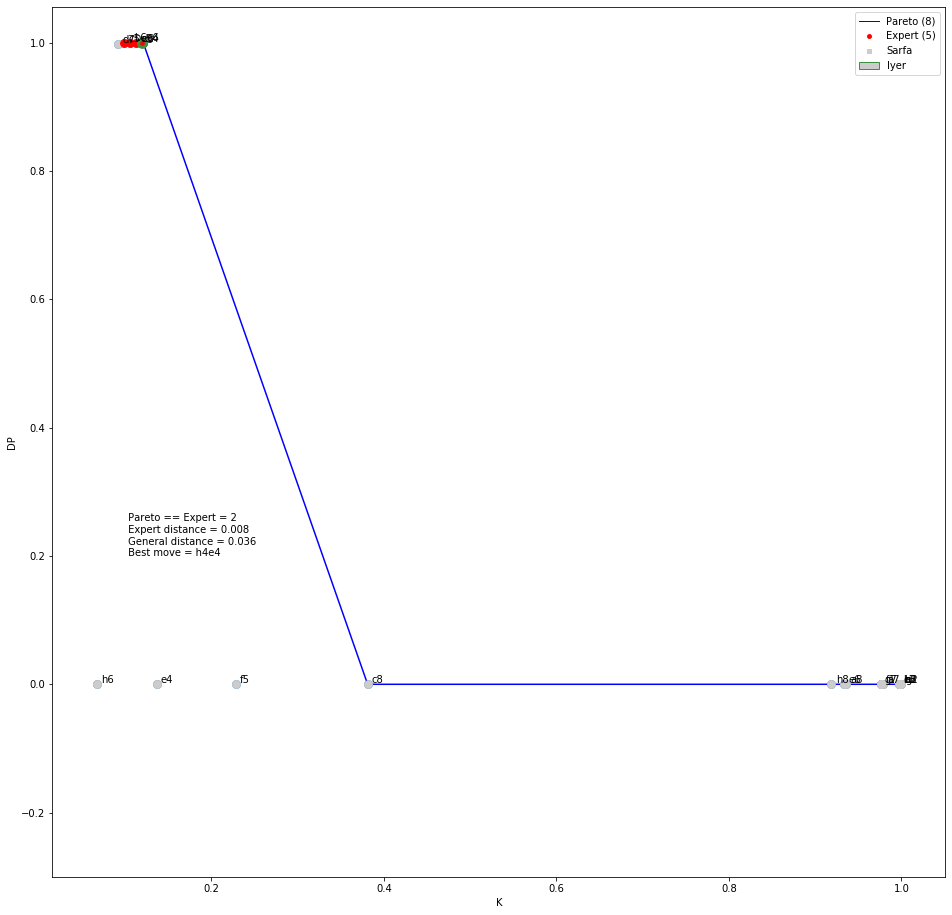

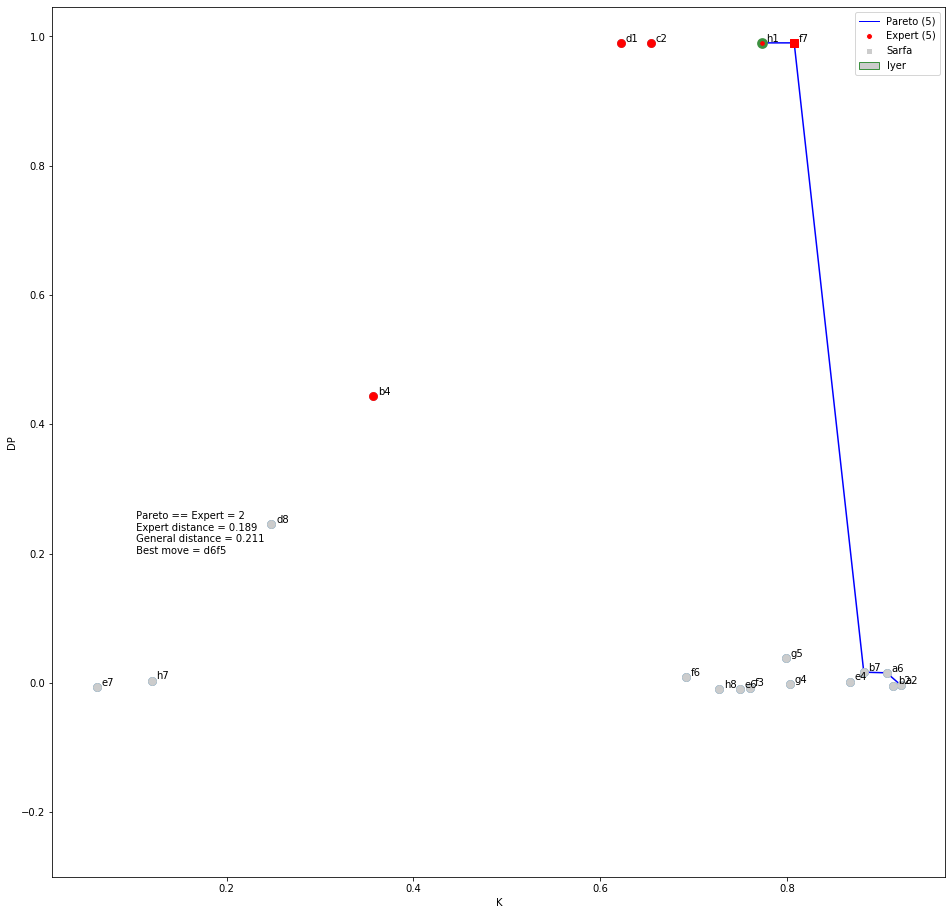

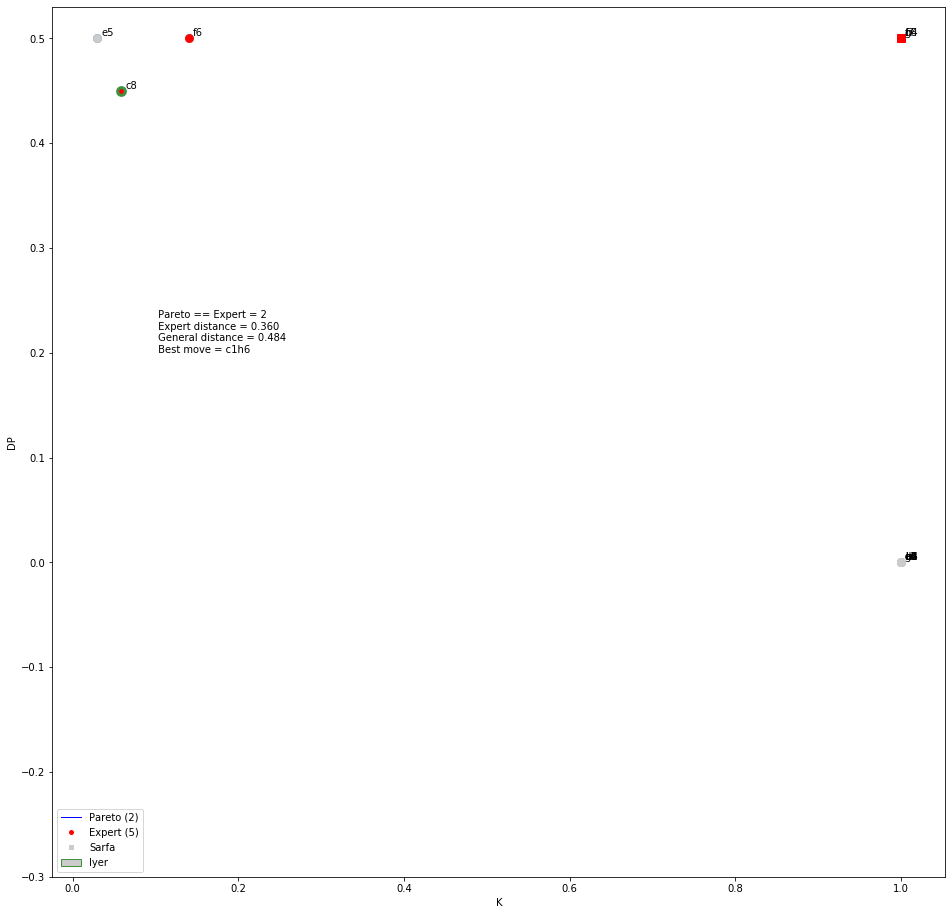

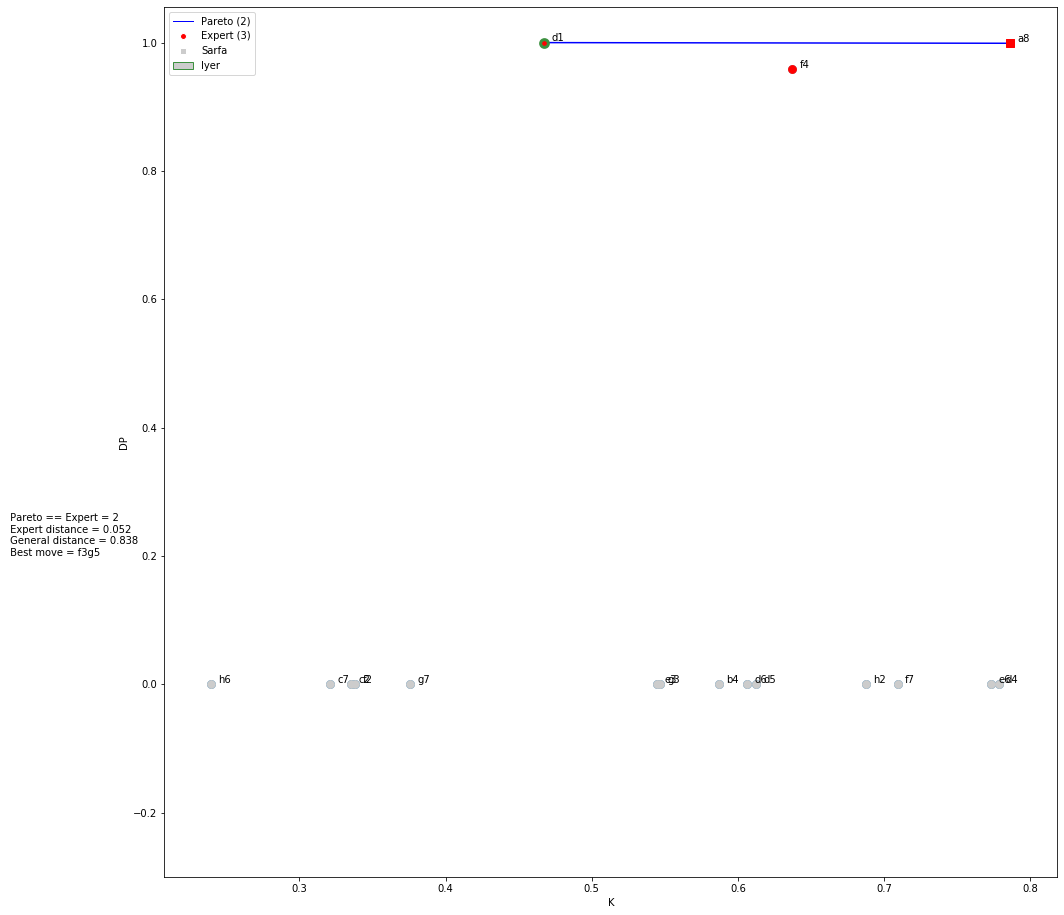

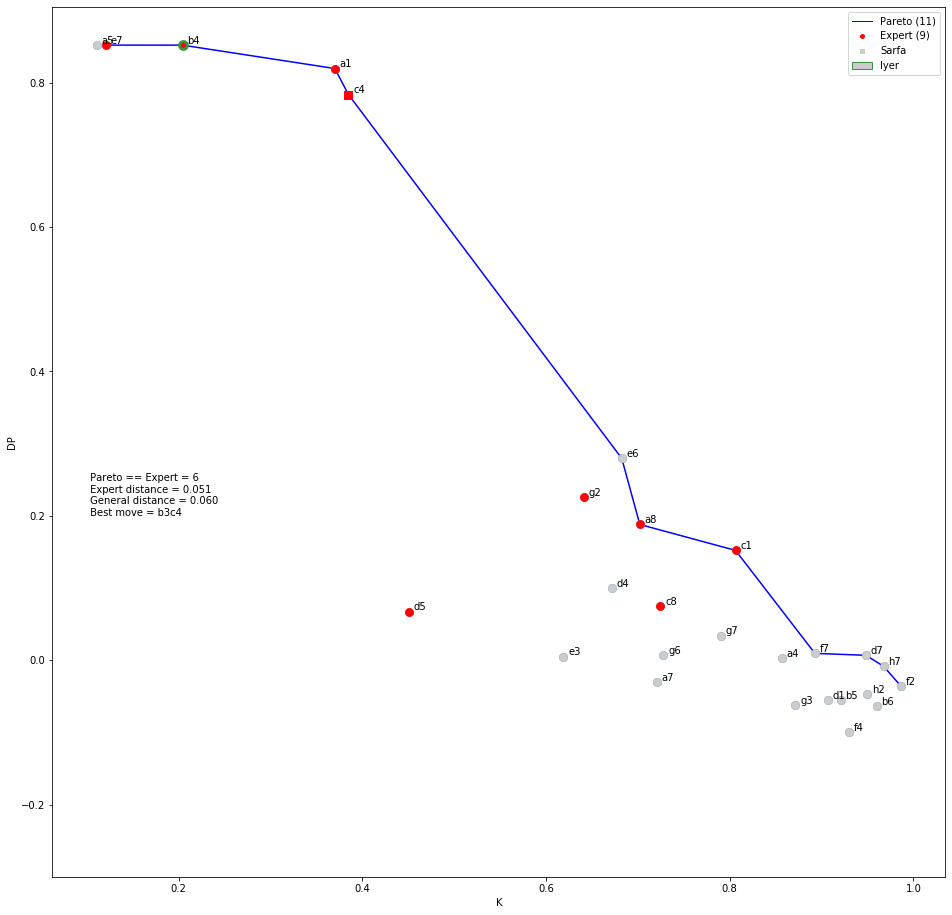

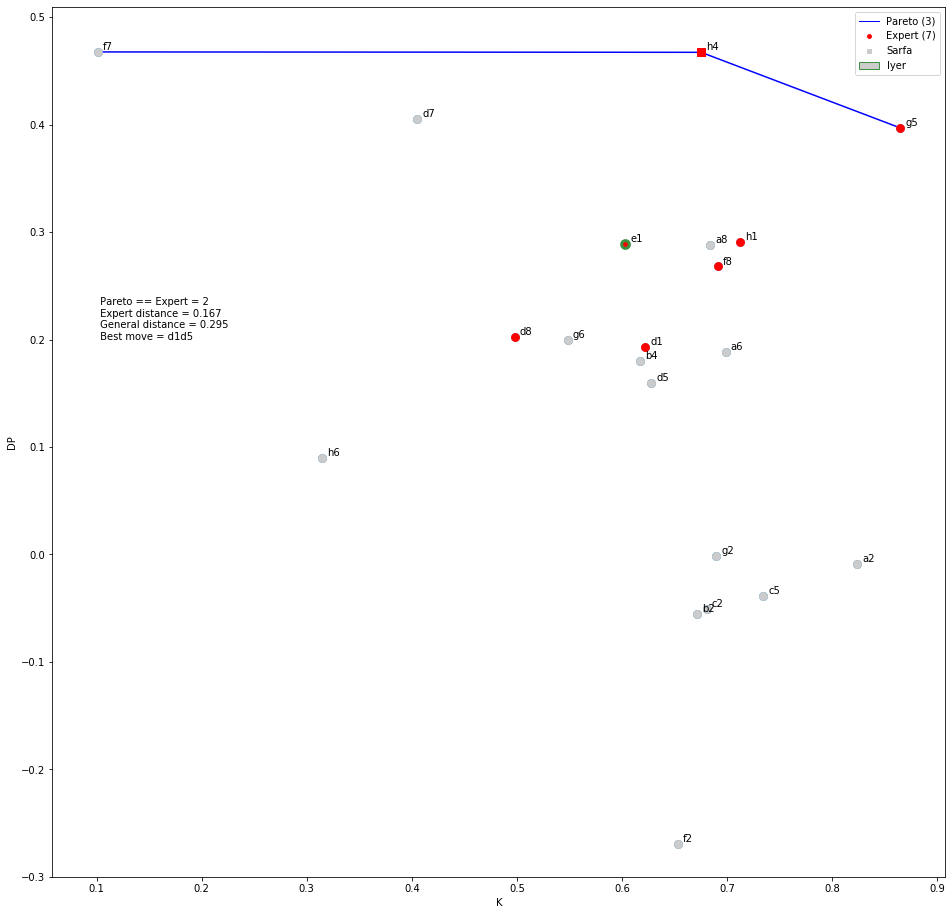

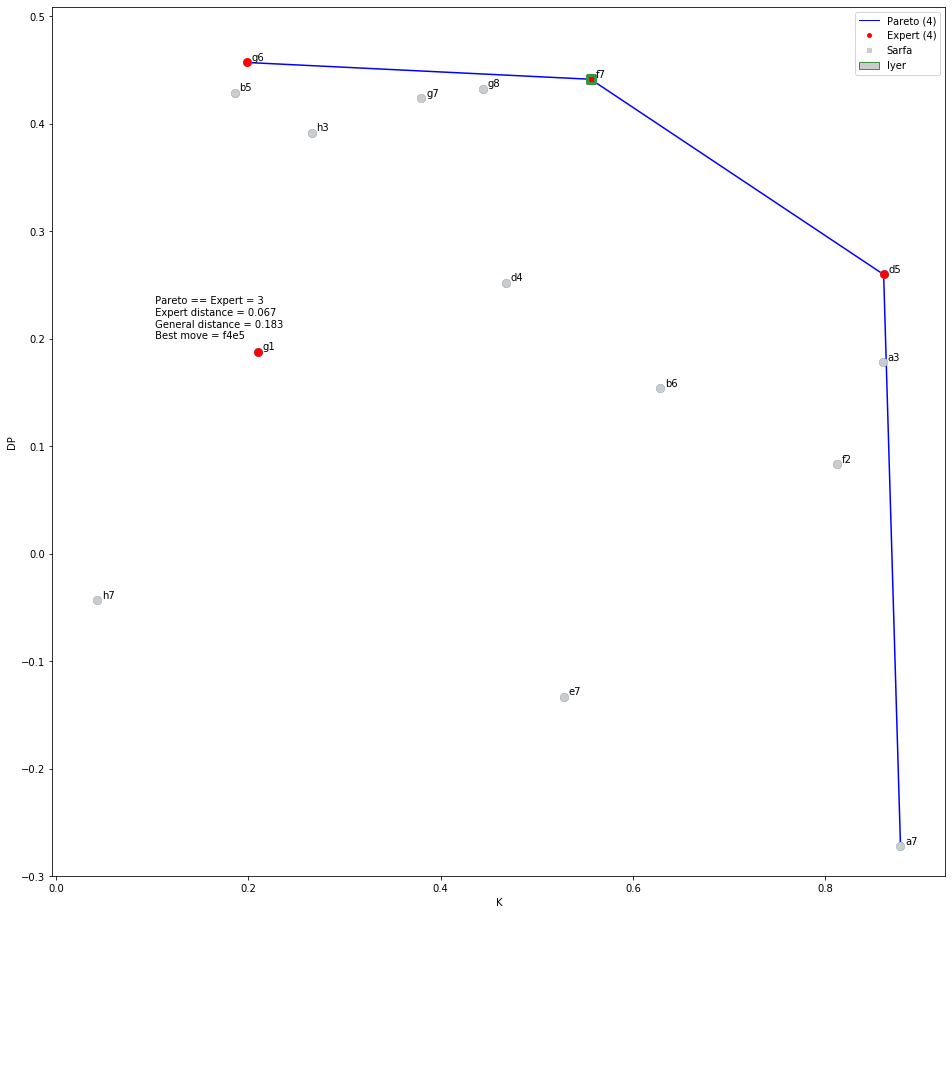

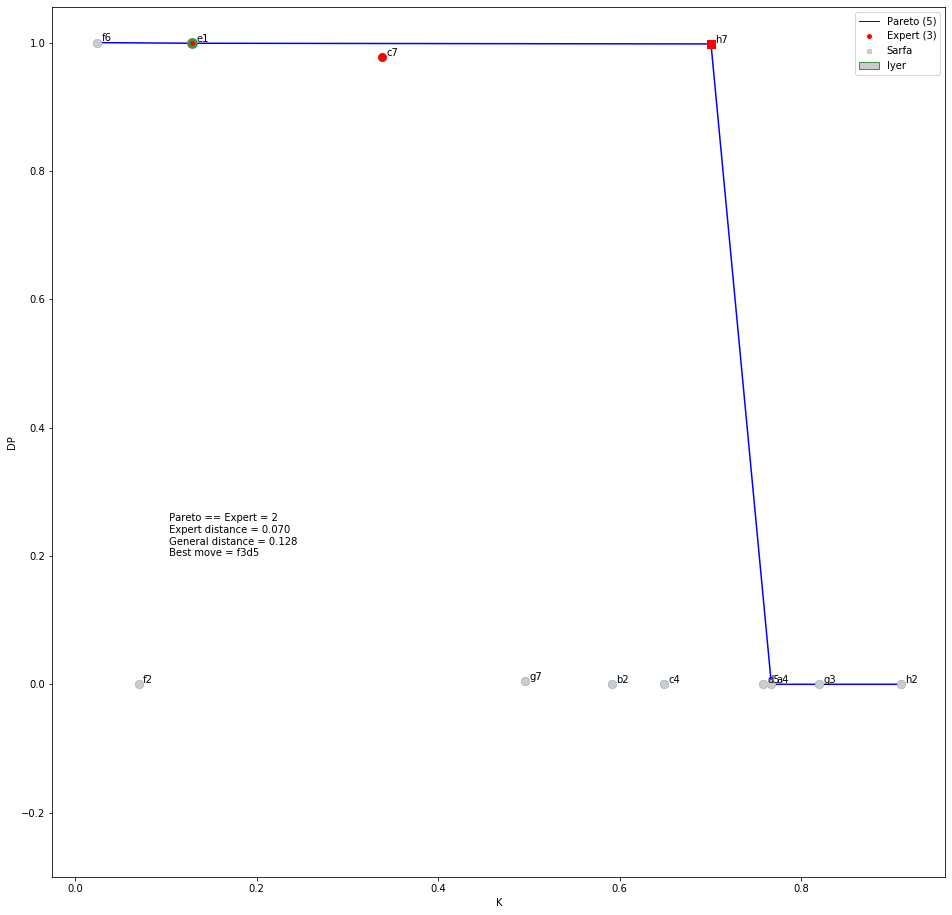

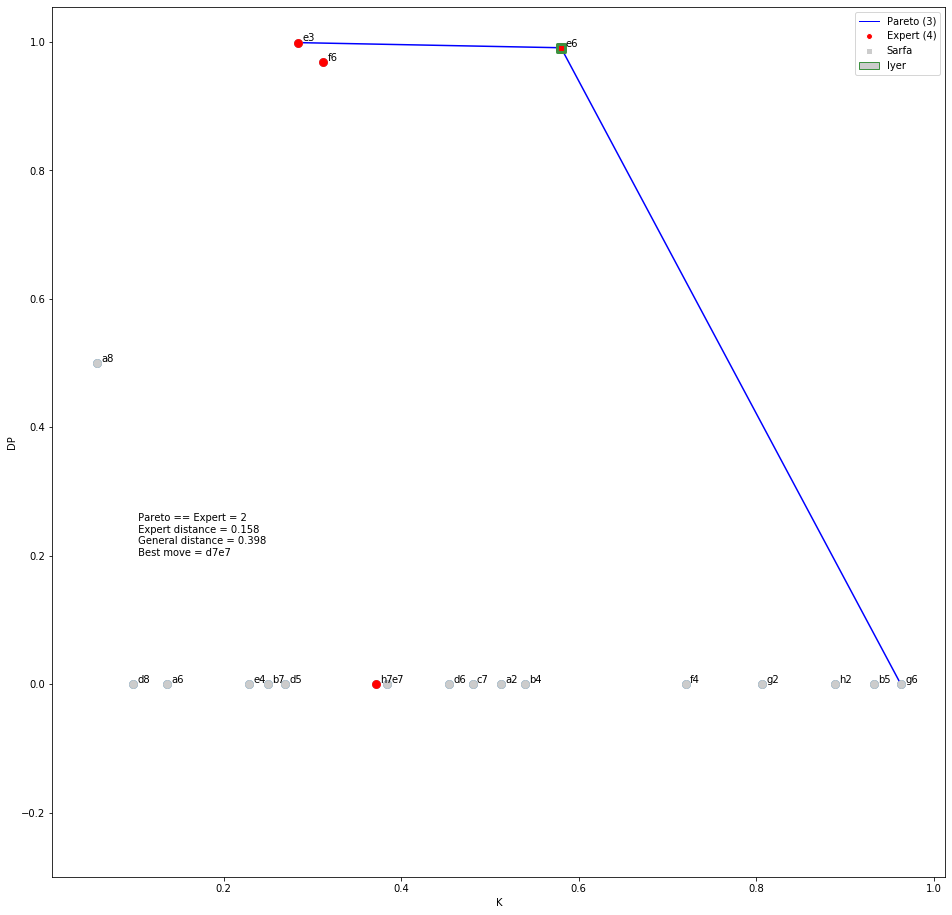

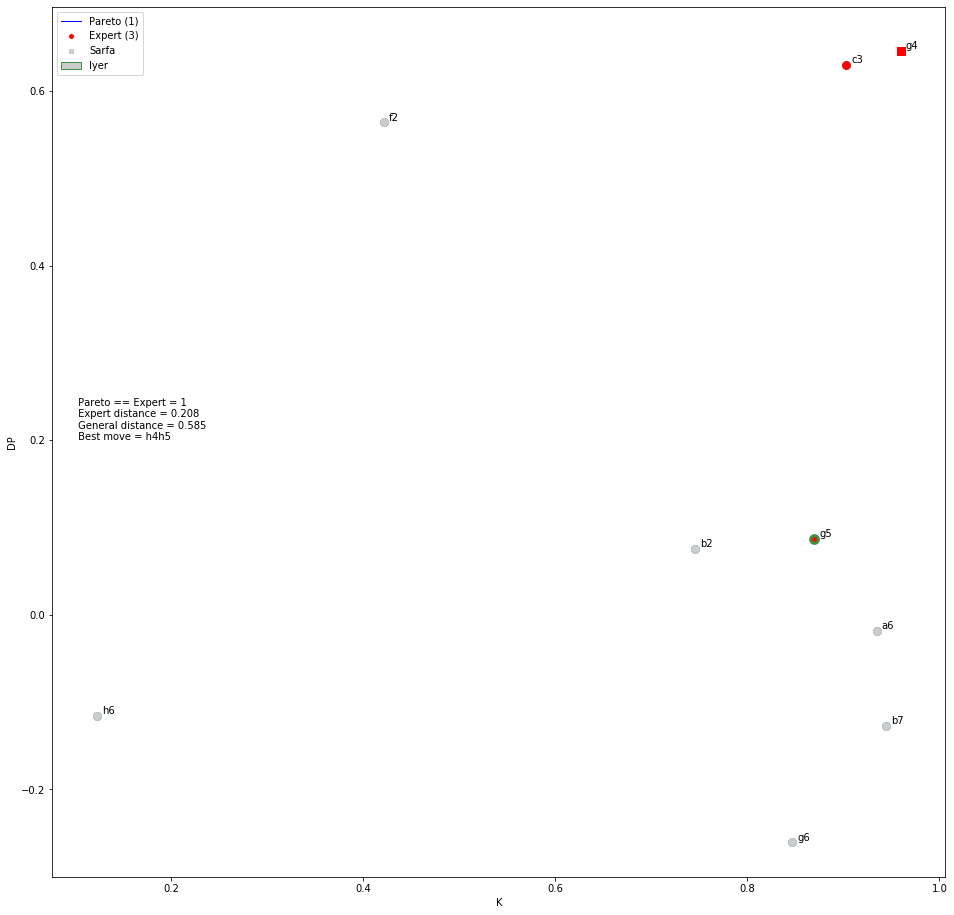

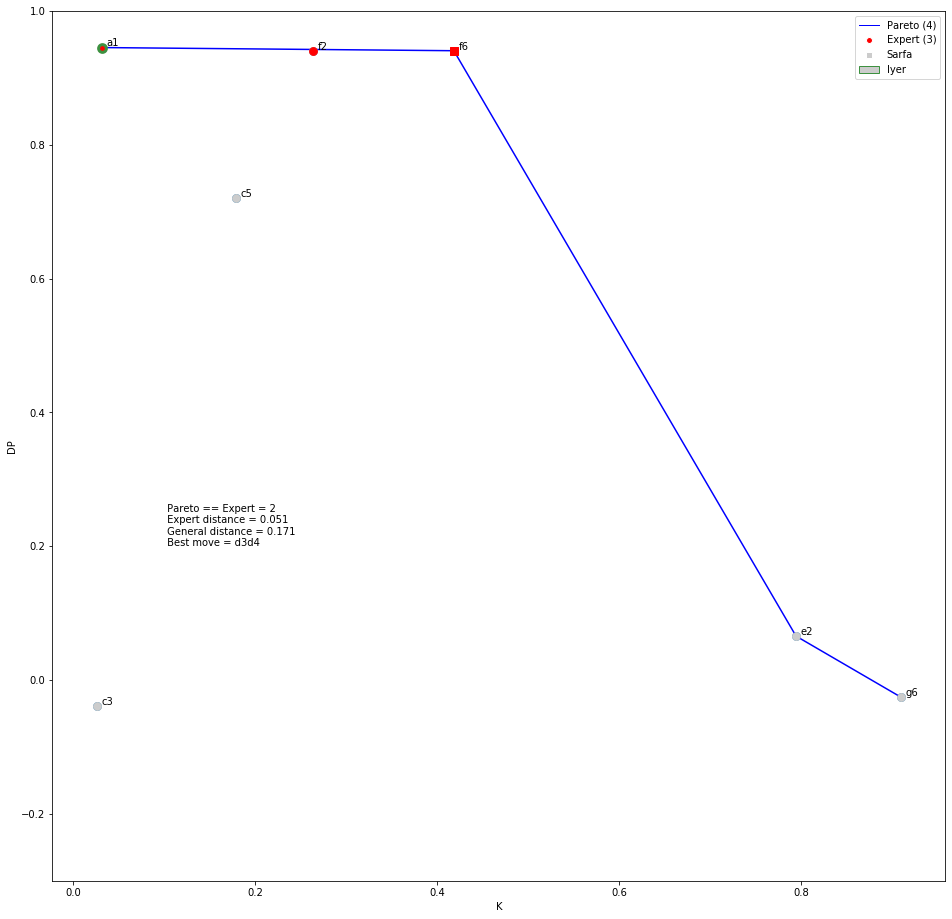

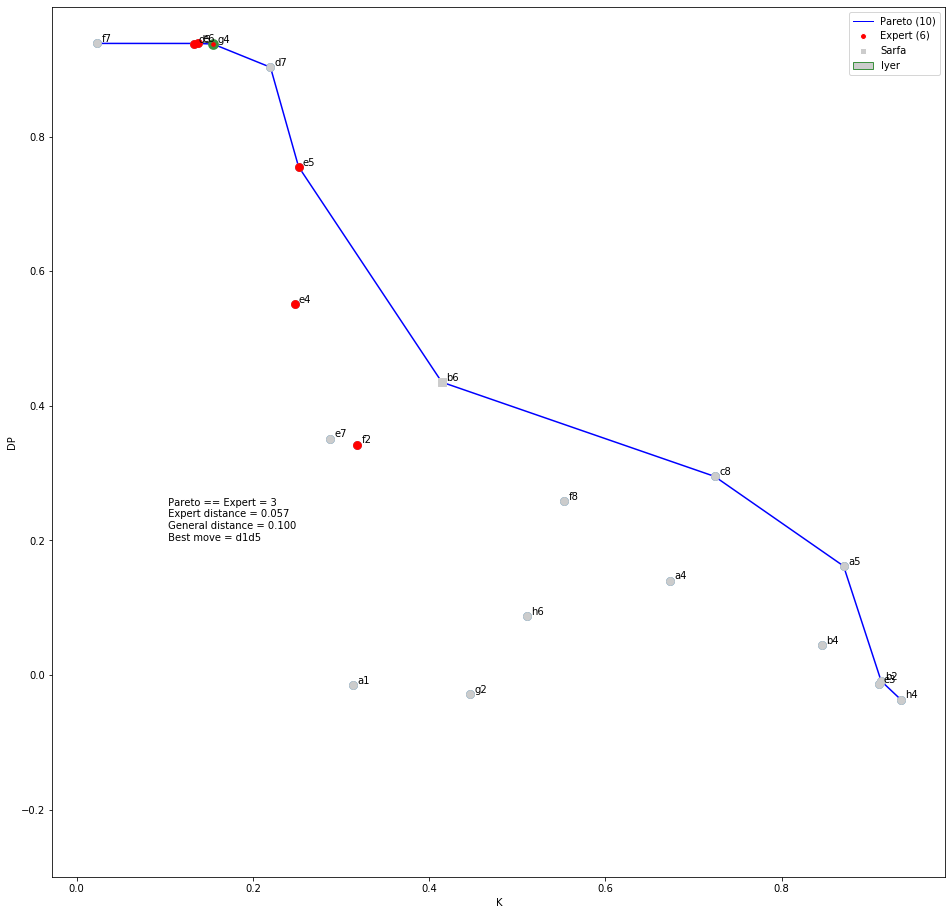

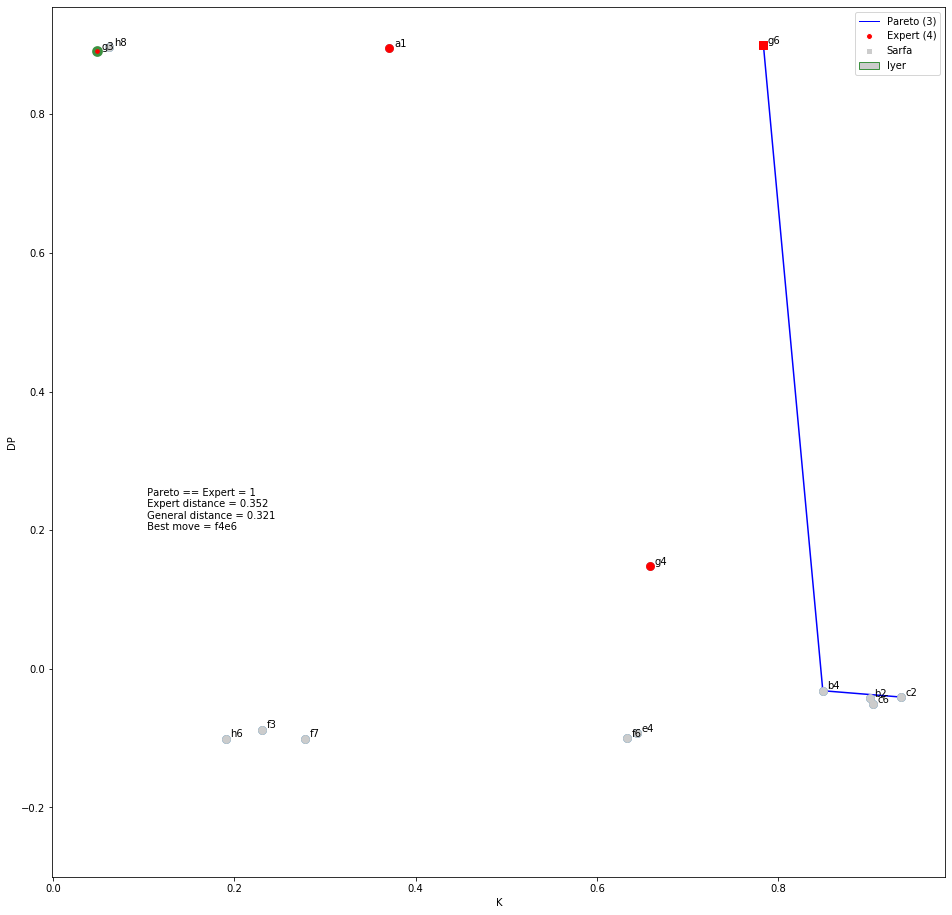

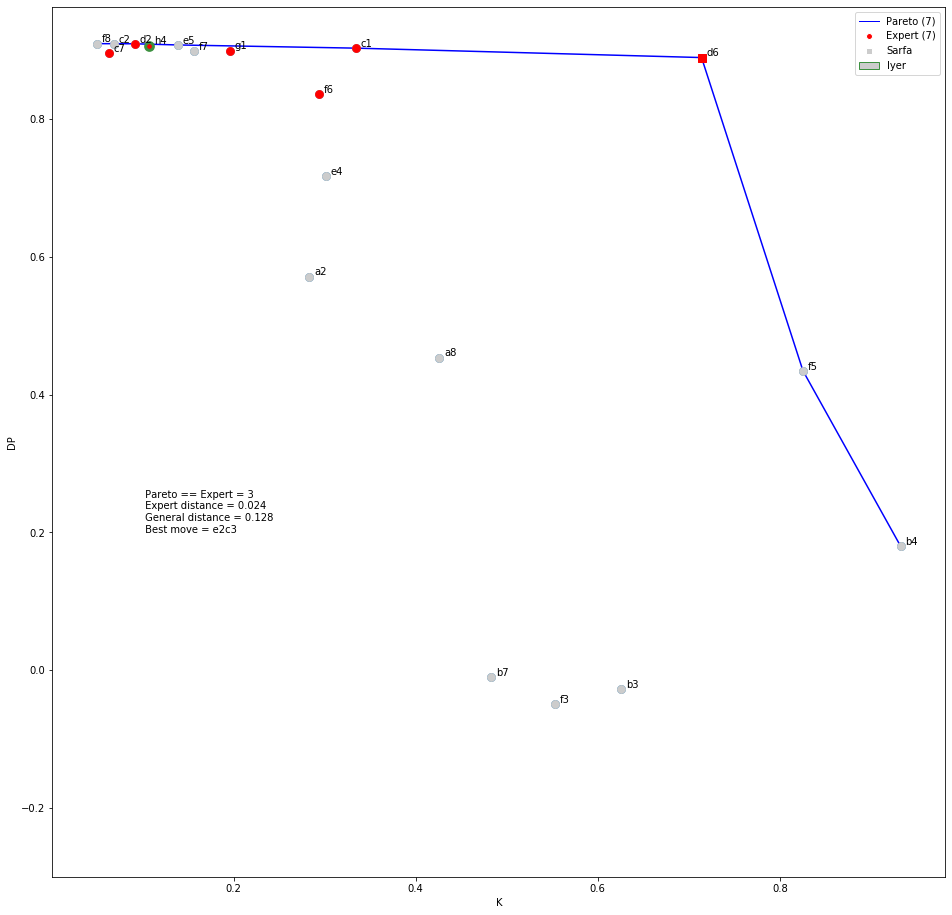

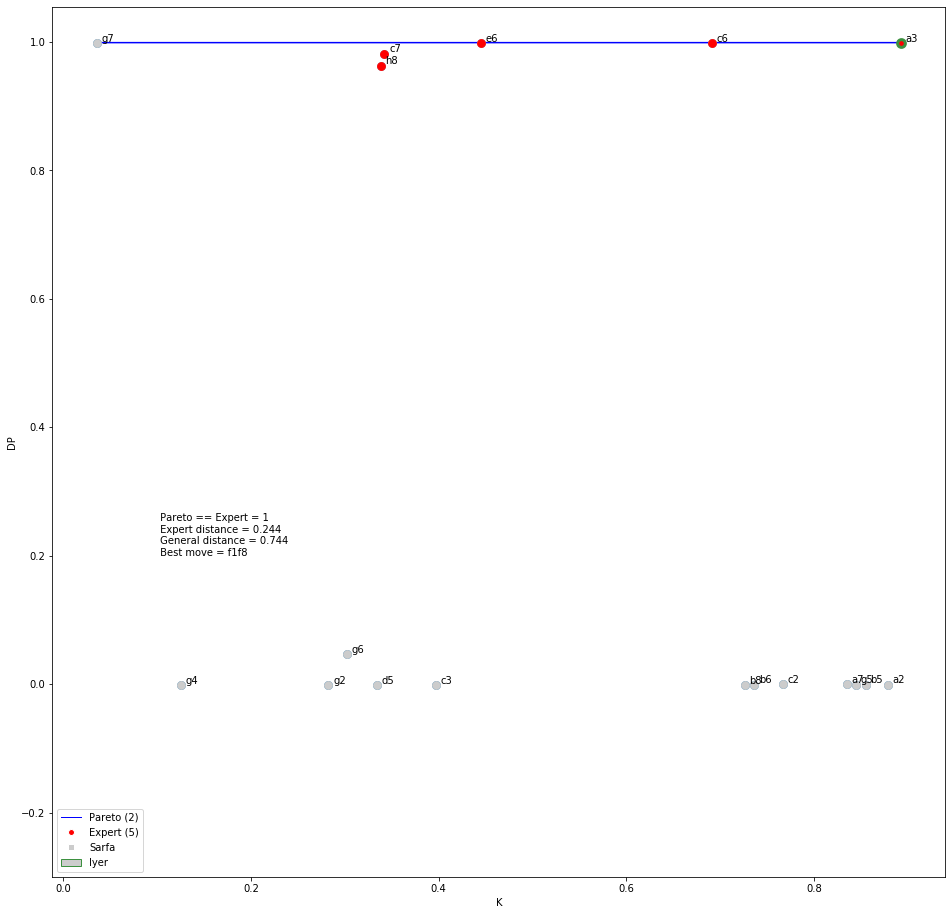

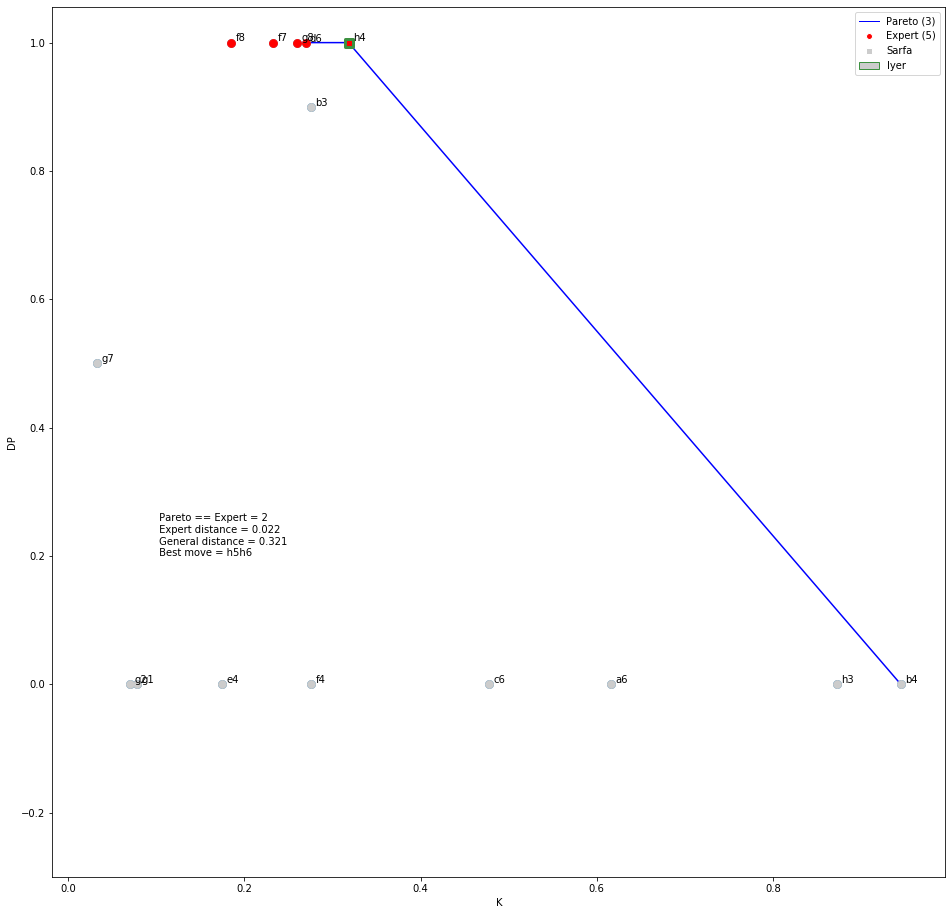

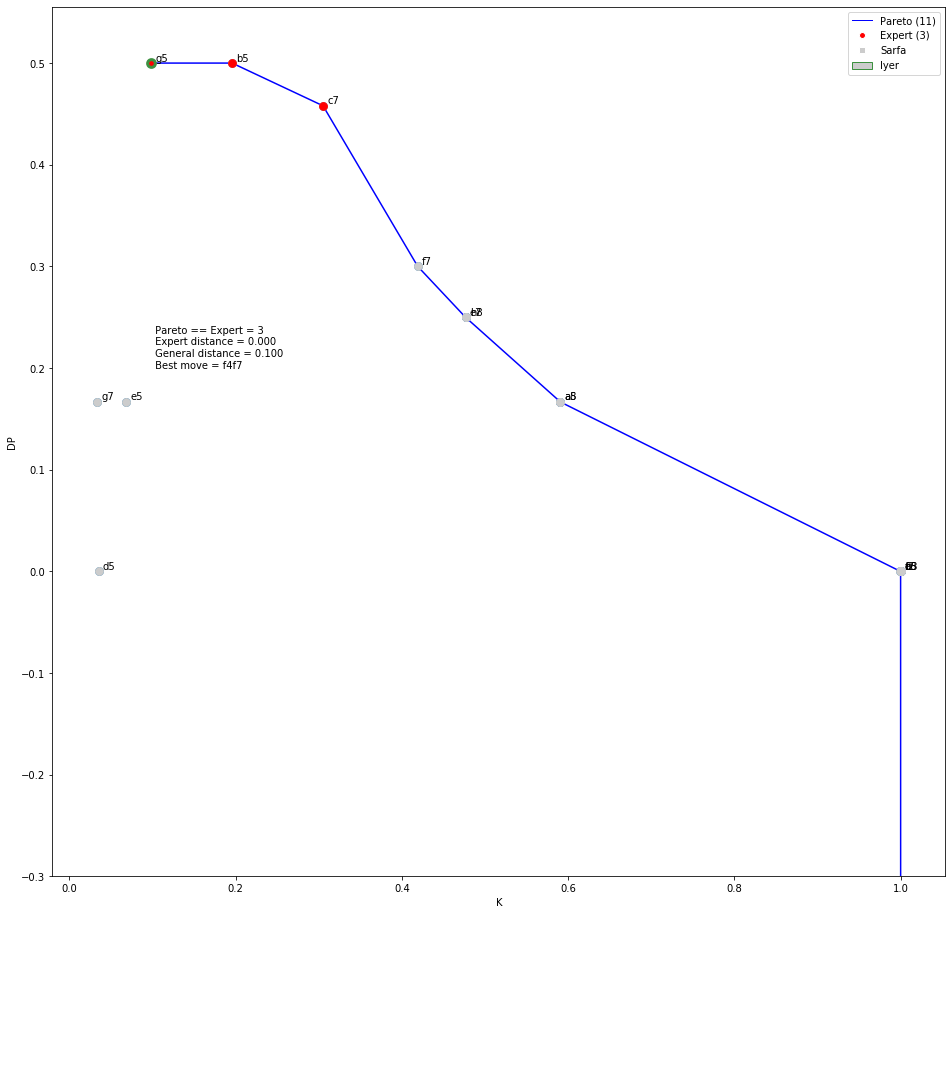

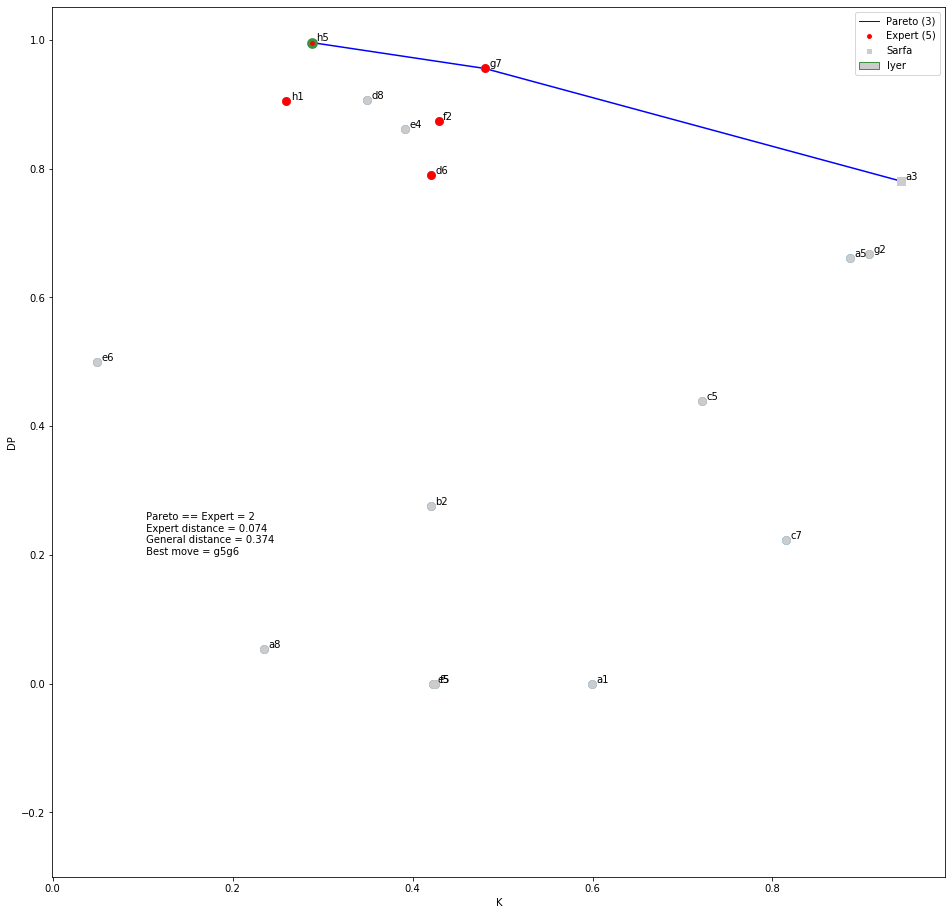

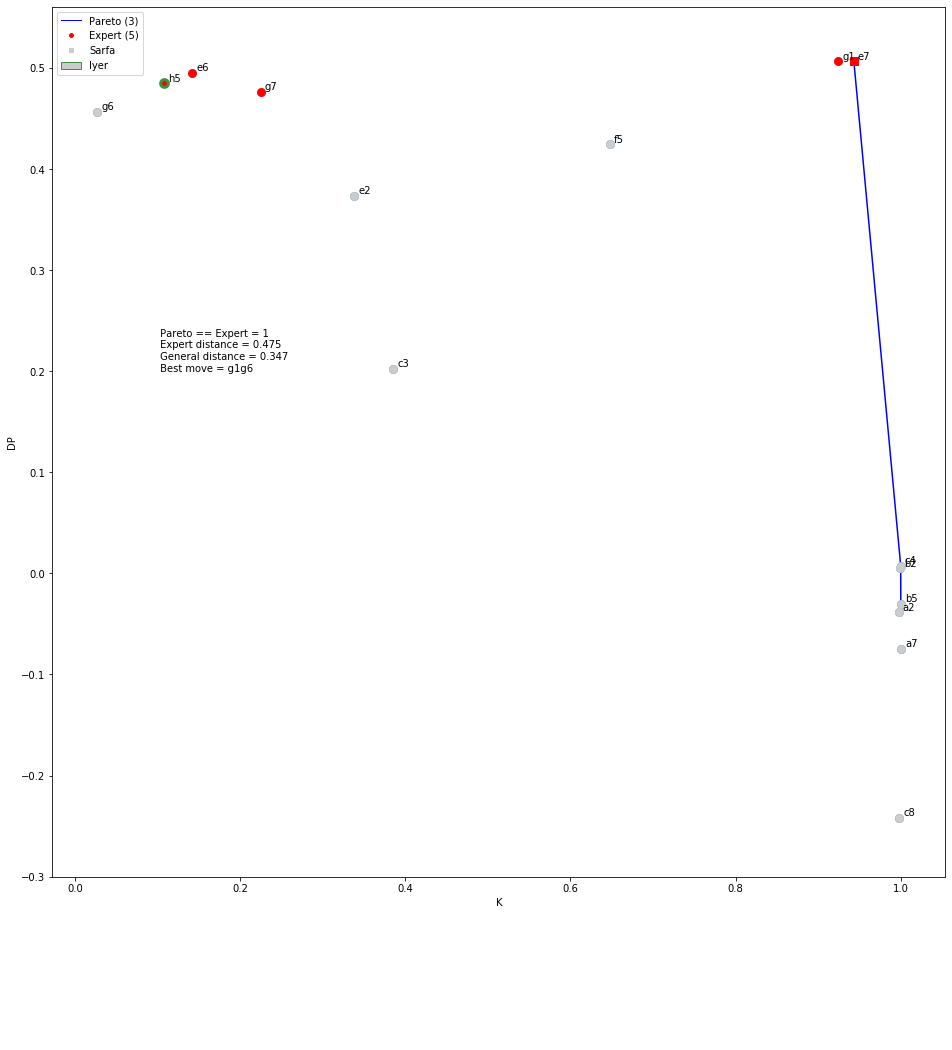

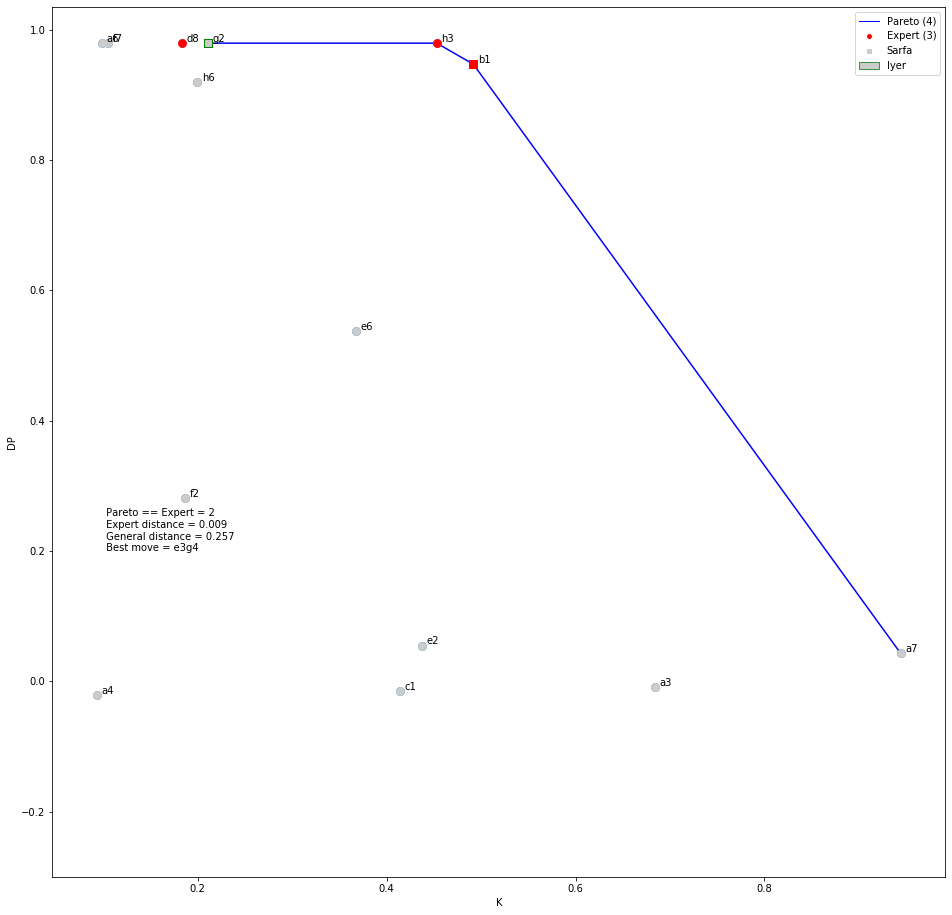

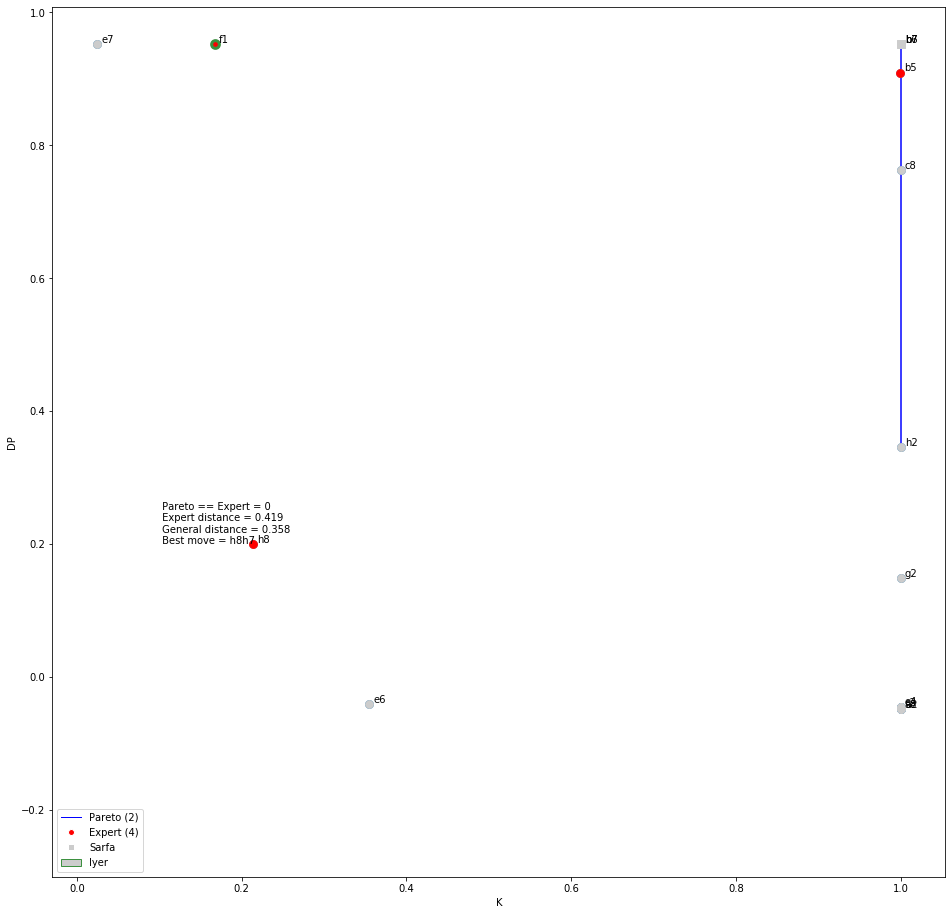

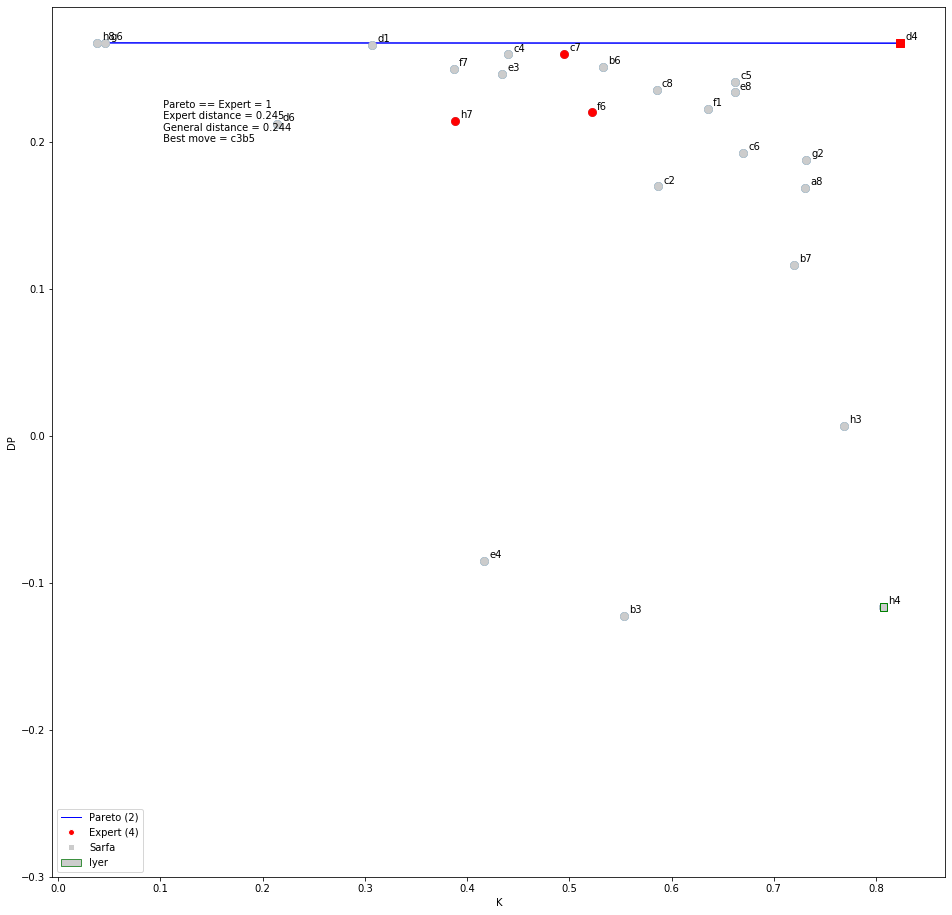

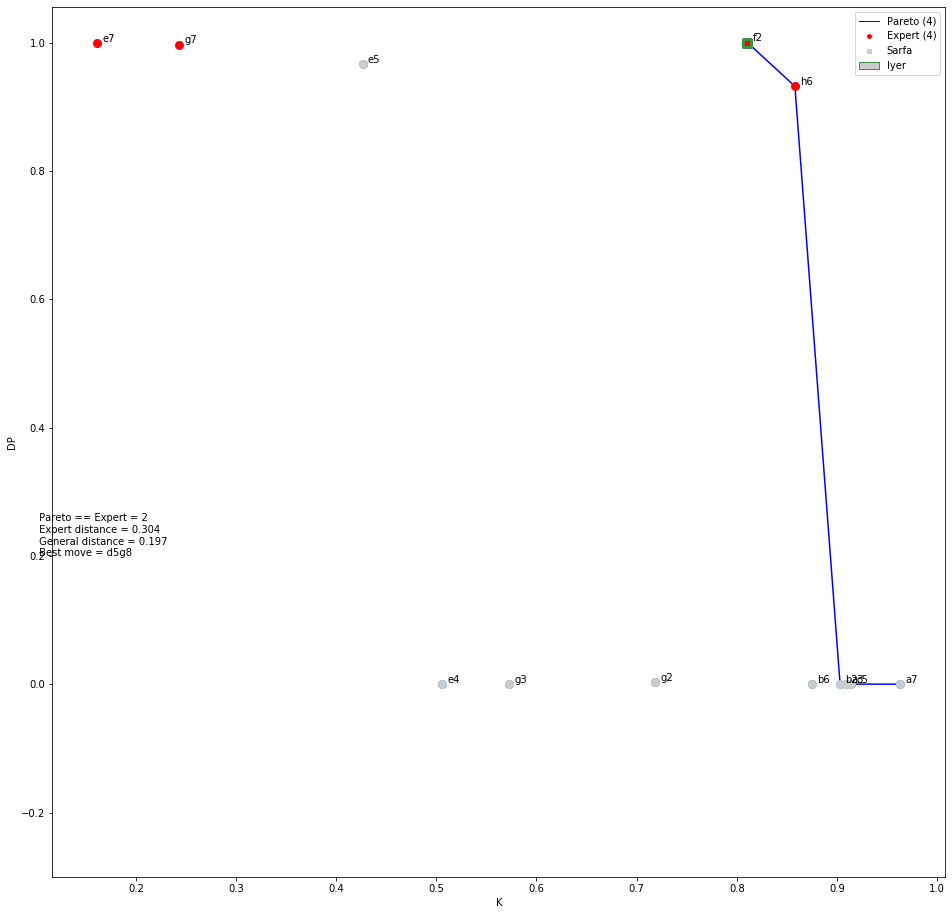

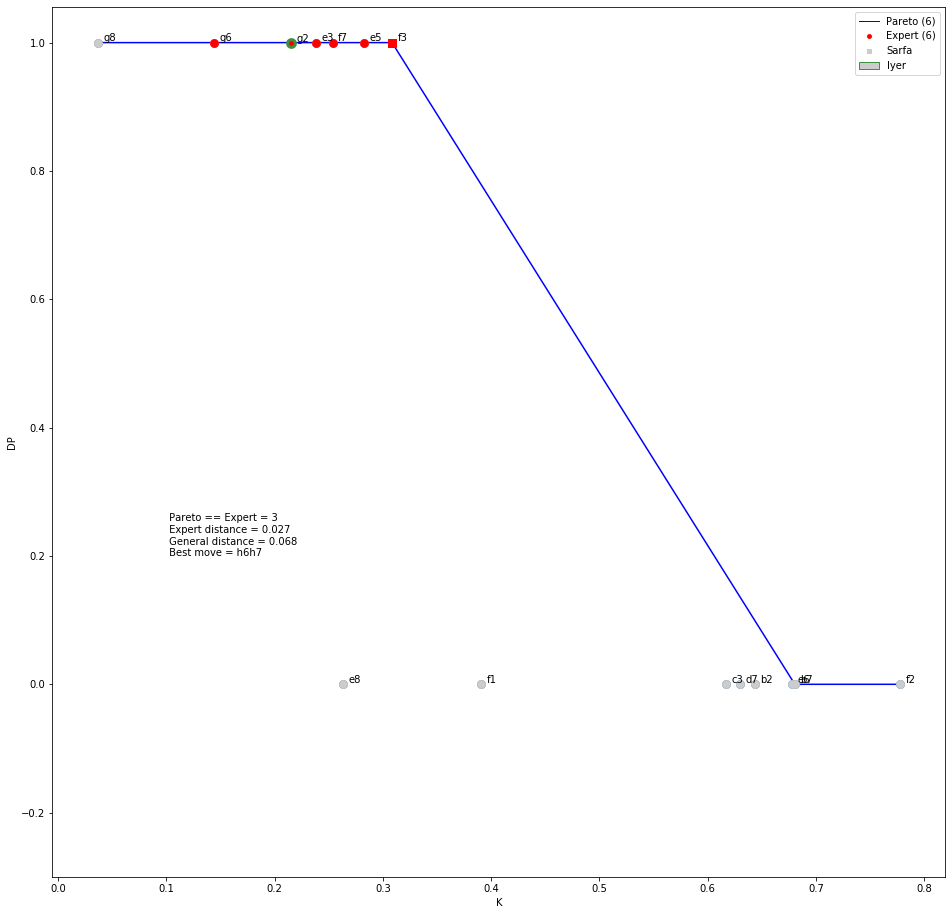

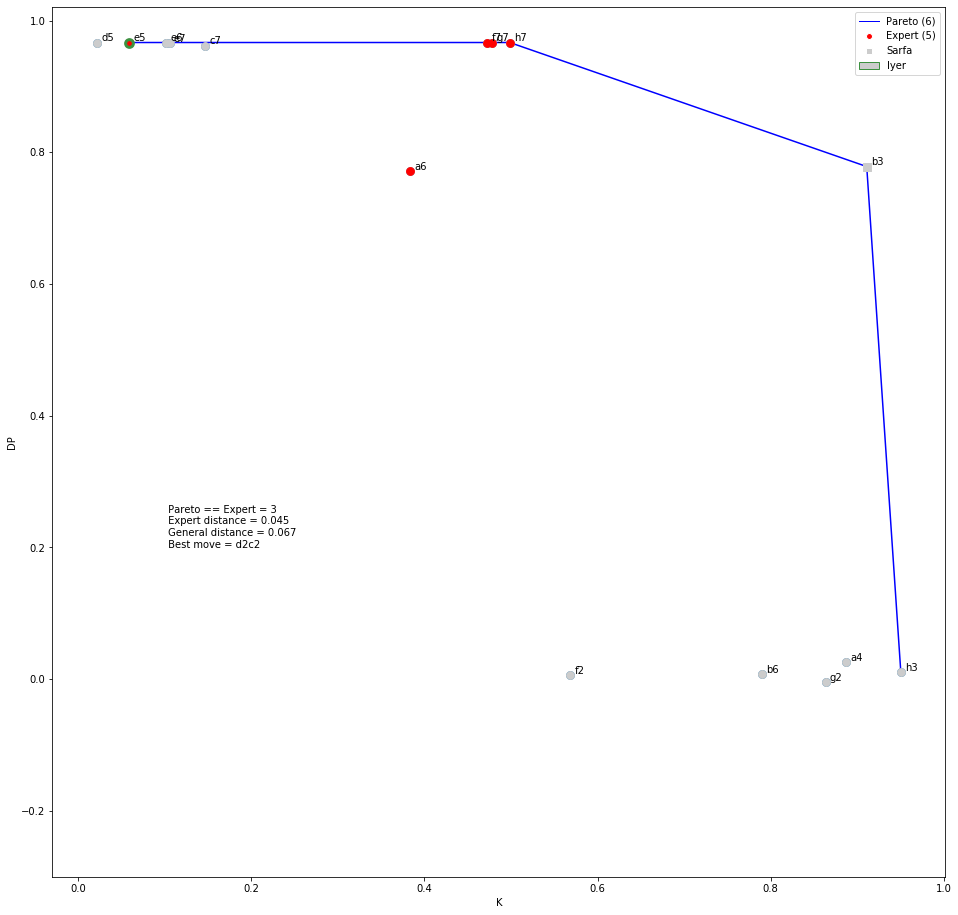

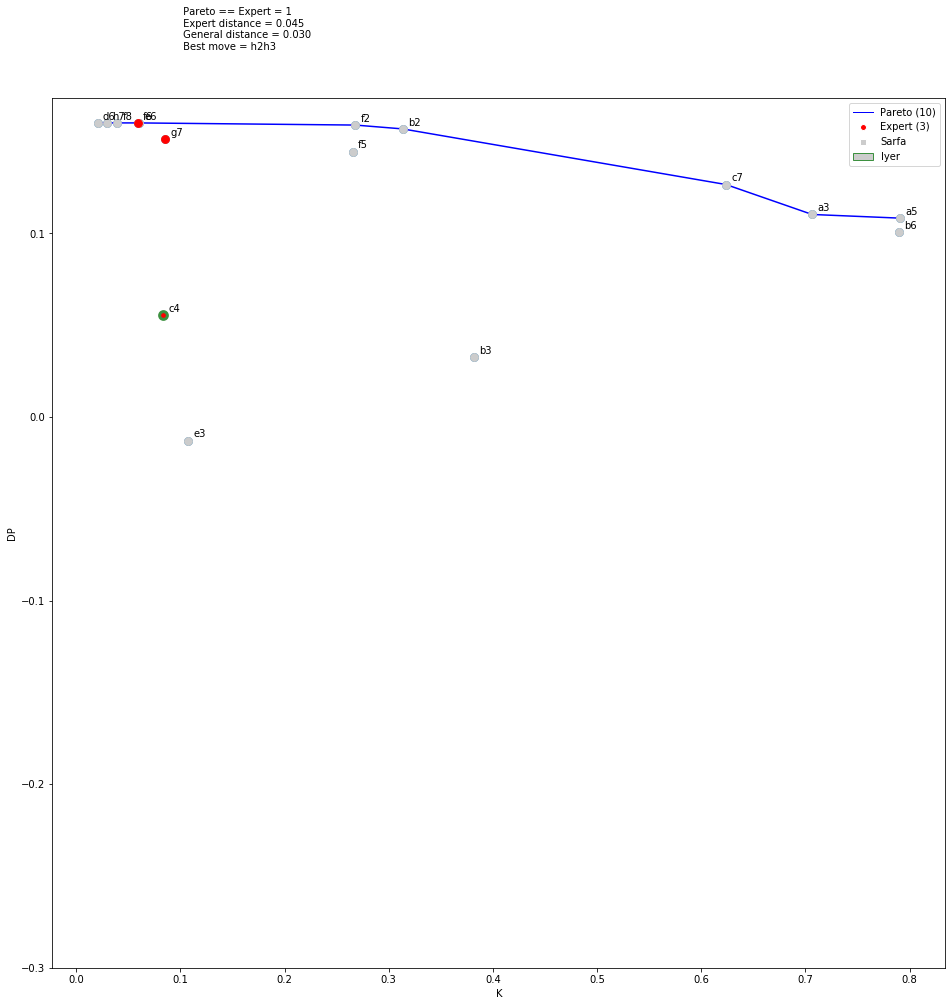

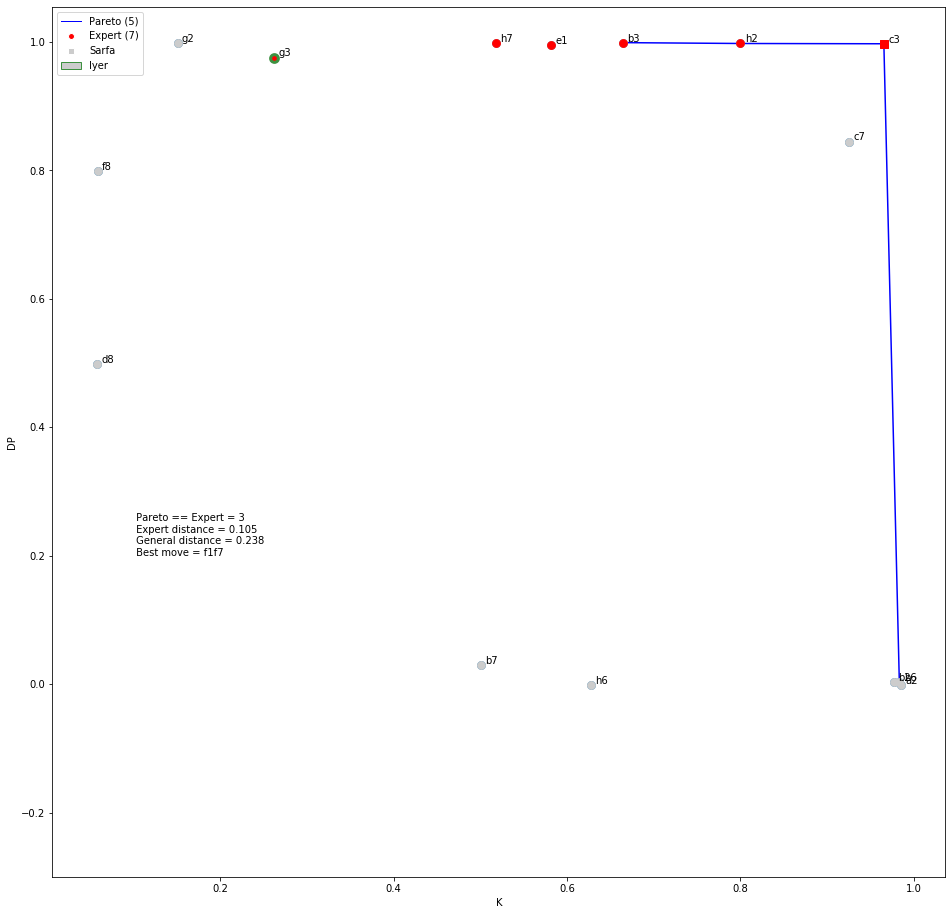

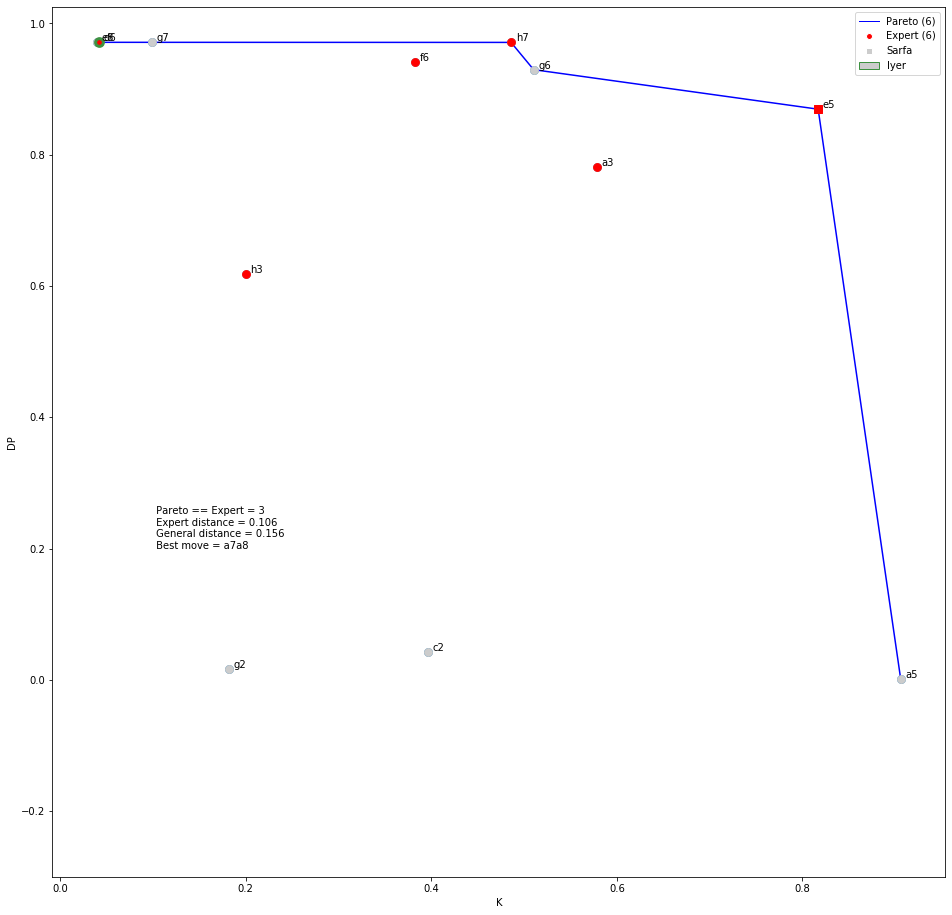

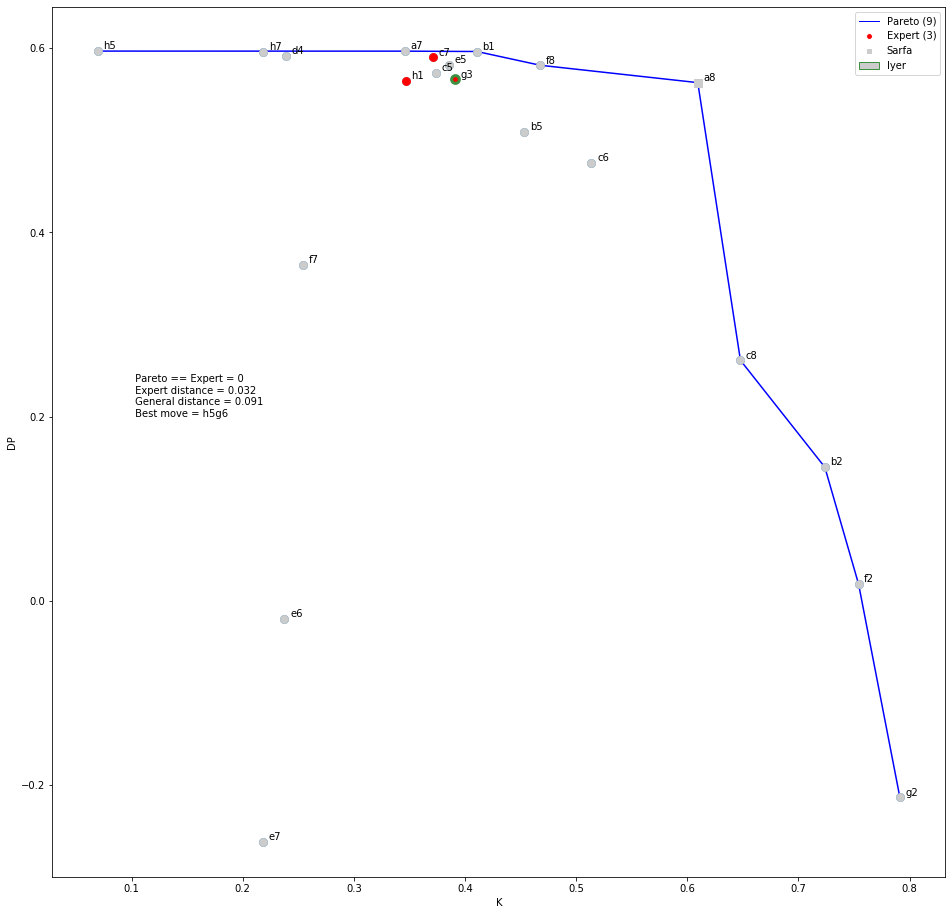

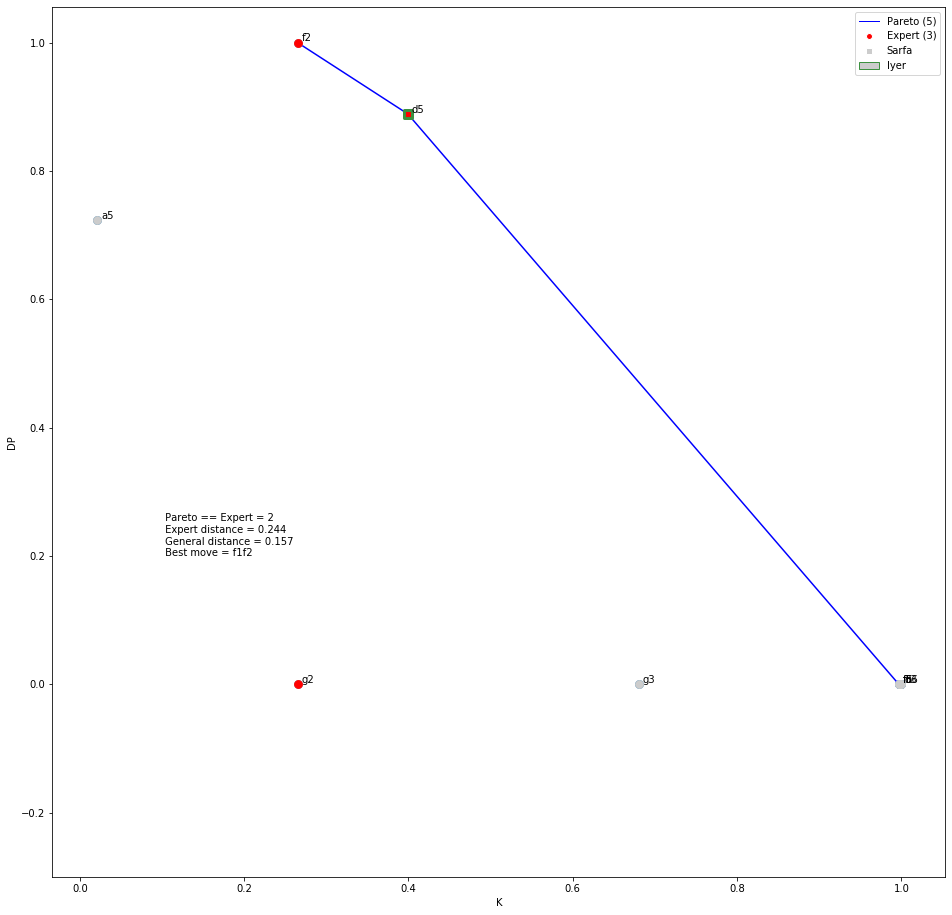

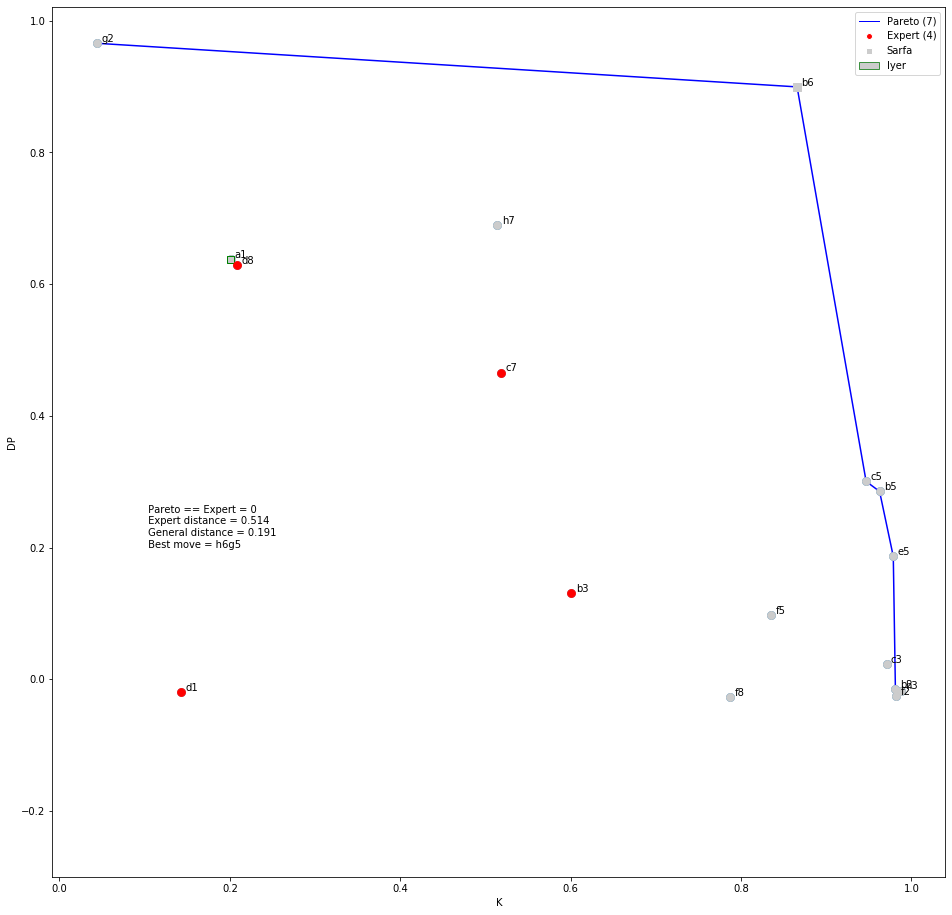

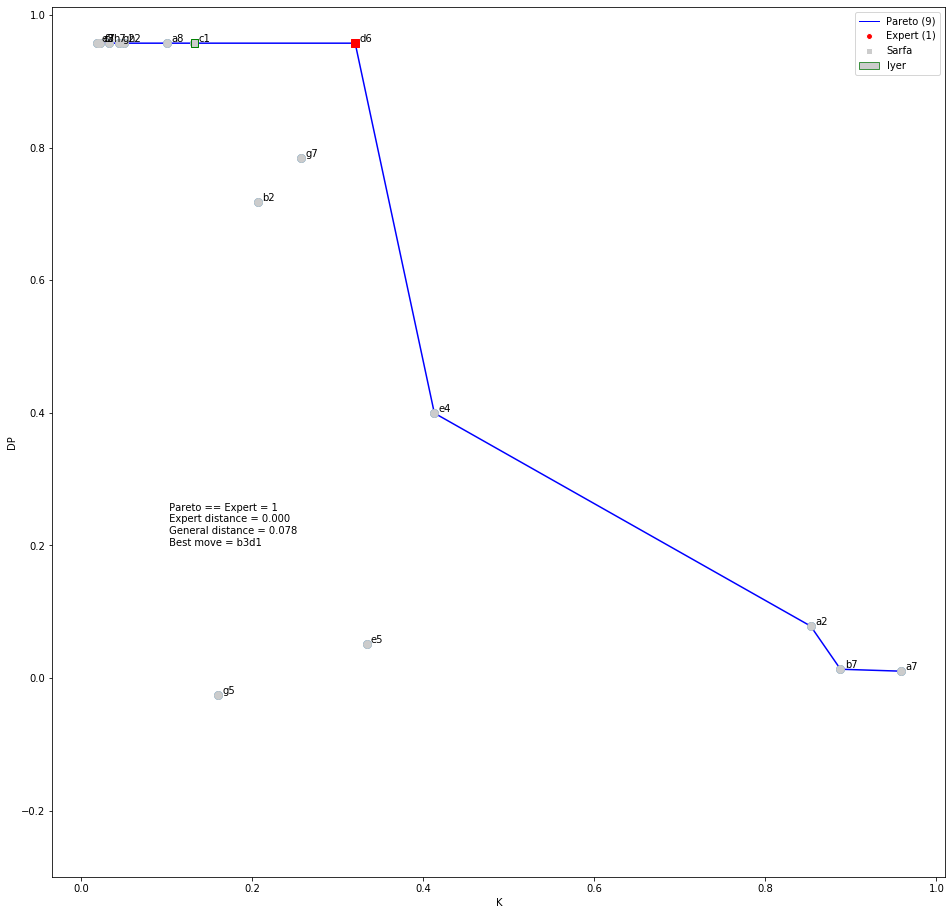

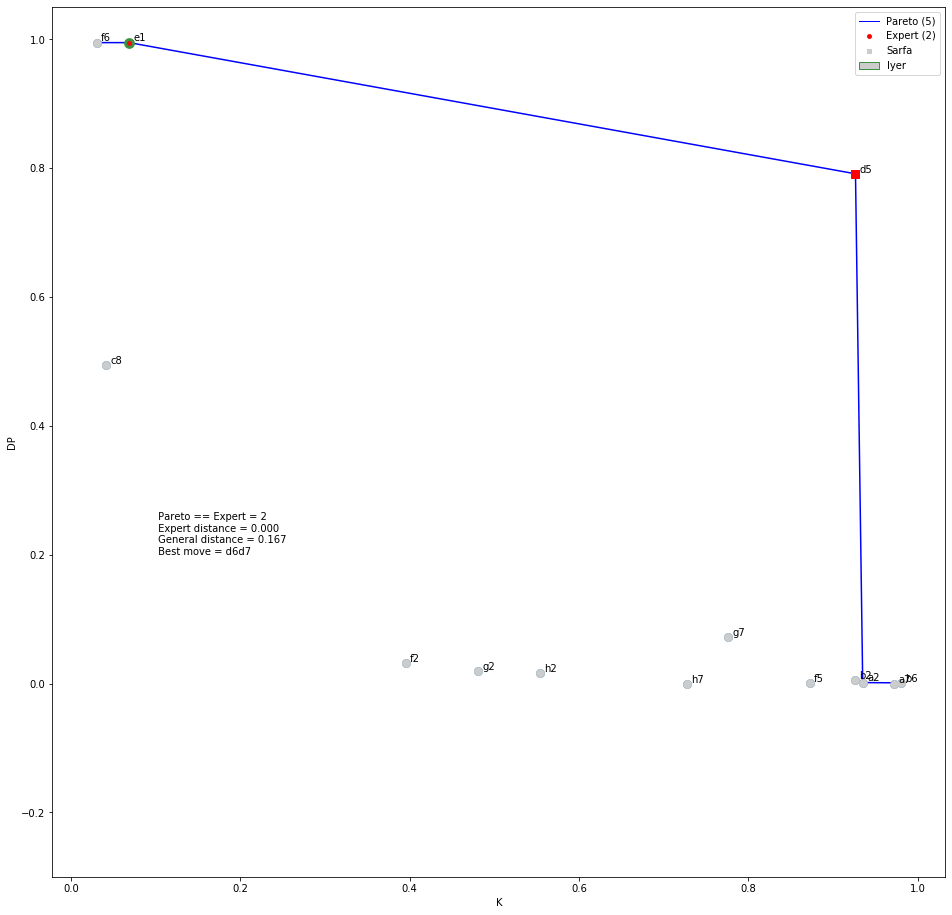

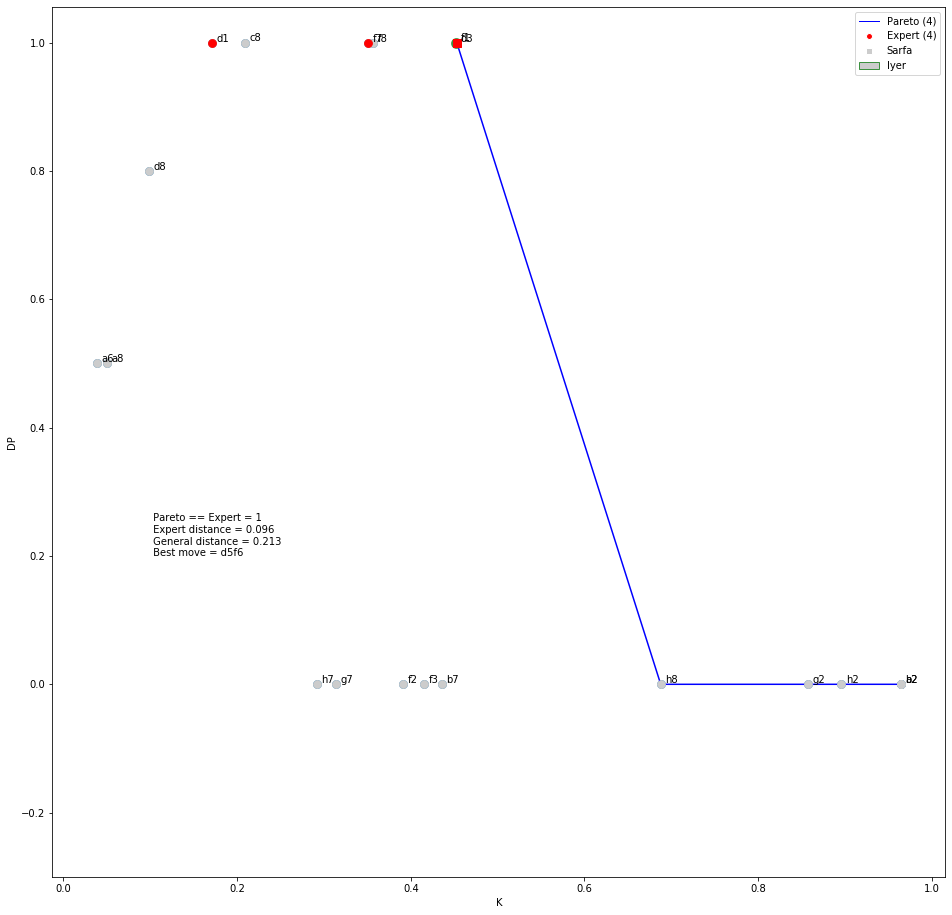

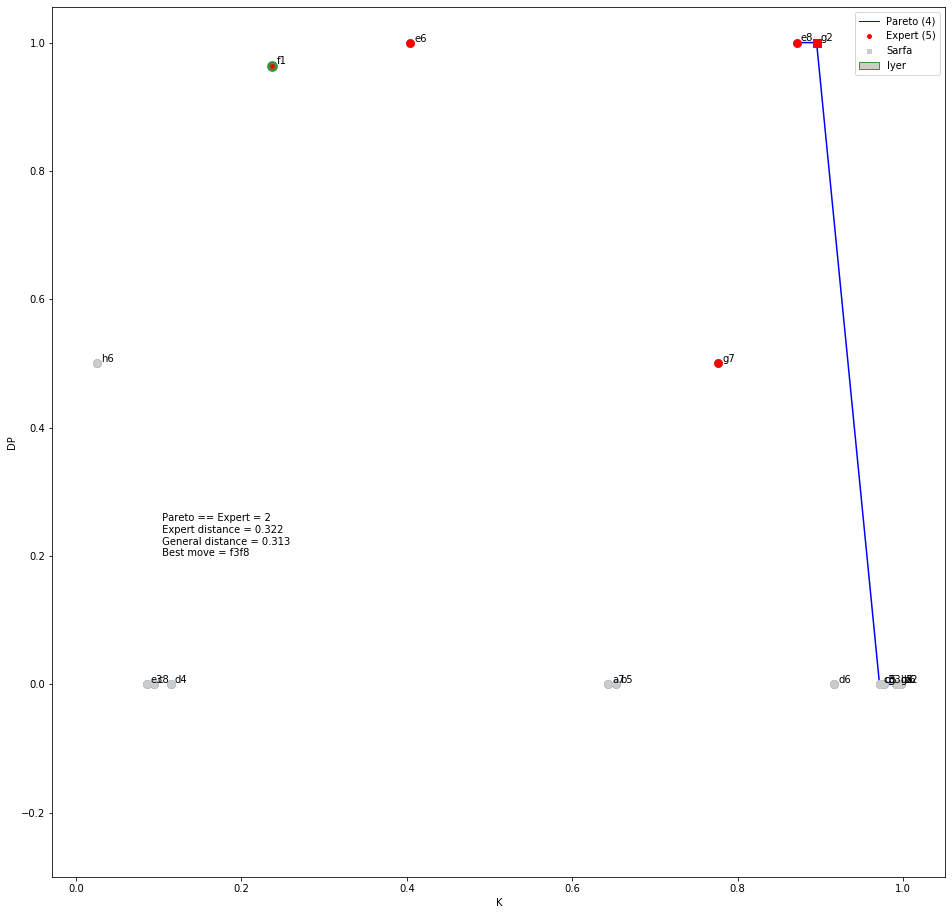

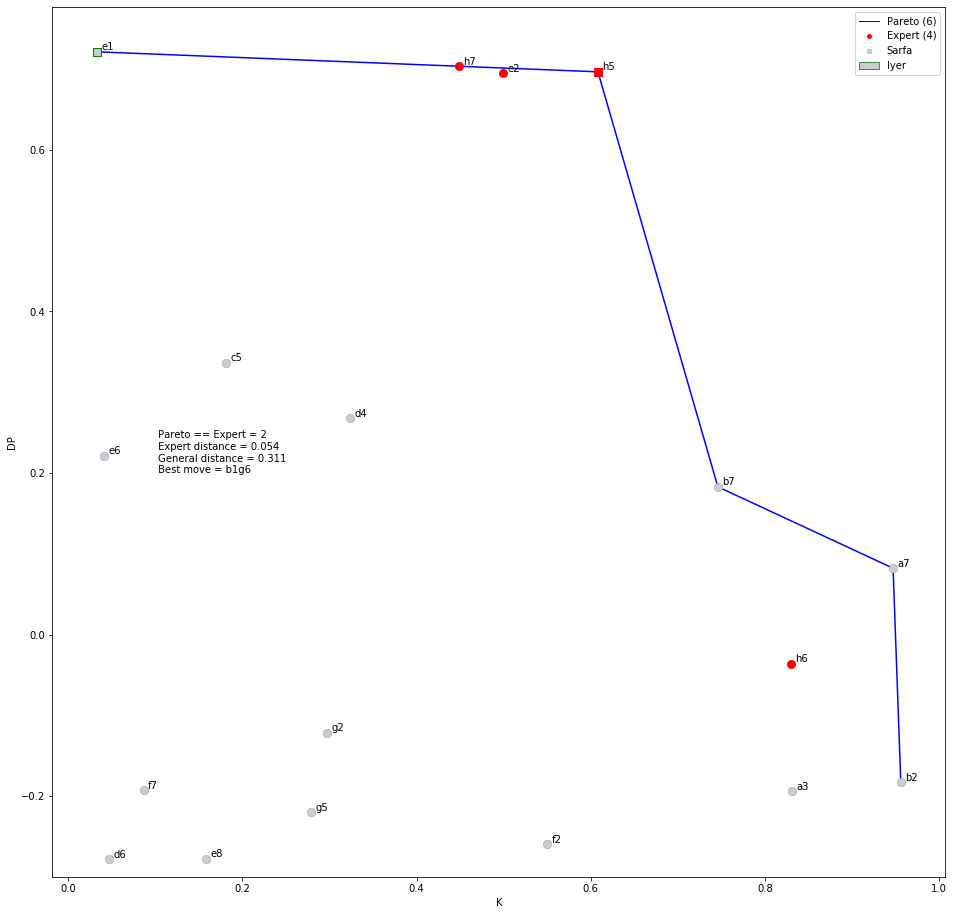

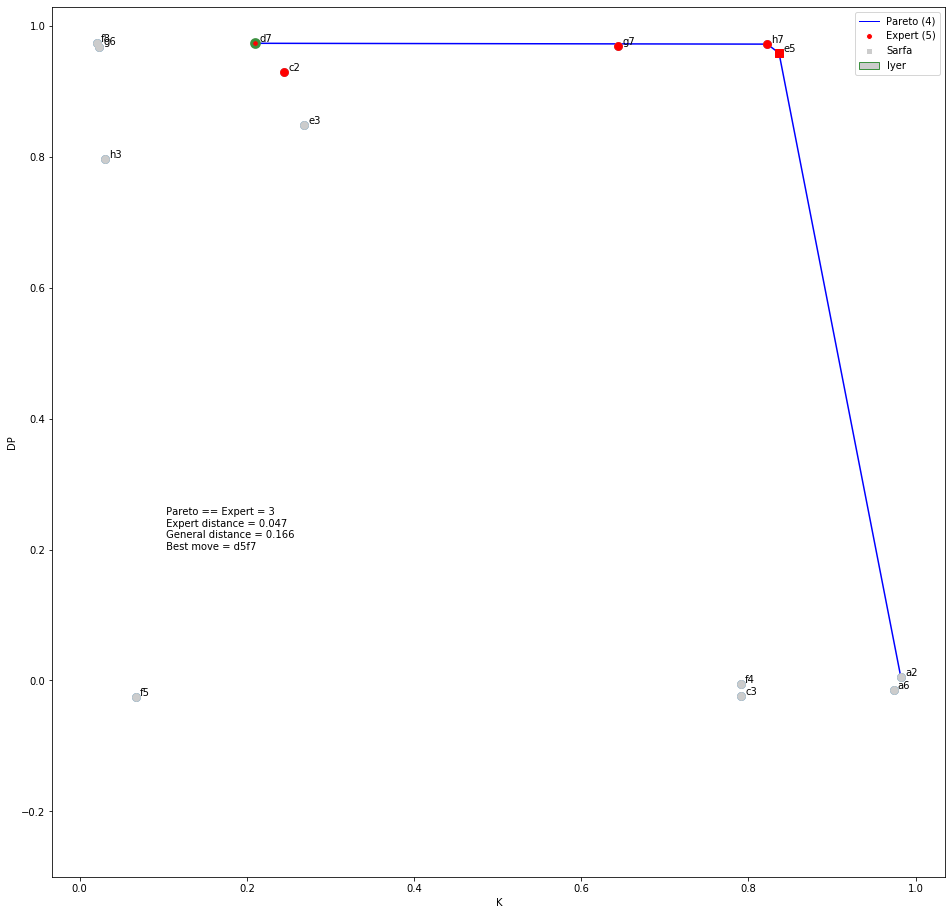

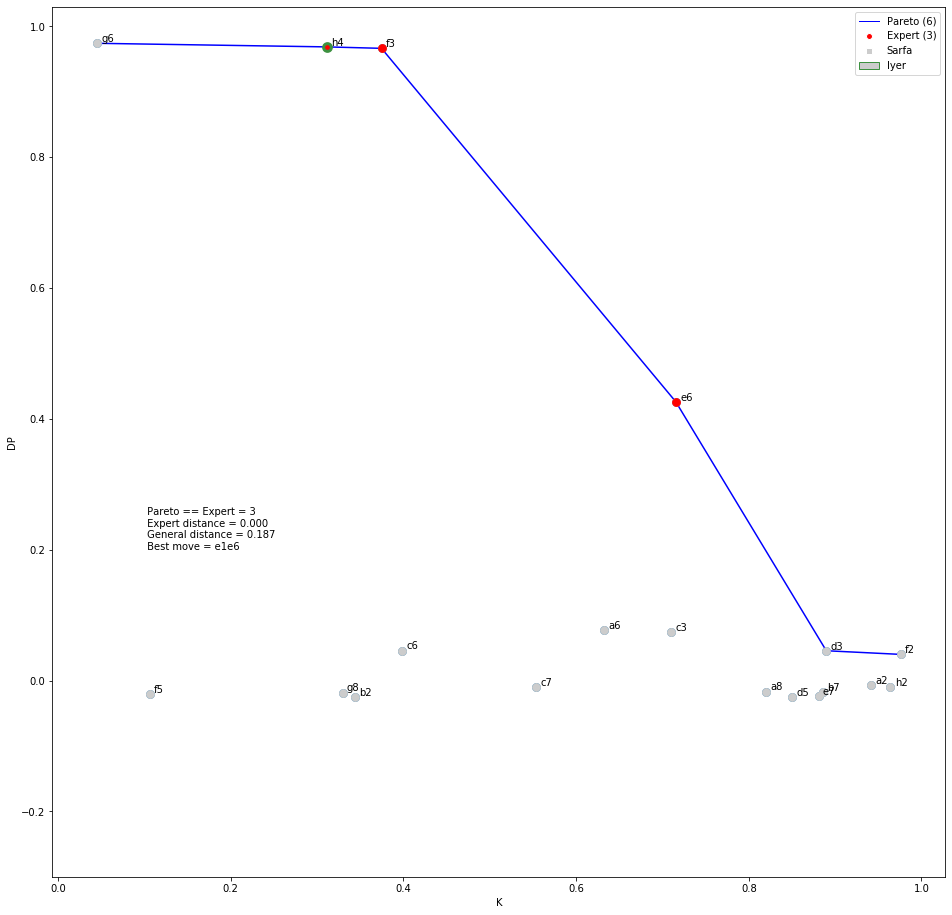

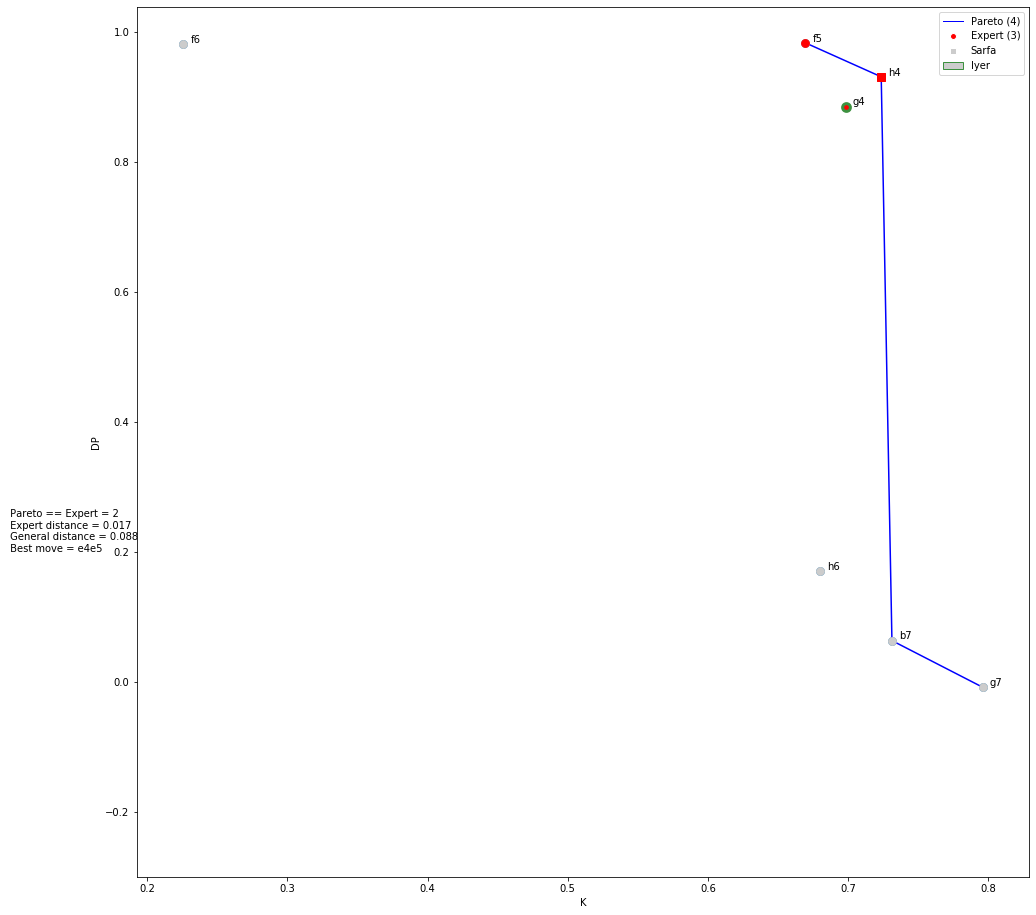

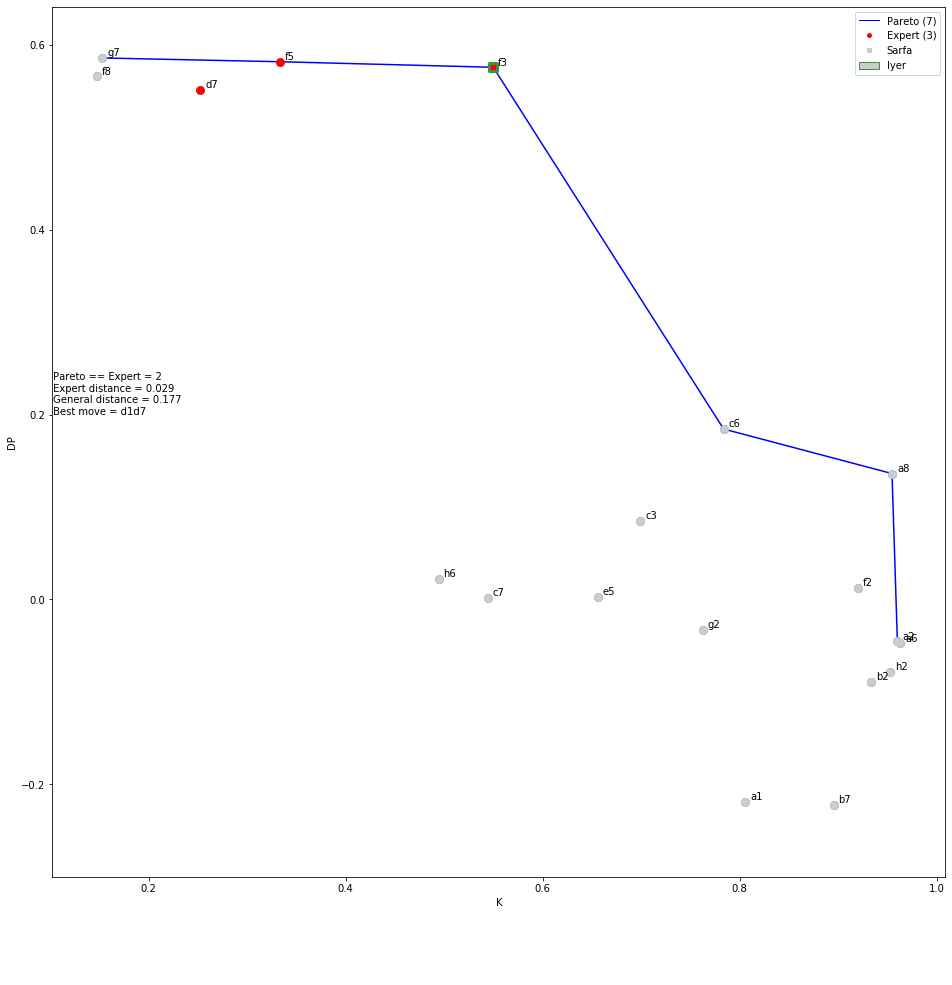

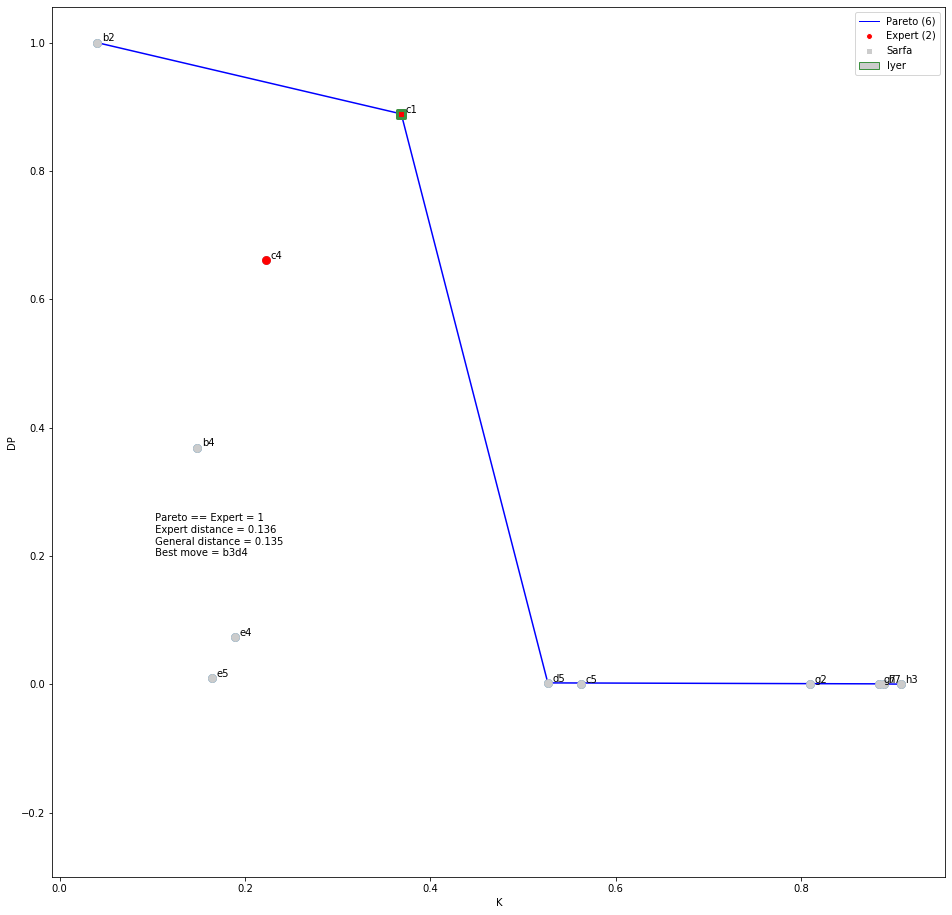

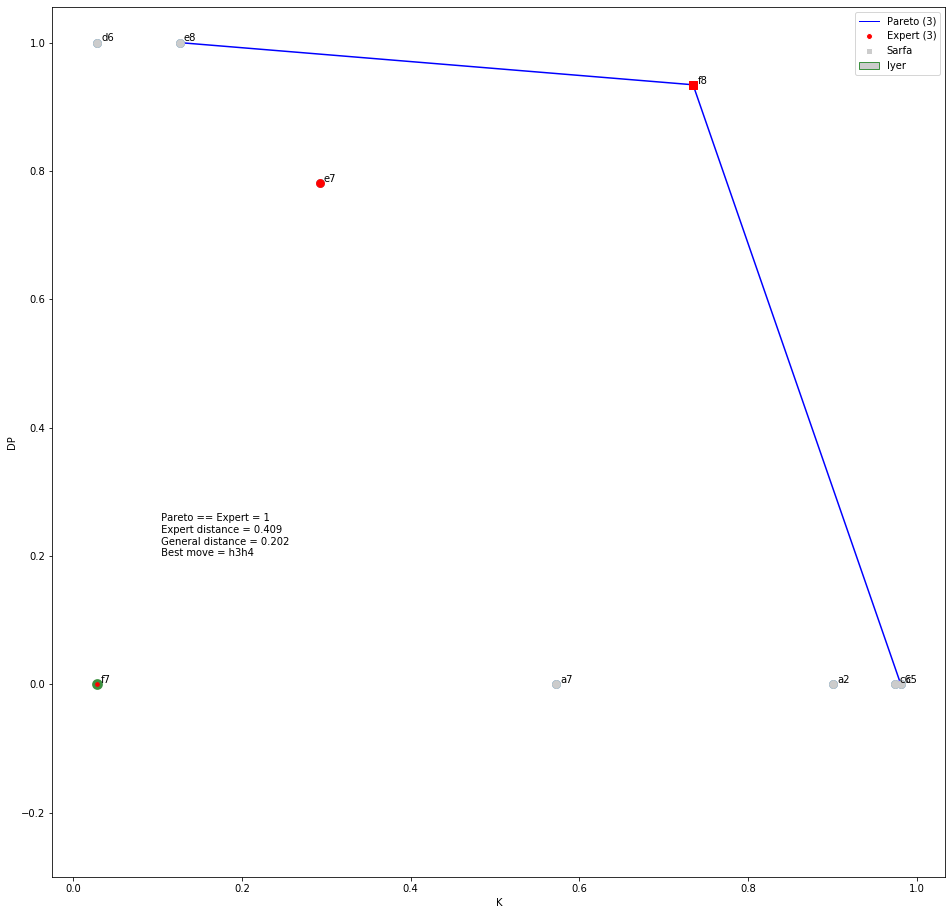

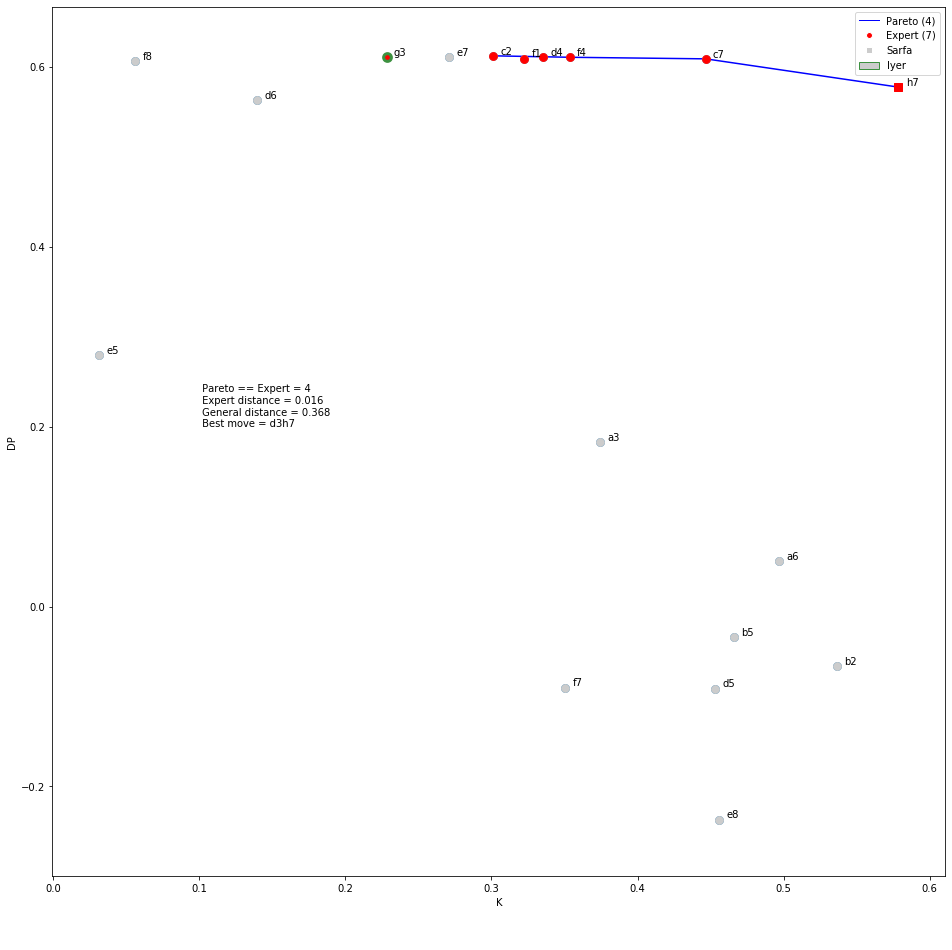

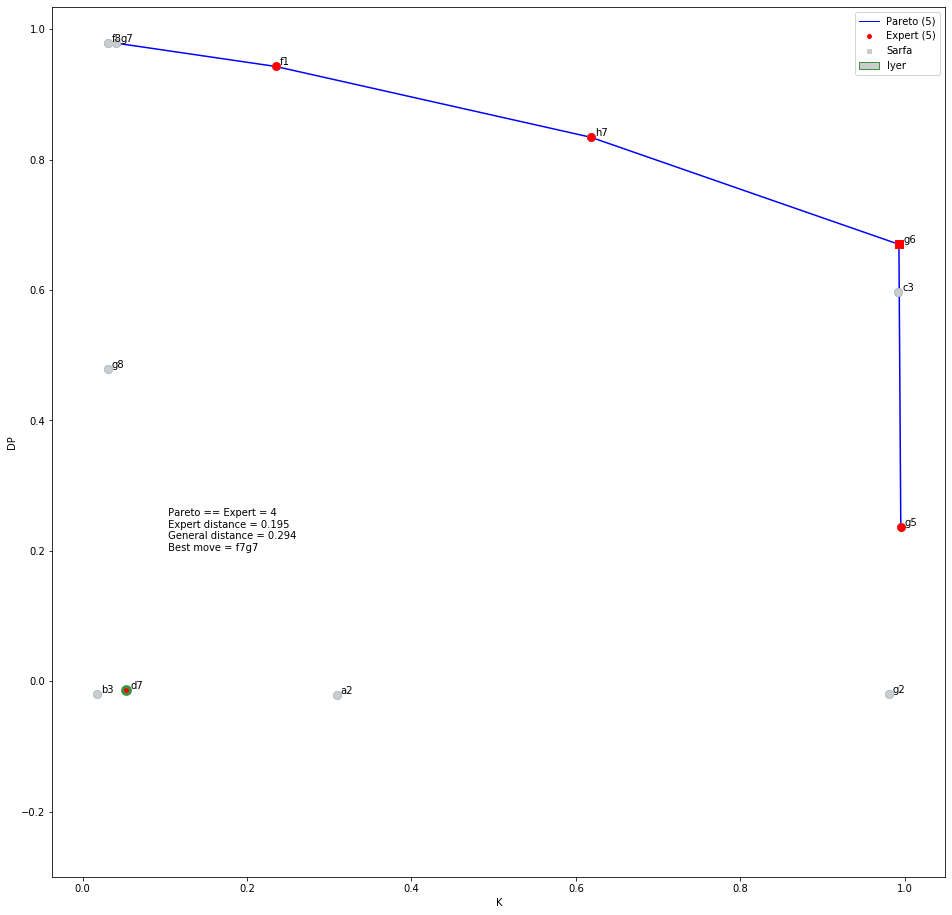

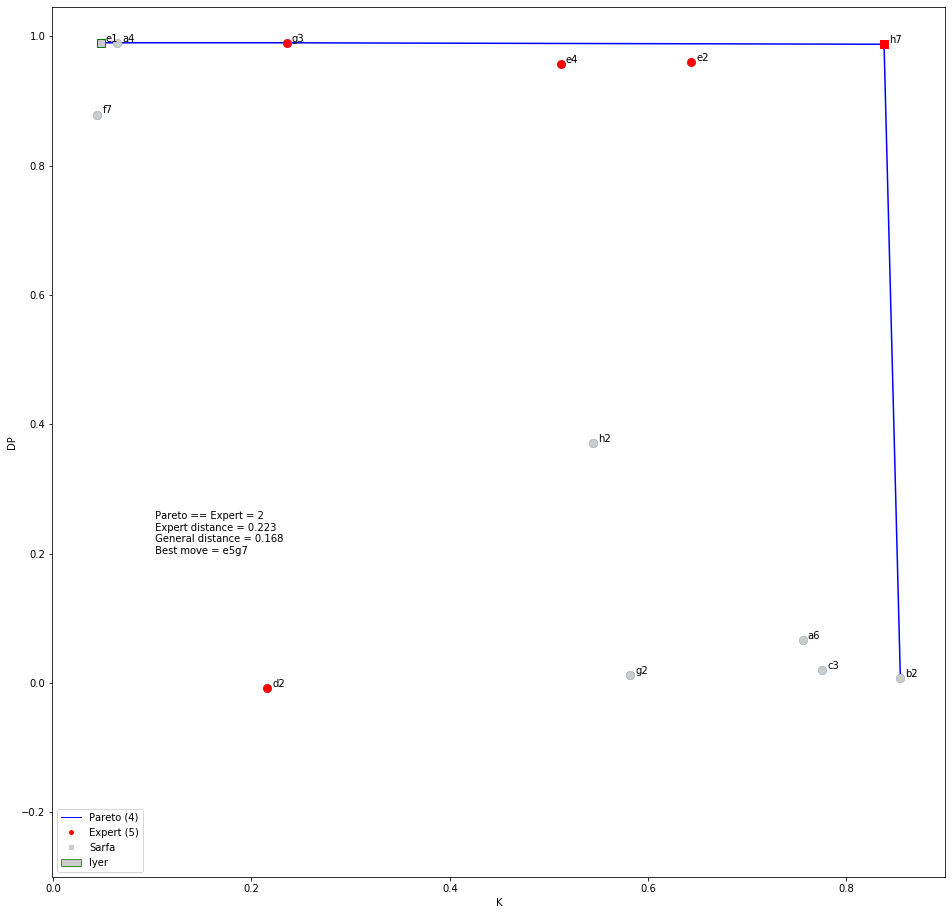

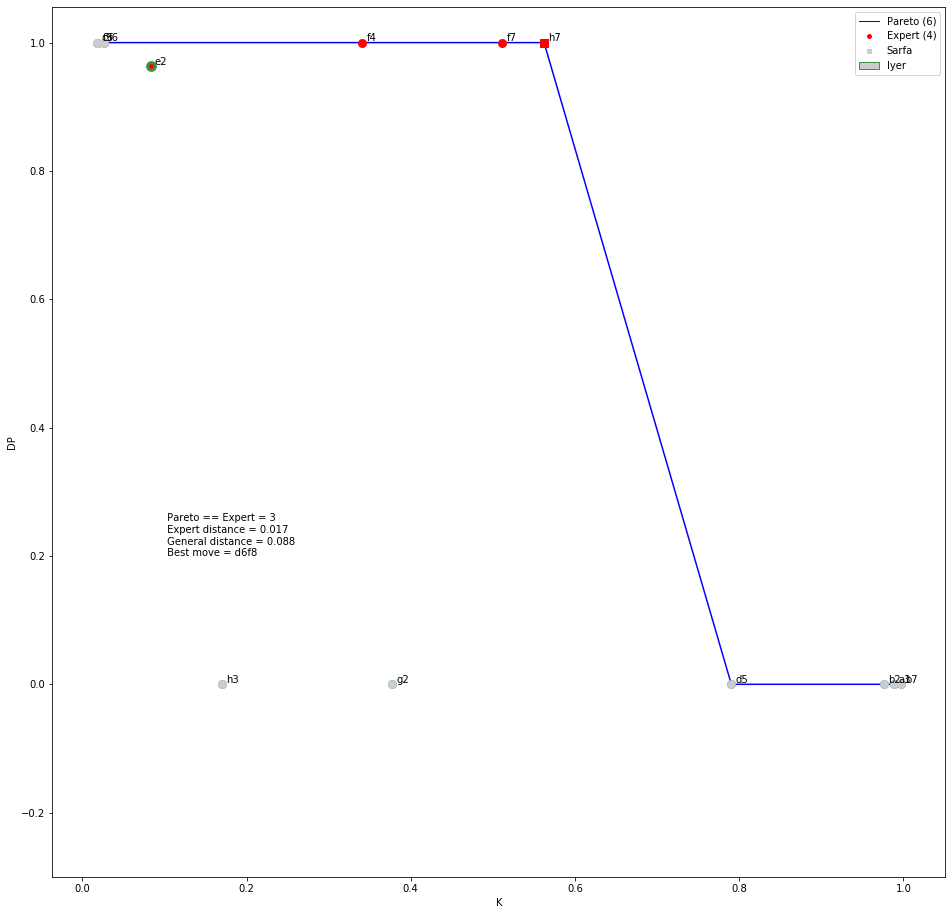

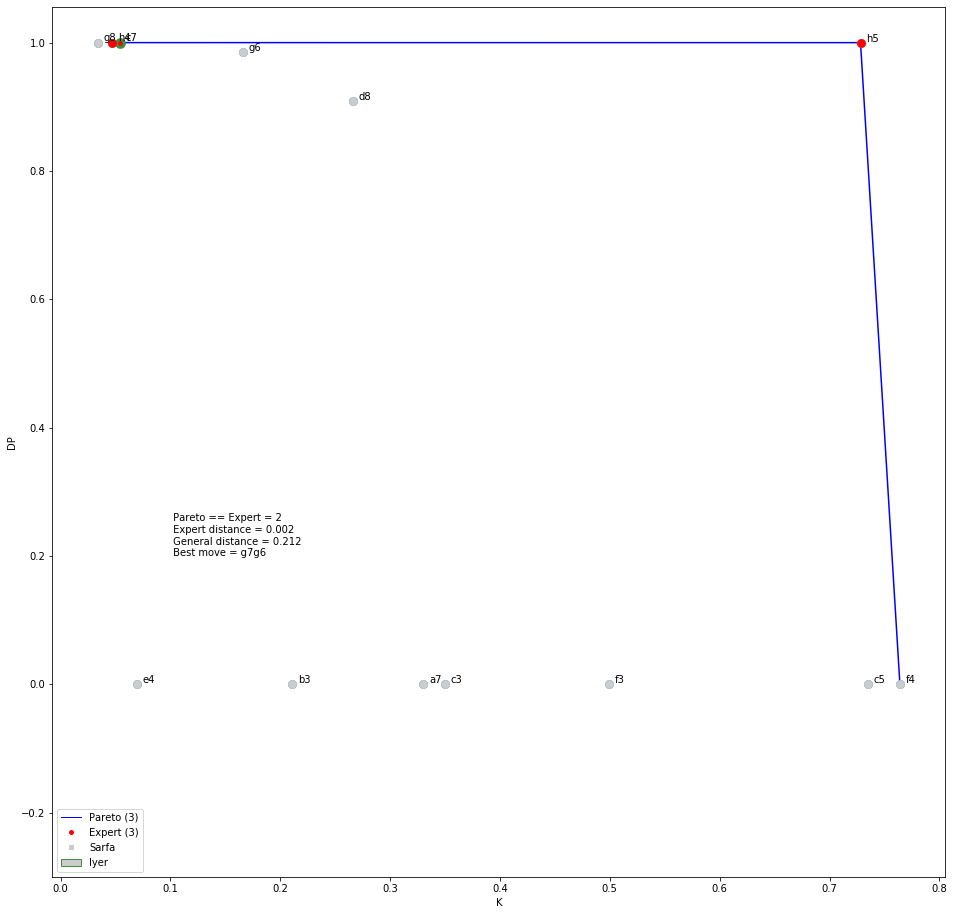

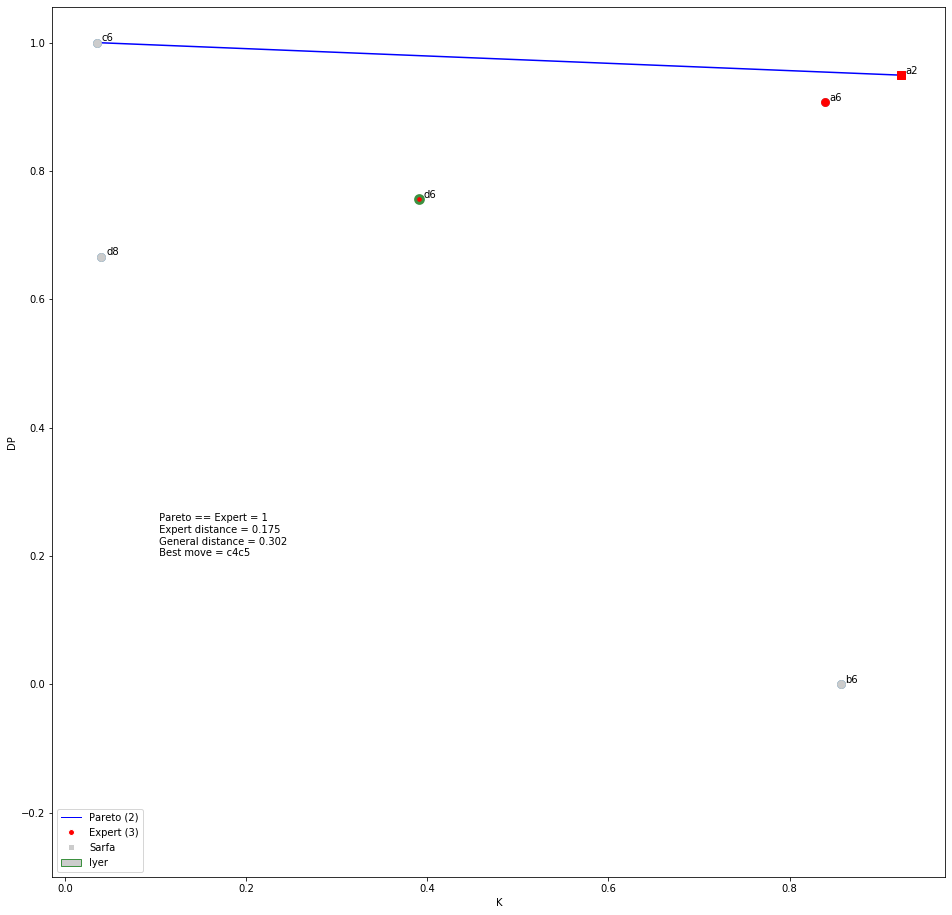

In [12]:
all_expert=[]
all_sarfa=[]
all_iyer=[]
all_pareto=[]
df_all=pd.DataFrame(columns = ['Expert','Pareto','Expert&Pareto','Sarfa Optima','Iyer Optima'])
number=100
with open('chess_saliency_databases/chess-saliency-dataset-v1.json') as f:
    d = json.load(f)

df_sarfa = pd.json_normalize(d['puzzles'])
for i in range(0,number):
   
    with open(f'file/game_{i}.json') as json_data:
        data = json.load(json_data)
    data_graph=pd.DataFrame.from_dict(data, orient='index').T.set_index('FEN')  
    dd = defaultdict(list)
    d_K=dict((key,d[key]) for d in data['K'] for key in d)
    d_DP=dict((key,d[key]) for d in data['DP'] for key in d)
    d_Sarfa=dict((key,d[key]) for d in data['SARFA'] for key in d)
    d_Iyer=dict((key,d[key]) for d in data['IYER'] for key in d)
    d_Expert=data['EXPERT']
    hard_salient=data['BEST_MOVE']
    handler,engine=select_engine()
    board = chess.Board(data['FEN'])
    evaluation=data['EvalSarfa']
    bestmove = return_bestmove(board,engine)
   
    


    for d in (d_K, d_DP): 
        for key, value in d.items():
            dd[key].append(value)

    test=dict(dd)
    df,pareto_label=identify_pareto(test,d_Sarfa,d_Iyer,d_Expert,i)
    df_all=df_all.append(df, ignore_index = True)
    generate_heatmap(evaluation,bestmove,i)

    
    y,probs_i,prob_s,pa=makeRoc(d_Expert,pareto_label,data)
    all_expert.append(y)
    all_iyer.append(probs_i)
    all_sarfa.append(prob_s)
    all_pareto.append(pa)

    im1 = PIL.Image.open(f'graphs/game_{i}.png')
    im2 = PIL.Image.open(f'svg_custom/board{i}.png')
    get_concat_h_resize(im1, im2, resize_big_image=False).save(f'finalGraphs/final_graph{i}.jpg')
    
    

In [13]:
df_all.to_excel("Statistics.xlsx") 

In [14]:
all_expert=np.array(all_expert)
all_expert = [item for sublist in all_expert for item in sublist]
all_iyer=np.array(all_iyer)
all_iyer = [item for sublist in all_iyer for item in sublist]
all_sarfa=np.array(all_sarfa)
all_sarfa = [item for sublist in all_sarfa for item in sublist]
all_pareto=np.array(all_pareto)
all_pareto = [item for sublist in all_pareto for item in sublist]

In [15]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
labels=['a','b','c']

for e in [all_sarfa,all_iyer,all_pareto]:
    fpr, tpr, thresholds = metrics.roc_curve(all_expert, e)
    auc=roc_auc_score(all_expert, e)
    result_table = result_table.append({'ehi':'pippo',
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'auc':auc}, ignore_index=True)

#result_table.set_index('ehi', inplace=True)


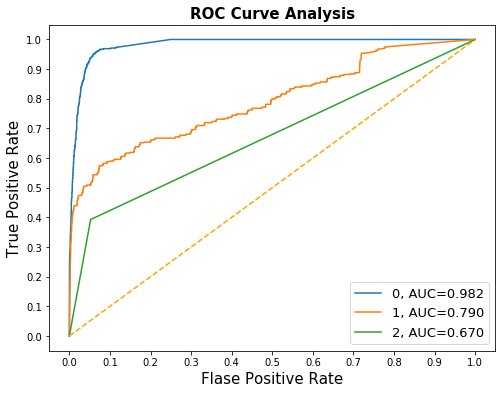

In [16]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()